# Import libraries

In [1]:
import os
import pickle as pkl

import pandas as pd
import numpy as np

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

SAVE = False 
if SAVE:
    OUTPUT_PATH = "/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  
    
import sklearn
import scanpy as sc
import seaborn as sns

import gseapy as gp
from gseapy.plot import gseaplot
import matplotlib.pylab as plt
from adjustText import adjust_text

from matplotlib_venn import venn2, venn3
from matplotlib.lines import Line2D

from pandas.io.formats.style import Styler
from sklearn import datasets, preprocessing, decomposition, model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from gseapy import Msigdb
from matplotlib.ticker import FixedLocator

In [2]:
#from matplotlib_venn import venn3_unweighted 

In [3]:
#pd.set_option('display.max_colwidth', None)

# Function

In [4]:
def filter(X):
    filter_X = X[(abs(X['log2FoldChange']) > 1) & (X['padj'] < 0.05)]
    return(filter_X)

In [5]:
def filter_s(X):
    filter_X_s = X[(abs(X['log2FoldChange']) > 1) & (X['padj'] < 0.01)]
    return(filter_X_s)

In [6]:
def down_reg(X):
    down_reg_X = X[(X['log2FoldChange']< -1) & (X['padj'] < 0.05)]
    down_reg_X = down_reg_X.sort_values(by='padj', ascending=True)
    return(down_reg_X)

In [7]:
def down_reg_s(X):
    down_reg_X_s = X[(X['log2FoldChange']< -1) & (X['padj'] < 0.01)]
    down_reg_X_s = down_reg_X_s.sort_values(by='padj', ascending=True)
    return(down_reg_X_s)

In [8]:
def up_reg(X):
    up_reg_X = X[(X['log2FoldChange']> 1) & (X['padj'] < 0.05)]
    up_reg_X = up_reg_X.sort_values(by='padj', ascending=True)
    return(up_reg_X)

In [9]:
def up_reg_s(X):
    up_reg_X_s = X[(X['log2FoldChange']> 1) & (X['padj'] < 0.01)]
    up_reg_X_s= up_reg_X_s.sort_values(by='padj', ascending=True)
    return(up_reg_X_s)

In [10]:
def up_reg_0(X):
    up_reg_X = X[(X['log2FoldChange']> 0) & (X['padj'] < 0.05)]
    up_reg_X = up_reg_X.sort_values(by='padj', ascending=True)
    return(up_reg_X)

In [11]:
def not_signification(X):
    not_signification_X = X[(X['log2FoldChange']>=-1) & (X['log2FoldChange']<= 1)]
    return(not_signification_X)

In [482]:
#最原始版本，abs(logFC)>1,padj<0.05,按照padj升序排序 small to big
def volcano_1(df,figsize):
    plt.figure(figsize=figsize)
    df_sorted = df.sort_values(by='padj', ascending=False)
    plt.scatter(x=df['log2FoldChange'],y=df['padj'].apply(lambda x:-np.log10(x)),s=100,label="Not significant",color = 'grey',alpha=0.35,edgecolor='none')

    down_df = df[(df['log2FoldChange']<=-1)&(df['padj']<=0.05)]
    up_df = df[(df['log2FoldChange']>=1)&(df['padj']<=0.05)]

    plt.scatter(x=down_df['log2FoldChange'],y=down_df['padj'].apply(lambda x:-np.log10(x)),s=100,label="Down-regulated",color="teal",alpha=0.55,edgecolor='none')
    plt.scatter(x=up_df['log2FoldChange'],y=up_df['padj'].apply(lambda x:-np.log10(x)),s=100,label="Up-regulated",color="salmon",alpha=0.55,edgecolor='none')
    
    
    down = df[(df['log2FoldChange']<=-1)&(df['padj']<=0.05)][:10]
    up = df[(df['log2FoldChange']>=1)&(df['padj']<=0.05)][:10]
    
    texts_up=[]
    for i,r in up.iterrows():
        if r['padj']== 0:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(1e-307),s=i,fontsize=12))
        else:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i,fontsize=12))
    
    texts_down=[]
    for i,r in down.iterrows():
        if r['padj']==0:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(1e-307),s=i,fontsize=12))
        else:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i,fontsize=12))
    
    adjust_text(texts_up+texts_down,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    #adjust_text(texts_up + texts_down, 
            #arrowprops=dict(arrowstyle="-", color='black', lw=0.5), 
            #expand_points=(1.2, 1.5),  # 调整点与文本之间的距离
            #force_points=150,  # 影响文本移动的力度
            #lim=100)  # 尝试调整位置的最大次数

    
    plt.xlabel("logFC")
    plt.ylabel("-logFDR")
    plt.ylim(0,350)
    plt.axvline(-1,color="grey",linestyle="--")
    plt.axvline(1,color="grey",linestyle="--")
    plt.axhline(1,color="grey",linestyle="--")
    plt.legend(loc='upper left')

In [13]:
#严格版本版本，abs(logFC)>1,padj<0.01,按照padj升序排序 small to big
def volcano_1_s(df):
    df_sorted = df.sort_values(by='padj', ascending=False)
    plt.scatter(x=df['log2FoldChange'],y=df['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant",color = 'grey')

    down_df = df[(df['log2FoldChange']<=-1)&(df['padj']<=0.01)]
    up_df = df[(df['log2FoldChange']>=1)&(df['padj']<=0.01)]

    plt.scatter(x=down_df['log2FoldChange'],y=down_df['padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
    plt.scatter(x=up_df['log2FoldChange'],y=up_df['padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="yellow")
    
    
    down = df[(df['log2FoldChange']<=-1)&(df['padj']<=0.01)][:15]
    up = df[(df['log2FoldChange']>=1)&(df['padj']<=0.01)][:15]
    
    texts_up=[]
    for i,r in up.iterrows():
        if r['padj']== 0:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(0.0000001),s=i))
        else:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i))
    
    texts_down=[]
    for i,r in down.iterrows():
        if r['padj']==0:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(0.0000001),s=i))
        else:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i))
    
    adjust_text(texts_up+texts_down,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    plt.xlabel("logFC")
    plt.ylabel("-logFDR")
    plt.axvline(-1,color="grey",linestyle="--")
    plt.axvline(1,color="grey",linestyle="--")
    plt.axhline(1,color="grey",linestyle="--")
    plt.legend()

In [14]:
#abs logFC>0 其他部分一样 （尝试重现原始数据）
def volcano_1_FDR(df):
    df_sorted = df.sort_values(by='padj', ascending=False)
    plt.scatter(x=df['log2FoldChange'],y=df['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant",color = 'grey')

    down_df = df[(df['log2FoldChange']<0)&(df['padj']<=0.05)]
    up_df = df[(df['log2FoldChange']>0)&(df['padj']<=0.05)]

    plt.scatter(x=down_df['log2FoldChange'],y=down_df['padj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
    plt.scatter(x=up_df['log2FoldChange'],y=up_df['padj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="yellow")
    
    
    down = df[(df['log2FoldChange']<0)&(df['padj']<=0.05)]
    up = df[(df['log2FoldChange']>0)&(df['padj']<=0.05)]
    
    
    texts_up=[]
    for i,r in up.iterrows():
        if r['padj']== 0:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(0.0000001),s=i))
        else:
            texts_up.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i))
    
    texts_down=[]
    for i,r in down.iterrows():
        if r['padj']==0:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(0.0000001),s=i))
        else:
            texts_down.append(plt.text(x=r['log2FoldChange'],y=-np.log10(r['padj']),s=i))
    
    adjust_text(texts_up+texts_down,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    plt.xlabel("logFC")
    plt.ylabel("-logFDR")
    plt.axvline(-1,color="grey",linestyle="--")
    plt.axvline(1,color="grey",linestyle="--")
    plt.axhline(1,color="grey",linestyle="--")
    plt.legend()

In [15]:
def save(df, file_name):
    file_path = f"/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/{file_name}.xlsx"
    df.to_excel(file_path, index=True)

In [16]:
def gsea(df):
    df = df.reset_index()
    ranking = df[['symbol','stat']].dropna().sort_values('stat',ascending=False)
    ranking['symbol'] = ranking['symbol'].str.upper()
    pre_res = gp.prerank(rnk=ranking, gene_sets = ['GO_Biological_Process_2023',ranking['symbol']],
                     seed = 6,permutation_num = 100) 
    out = []
    for term in list(pre_res.results):
        out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])
    out_df=pd.DataFrame(out,columns =['Term','fdr','es','nes']).sort_values('fdr').reset_index(drop=True)
    return out_df
    
    #pre_res = gp.prerank(rnk=ranking,gene_sets = ['GO_Biological_Process_2021',])
    #return ranking

In [17]:
def hallmark_enrichment(df):
    filter_test = df.copy()
    filter_test = filter_test[filter_test.index.notnull()]
    index_list = filter_test.index.tolist()
    enrichment_analysis = gp.enrichr(
    gene_list=index_list,  
    gene_sets="/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt",  
    outdir="/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc",  
    cutoff=10,
    verbose=True)
    enrichment_results = enrichment_analysis.results
    filtered_rows = enrichment_analysis.results[enrichment_analysis.results['P-value'] < 0.05]
    out_df = filtered_rows[['Term', 'P-value', 'Adjusted P-value','Genes']]
    out_df = out_df.sort_values(by='Adjusted P-value', ascending=True)
    return out_df

In [18]:
def up(df):
    up_df = pd.DataFrame(columns=df.columns)
    for index, row in df.iterrows():
        if row['log2FoldChange'] > 0:
            up_df = pd.concat([up_df, row.to_frame().T], ignore_index=False)
    return hallmark_enrichment(up_df)

In [19]:
def down(df):
    down_df = pd.DataFrame(columns=df.columns)
    for index, row in df.iterrows():
        if row['log2FoldChange'] < 0:
            down_df = pd.concat([down_df, row.to_frame().T], ignore_index=False)
    return hallmark_enrichment(down_df)

In [20]:
def add_DEG_column(input_df):
    X = input_df.copy()
    X['DEG'] = 0
    X.loc[(X['log2FoldChange'] > 1) & (X['padj'] < 0.05), 'DEG'] = 1
    X.loc[(X['log2FoldChange'] < -1) & (X['padj'] < 0.05), 'DEG'] = -1
    return X

In [21]:
def add_prefix_to_columns(df,X):
    new_columns = [X + col for col in df.columns]
    df.columns = new_columns
    return df

# Files Processing

## All the datas from two sets

In [22]:
df_068 = pd.read_csv('068-DiffGeneExpAnalysis_filtered_GLM.csv',index_col=0)
df_122 = pd.read_csv('122-DiffGeneExpAnalysis_Flt_GLM.csv',index_col=0)

In [23]:
df_122.rename(columns={'symbol':'symbol_1'},inplace=True)

df_122.head()

In [24]:
combo_df_1=pd.concat([df_068,df_122],axis=1)
combo_df_1.to_csv("122&068.csv",index=True)

In [25]:
print(combo_df_1.index)
combo_df_1.head()

Index(['ENSMUSG00000033845', 'ENSMUSG00000025903', 'ENSMUSG00000033813',
       'ENSMUSG00000062588', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
       'ENSMUSG00000025907', 'ENSMUSG00000090031', 'ENSMUSG00000051285',
       'ENSMUSG00000103509',
       ...
       'ENSMUSG00000075268', 'ENSMUSG00000078528', 'ENSMUSG00000024810',
       'ENSMUSG00000090369', 'ENSMUSG00000118217', 'ENSMUSG00000051984',
       'ENSMUSG00000118210', 'ENSMUSG00000064344', 'ENSMUSG00000064357',
       'ENSMUSG00000064372'],
      dtype='object', name='ensembl', length=13977)


,entrez,symbol,length,ctrl_1,ctrl_2,ctrl_3,ctrl_4,Pp_1,Pp_2,Pp_3,...,ctrl_7,ctrl_8,Pp_5,Pp_6,Pp_7,Pp_8,X2_Pp_1,X2_Pp_2,X2_Pp_3,X2_Pp_4
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,27395,Mrpl15,8487.0,2484.0,2021.0,2681.0,2452.0,2418.0,2261.0,2180.0,...,2644.0,2639.0,1833.0,2386.0,2403.0,2182.0,2347.0,2807.0,2162.0,2025.0
ENSMUSG00000025903,18777,Lypla1,7145.0,1044.0,991.0,1151.0,1244.0,1364.0,1329.0,1195.0,...,1292.0,1235.0,938.0,1369.0,1352.0,1229.0,1119.0,1180.0,949.0,928.0
ENSMUSG00000033813,21399,Tcea1,3017.0,2810.0,2327.0,2991.0,3009.0,2810.0,2561.0,2509.0,...,3129.0,2946.0,1852.0,2580.0,2659.0,2304.0,2736.0,2720.0,2448.0,2292.0
ENSMUSG00000062588,NaN,Gm6104,603.0,21.0,11.0,27.0,24.0,14.0,21.0,20.0,...,17.0,24.0,11.0,30.0,30.0,28.0,30.0,15.0,19.0,13.0
ENSMUSG00000002459,58175,Rgs20,4239.0,54.0,49.0,48.0,73.0,109.0,87.0,109.0,...,50.0,47.0,62.0,93.0,108.0,79.0,51.0,55.0,54.0,46.0


In [26]:
combo_df_1.drop(columns=['entrez','length','symbol','symbol_1'],inplace=True)

In [27]:
combo_df_1.head()

,ctrl_1,ctrl_2,ctrl_3,ctrl_4,Pp_1,Pp_2,Pp_3,Pp_4,Pm_1,Pm_2,...,ctrl_7,ctrl_8,Pp_5,Pp_6,Pp_7,Pp_8,X2_Pp_1,X2_Pp_2,X2_Pp_3,X2_Pp_4
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,2484.0,2021.0,2681.0,2452.0,2418.0,2261.0,2180.0,2493.0,2862.0,2452.0,...,2644.0,2639.0,1833.0,2386.0,2403.0,2182.0,2347.0,2807.0,2162.0,2025.0
ENSMUSG00000025903,1044.0,991.0,1151.0,1244.0,1364.0,1329.0,1195.0,1243.0,1141.0,1200.0,...,1292.0,1235.0,938.0,1369.0,1352.0,1229.0,1119.0,1180.0,949.0,928.0
ENSMUSG00000033813,2810.0,2327.0,2991.0,3009.0,2810.0,2561.0,2509.0,2698.0,2770.0,2887.0,...,3129.0,2946.0,1852.0,2580.0,2659.0,2304.0,2736.0,2720.0,2448.0,2292.0
ENSMUSG00000062588,21.0,11.0,27.0,24.0,14.0,21.0,20.0,18.0,26.0,17.0,...,17.0,24.0,11.0,30.0,30.0,28.0,30.0,15.0,19.0,13.0
ENSMUSG00000002459,54.0,49.0,48.0,73.0,109.0,87.0,109.0,105.0,86.0,60.0,...,50.0,47.0,62.0,93.0,108.0,79.0,51.0,55.0,54.0,46.0


combo_df_test = combo_df_1

combo_df_test.index

combo_df_test['library_size'] = combo_df_test.sum(axis=1)
combo_df_test

combo_df_1 = combo_df_1[combo_df_1.sum(axis=1)>0] (if the df is from raw data set)

In [28]:
combo_df_1 = combo_df_1.T

In [29]:
combo_df_1

ensembl,ENSMUSG00000033845,ENSMUSG00000025903,ENSMUSG00000033813,ENSMUSG00000062588,ENSMUSG00000002459,ENSMUSG00000033793,ENSMUSG00000025907,ENSMUSG00000090031,ENSMUSG00000051285,ENSMUSG00000103509,...,ENSMUSG00000075268,ENSMUSG00000078528,ENSMUSG00000024810,ENSMUSG00000090369,ENSMUSG00000118217,ENSMUSG00000051984,ENSMUSG00000118210,ENSMUSG00000064344,ENSMUSG00000064357,ENSMUSG00000064372
ctrl_1,2484.0,1044.0,2810.0,21.0,54.0,2476.0,2275.0,18.0,820.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctrl_2,2021.0,991.0,2327.0,11.0,49.0,2004.0,1847.0,16.0,661.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctrl_3,2681.0,1151.0,2991.0,27.0,48.0,2647.0,2403.0,30.0,872.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctrl_4,2452.0,1244.0,3009.0,24.0,73.0,2583.0,2330.0,20.0,841.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pp_1,2418.0,1364.0,2810.0,14.0,109.0,2153.0,2369.0,21.0,870.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pp_2,2261.0,1329.0,2561.0,21.0,87.0,2027.0,2201.0,20.0,893.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pp_3,2180.0,1195.0,2509.0,20.0,109.0,1867.0,2073.0,7.0,846.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pp_4,2493.0,1243.0,2698.0,18.0,105.0,1941.0,2194.0,13.0,899.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pm_1,2862.0,1141.0,2770.0,26.0,86.0,2762.0,2215.0,21.0,907.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pm_2,2452.0,1200.0,2887.0,17.0,60.0,2512.0,2287.0,17.0,882.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# NaN用0 fill in
combo_df_1=combo_df_1.fillna(0)
print(combo_df_1.index)

Index(['ctrl_1', 'ctrl_2', 'ctrl_3', 'ctrl_4', 'Pp_1', 'Pp_2', 'Pp_3', 'Pp_4',
       'Pm_1', 'Pm_2', 'Pm_3', 'Pm_4', 'ctrl_5', 'ctrl_6', 'ctrl_7', 'ctrl_8',
       'Pp_5', 'Pp_6', 'Pp_7', 'Pp_8', 'X2_Pp_1', 'X2_Pp_2', 'X2_Pp_3',
       'X2_Pp_4'],
      dtype='object')


## Intersect the two data sets

In [31]:
merged_df_1 = df_122.merge(df_068, left_index=True, right_index=True, how='inner')

In [32]:
merged_df_1

,entrez_x,symbol_1,length_x,ctrl_5,ctrl_6,ctrl_7,ctrl_8,Pp_5,Pp_6,Pp_7,...,ctrl_3,ctrl_4,Pp_1,Pp_2,Pp_3,Pp_4,Pm_1,Pm_2,Pm_3,Pm_4
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,27395,Mrpl15,8487,2396,2336,2644,2639,1833,2386,2403,...,2681,2452,2418,2261,2180,2493,2862,2452,2959,1874
ENSMUSG00000025903,18777,Lypla1,7145,1151,1070,1292,1235,938,1369,1352,...,1151,1244,1364,1329,1195,1243,1141,1200,1338,918
ENSMUSG00000033813,21399,Tcea1,3017,2607,2627,3129,2946,1852,2580,2659,...,2991,3009,2810,2561,2509,2698,2770,2887,3617,2366
ENSMUSG00000062588,NaN,NaN,603,24,14,17,24,11,30,30,...,27,24,14,21,20,18,26,17,18,15
ENSMUSG00000002459,58175,Rgs20,4239,50,48,50,47,62,93,108,...,48,73,109,87,109,105,86,60,77,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000051412,NaN,NaN,2534,641,781,864,765,602,872,865,...,811,840,928,843,801,822,830,903,983,615
ENSMUSG00000061654,NaN,NaN,4349,626,641,707,738,350,471,459,...,696,683,502,502,399,440,410,382,492,295
ENSMUSG00000079834,NaN,NaN,2251,650,643,709,751,534,659,693,...,704,676,780,751,665,697,648,650,745,501


In [33]:
merged_df_1.drop(columns=['entrez_x','length_x','symbol','symbol_1','entrez_y','length_y'],inplace=True)

In [34]:
merged_df_1.head()

,ctrl_5,ctrl_6,ctrl_7,ctrl_8,Pp_5,Pp_6,Pp_7,Pp_8,X2_Pp_1,X2_Pp_2,...,ctrl_3,ctrl_4,Pp_1,Pp_2,Pp_3,Pp_4,Pm_1,Pm_2,Pm_3,Pm_4
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000033845,2396,2336,2644,2639,1833,2386,2403,2182,2347,2807,...,2681,2452,2418,2261,2180,2493,2862,2452,2959,1874
ENSMUSG00000025903,1151,1070,1292,1235,938,1369,1352,1229,1119,1180,...,1151,1244,1364,1329,1195,1243,1141,1200,1338,918
ENSMUSG00000033813,2607,2627,3129,2946,1852,2580,2659,2304,2736,2720,...,2991,3009,2810,2561,2509,2698,2770,2887,3617,2366
ENSMUSG00000062588,24,14,17,24,11,30,30,28,30,15,...,27,24,14,21,20,18,26,17,18,15
ENSMUSG00000002459,50,48,50,47,62,93,108,79,51,55,...,48,73,109,87,109,105,86,60,77,79


In [35]:
merged_df_1 = merged_df_1.T

In [36]:
merged_df_1

ensembl,ENSMUSG00000033845,ENSMUSG00000025903,ENSMUSG00000033813,ENSMUSG00000062588,ENSMUSG00000002459,ENSMUSG00000033793,ENSMUSG00000025907,ENSMUSG00000090031,ENSMUSG00000051285,ENSMUSG00000103509,...,ENSMUSG00000064363,ENSMUSG00000064367,ENSMUSG00000064368,ENSMUSG00000064370,ENSMUSG00000064371,ENSMUSG00000051412,ENSMUSG00000061654,ENSMUSG00000079834,ENSMUSG00000095041,ENSMUSG00000063897
ctrl_5,2396,1151,2607,24,50,2380,2046,11,808,17,...,4247,8358,205,5927,3,641,626,650,5284,476
ctrl_6,2336,1070,2627,14,48,2456,2128,19,811,29,...,5730,10551,295,8449,5,781,641,643,6447,513
ctrl_7,2644,1292,3129,17,50,2665,2372,23,878,17,...,6806,12524,311,9909,6,864,707,709,6397,537
ctrl_8,2639,1235,2946,24,47,2591,2310,26,859,21,...,6141,10783,254,8897,2,765,738,751,6556,567
Pp_5,1833,938,1852,11,62,1579,1526,10,637,18,...,4507,7768,184,8395,8,602,350,534,3887,497
Pp_6,2386,1369,2580,30,93,2060,2187,17,922,24,...,9890,15367,276,17660,15,872,471,659,5735,578
Pp_7,2403,1352,2659,30,108,2295,2277,22,968,25,...,11516,18950,366,20095,29,865,459,693,6516,654
Pp_8,2182,1229,2304,28,79,1960,2078,16,837,13,...,9755,15736,264,17118,28,818,383,688,4716,533
X2_Pp_1,2347,1119,2736,30,51,2085,2269,14,891,28,...,10689,14595,567,10707,1,750,802,719,6186,487
X2_Pp_2,2807,1180,2720,15,55,2630,2529,24,1001,32,...,18411,22389,631,18259,17,796,858,815,8942,679


In [37]:
merged_df_1.index

Index(['ctrl_5', 'ctrl_6', 'ctrl_7', 'ctrl_8', 'Pp_5', 'Pp_6', 'Pp_7', 'Pp_8',
       'X2_Pp_1', 'X2_Pp_2', 'X2_Pp_3', 'X2_Pp_4', 'ctrl_1', 'ctrl_2',
       'ctrl_3', 'ctrl_4', 'Pp_1', 'Pp_2', 'Pp_3', 'Pp_4', 'Pm_1', 'Pm_2',
       'Pm_3', 'Pm_4'],
      dtype='object')

## Metadata

In [38]:
metadata = pd.read_csv('metadata-bulk RNA.csv',index_col=0)
print(metadata.index)

Index(['ctrl_1', 'ctrl_2', 'ctrl_3', 'ctrl_4', 'Pp_1', 'Pp_2', 'Pp_3', 'Pp_4',
       'Pm_1', 'Pm_2', 'Pm_3', 'Pm_4', 'ctrl_5', 'ctrl_6', 'ctrl_7', 'ctrl_8',
       'Pp_5', 'Pp_6', 'Pp_7', 'Pp_8', 'X2_Pp_1', 'X2_Pp_2', 'X2_Pp_3',
       'X2_Pp_4'],
      dtype='object')


In [39]:
metadata

,Genotype,Replicate,Batch
ctrl_1,Ctrl,1,1
ctrl_2,Ctrl,2,1
ctrl_3,Ctrl,3,1
ctrl_4,Ctrl,4,1
Pp_1,CPPP,1,1
Pp_2,CPPP,2,1
Pp_3,CPPP,3,1
Pp_4,CPPP,4,1
Pm_1,CPPN,1,1
Pm_2,CPPN,2,1


In [40]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, ctrl_1 to X2_Pp_4
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Genotype   24 non-null     object
 1   Replicate  24 non-null     int64 
 2   Batch      24 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 768.0+ bytes


In [41]:
combo_df_2=pd.read_csv('symbol.csv',index_col=0)
combo_df_2

,entrez,symbol_1,length,ctrl_1,ctrl_2,ctrl_3,ctrl_4,Pp_1,Pp_2,Pp_3,...,ctrl_3.1,ctrl_4.1,Pp_1.1,Pp_2.1,Pp_3.1,Pp_4.1,X2_Pp_1,X2_Pp_2,X2_Pp_3,X2_Pp_4
ensembl,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000007777,66050,0610009B22Rik,998.0,250.0,220.0,326.0,240.0,303.0,311.0,275.0,...,297.0,273.0,249.0,327.0,365.0,284.0,326.0,390.0,305.0,281.0
ENSMUSG00000086714,100125929,0610009E02Rik,1803.0,4.0,9.0,19.0,11.0,15.0,8.0,16.0,...,8.0,8.0,5.0,10.0,18.0,9.0,17.0,23.0,10.0,4.0
ENSMUSG00000020831,104457,0610010K14Rik,1896.0,14.0,22.0,22.0,18.0,16.0,29.0,20.0,...,33.0,33.0,15.0,25.0,29.0,14.0,20.0,31.0,36.0,20.0
ENSMUSG00000107002,106264,0610012G03Rik,1445.0,524.0,430.0,543.0,487.0,547.0,592.0,529.0,...,514.0,547.0,432.0,576.0,562.0,528.0,524.0,624.0,466.0,502.0
ENSMUSG00000058706,68364,0610030E20Rik,5832.0,1980.0,1837.0,2248.0,2217.0,2324.0,2326.0,2272.0,...,2238.0,2427.0,1662.0,2295.0,2484.0,2003.0,2229.0,2558.0,2309.0,1867.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000076136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.0,3.0,10.0,11.0,2.0,6.0,5.0,6.0,6.0
ENSMUSG00000075268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,5.0,6.0,16.0,5.0,8.0,6.0,9.0,5.0,4.0
ENSMUSG00000118210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,6.0,4.0,2.0,6.0,10.0,7.0,7.0,6.0,13.0


# Normalization - TPM

In [42]:
from rnanorm import TMM
from rnanorm import CPM
from rnanorm import TPM

## All datas

In [43]:
combo_df_3 = combo_df_1.copy()

In [44]:
combo_df_3_CPM = CPM().set_output(transform="pandas").fit_transform(combo_df_3)

In [45]:
combo_df_3_TMM = TMM().set_output(transform="pandas").fit_transform(combo_df_3)

In [46]:
gtf_path ='/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/Mus_musculus.GRCm39.110.gtf'

In [47]:
tpm_1=TPM(gtf=gtf_path).set_output(transform='pandas')

In [48]:
tpm_1

TPM(gtf='/Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA '
        'sc/Mus_musculus.GRCm39.110.gtf')

In [49]:
tpm_3 = tpm_1.fit_transform(combo_df_3)

/Users/zhiwang/anaconda3/lib/python3.11/site-packages/rnanorm/methods/within_sample.py:135: UserWarning: X contains 45 genes that are not in GTF /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/Mus_musculus.GRCm39.110.gtf. This will result in NaN values for missing genes in the output.
  warnings.warn(


In [50]:
tpm_3.dropna(axis=1, inplace=True)

In [51]:
#combo_df_3_CPM

In [52]:
#combo_df_3_TMM

## Intersected data

In [53]:
merged_df_2 = merged_df_1.copy()

In [54]:
merged_df_2_CPM = CPM().set_output(transform="pandas").fit_transform(merged_df_2)
merged_df_2_TMM = TMM().set_output(transform="pandas").fit_transform(merged_df_2)

In [55]:
tpm_me = tpm_1.fit_transform(merged_df_2)

/Users/zhiwang/anaconda3/lib/python3.11/site-packages/rnanorm/methods/within_sample.py:135: UserWarning: X contains 37 genes that are not in GTF /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/Mus_musculus.GRCm39.110.gtf. This will result in NaN values for missing genes in the output.
  warnings.warn(


In [56]:
tpm_me.dropna(axis=1, inplace=True)

In [57]:
tpm_me

,ENSMUSG00000033845,ENSMUSG00000025903,ENSMUSG00000033813,ENSMUSG00000062588,ENSMUSG00000002459,ENSMUSG00000033793,ENSMUSG00000025907,ENSMUSG00000090031,ENSMUSG00000051285,ENSMUSG00000103509,...,ENSMUSG00000064341,ENSMUSG00000064345,ENSMUSG00000064346,ENSMUSG00000064351,ENSMUSG00000064363,ENSMUSG00000064367,ENSMUSG00000064368,ENSMUSG00000064370,ENSMUSG00000064371,ENSMUSG00000095041
ctrl_5,39.240473,22.391063,120.106730,5.532170,1.639488,33.943152,19.359113,0.232187,16.878358,0.586626,...,1511.815143,2626.591772,60.162353,5808.044449,428.385403,636.911592,54.901995,720.129369,6.223692,173.301961
ctrl_6,36.877720,20.064437,116.662209,3.110686,1.517132,33.763494,19.408647,0.386583,16.329899,0.964615,...,1938.604363,3512.953282,55.992345,6944.066881,557.122677,775.022339,76.155292,989.520320,9.998633,203.817819
ctrl_7,38.664772,22.442358,128.717755,3.498967,1.463911,33.937435,20.040156,0.433491,16.376456,0.523803,...,2311.410450,3954.913259,33.343095,8786.534898,612.986528,852.170367,74.370591,1075.008769,11.114365,187.337017
ctrl_8,38.625791,21.471230,121.296879,4.944087,1.377294,33.024268,19.533604,0.490467,16.036241,0.647623,...,2025.944353,3466.078421,40.788720,8154.794256,553.582144,734.356537,60.793697,966.072589,3.708065,192.163184
Pp_5,35.481164,21.567023,100.845208,2.996850,2.402801,26.616155,17.065630,0.249479,15.727012,0.734129,...,1795.598940,2639.746659,73.559039,5456.709482,537.313725,699.638946,58.242507,1205.547342,19.615744,150.675688
Pp_6,33.668938,22.946391,102.413587,5.958228,2.627439,25.313605,17.829541,0.309176,16.594390,0.713567,...,2434.752390,3717.763838,103.673169,8773.281436,859.528448,1008.968106,63.687603,1848.748590,26.812026,162.063663
Pp_7,33.534519,22.411296,104.384387,5.892458,3.017539,27.890018,18.358354,0.395694,17.229992,0.735094,...,2786.953222,4520.170566,111.367447,11250.574368,989.794315,1230.486623,83.523031,2080.436681,51.264380,182.101129
Pp_8,34.922936,23.364681,103.733102,6.307408,2.531476,27.317432,19.214715,0.330046,17.086490,0.438393,...,2388.814242,4002.800354,66.903577,10418.464902,961.586279,1171.870750,69.095024,2032.531098,56.766671,151.155184
X2_Pp_1,34.476167,19.524861,113.057889,6.202461,1.499916,26.671027,19.256298,0.265053,16.693792,0.866620,...,1966.442583,3616.615498,29.771812,10590.691102,967.047820,997.560757,136.199587,1166.814638,1.860738,181.973880
X2_Pp_2,34.589605,17.271783,94.286820,2.601545,1.356928,28.221932,18.004639,0.381165,15.732896,0.830841,...,2859.342612,5264.772176,88.972839,15532.846191,1397.286798,1283.710985,127.150888,1669.199936,26.535759,220.663808


# PCA 

## All datas

In [58]:
scaler = StandardScaler()
scaled_tpm = scaler.fit_transform(tpm_3)

In [59]:
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(scaled_tpm)

In [60]:
pca_tpm = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

In [61]:
pca_tpm_index=pca_tpm

In [62]:
pca_tpm_index.index = combo_df_1.index

In [63]:
pca_tpm_index["Genotype"]=metadata["Genotype"]
pca_tpm_index["Batch"]=metadata["Batch"]

In [64]:
pca_tpm_index["Batch"]= pca_tpm_index["Batch"].astype(str)

plt.figure(figsize=(8, 6))

for i in range(len(pca_tpm)):
    plt.scatter(pca_result[i,0], pca_result[i,1])
    plt.text(pca_result[i, 0], pca_result[i, 1], pca_tpm_index.index[i], fontsize=7)

plt.title('PCA of TPM')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.figure(figsize=(8, 6))

texts=[]

for i in range(len(pca_tpm)):
    plt.scatter(pca_result[i,0], pca_result[i,1])
    texts.append(plt.text(pca_result[i, 0], pca_result[i, 1], pca_tpm_index.index[i]))
    
adjust_text(texts)

#plt.legend()
plt.title('PCA of TPM')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

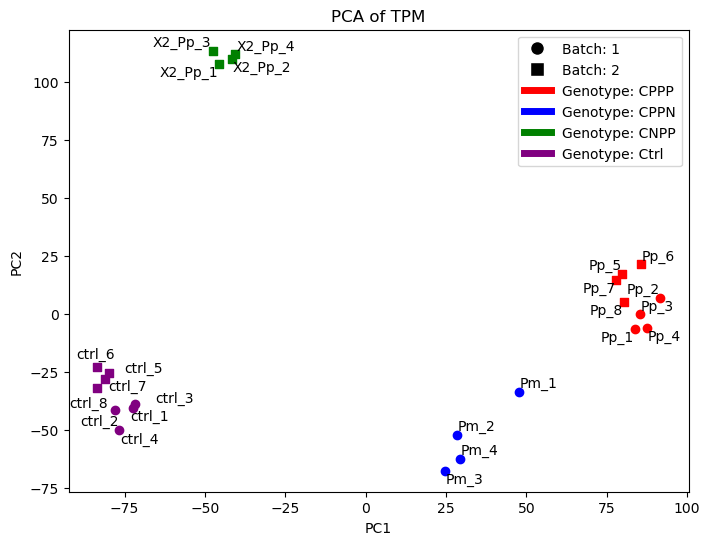

In [65]:
color_map = {'CPPP': 'red', 'CPPN': 'blue', 'CNPP': 'green','Ctrl':"purple"}
marker_map = {'1': 'o', '2': 's'}

plt.figure(figsize=(8, 6))
texts = []

for i in range(len(pca_tpm)):
    genotype = pca_tpm_index.iloc[i]['Genotype']
    batch = pca_tpm_index.iloc[i]['Batch']
    
    plt.scatter(pca_result[i, 0], pca_result[i, 1], color=color_map[genotype], marker=marker_map[batch])
    texts.append(plt.text(pca_result[i, 0], pca_result[i, 1], pca_tpm_index.index[i]))

adjust_text(texts)


legend_elements = [Line2D([0], [0], marker=marker_map[batch], color='w', label='Batch: ' + batch,
                          markerfacecolor='black', markersize=10) for batch in marker_map]
legend_elements += [Line2D([0], [0], color=color_map[genotype], lw=5, label='Genotype: ' + genotype) for genotype in color_map]

plt.legend(handles=legend_elements)
plt.title('PCA of TPM')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


## Merged datas

In [66]:
scaled_tpm_me = scaler.fit_transform(tpm_me)

In [67]:
pca = PCA(n_components=2) 
pca_result_me = pca.fit_transform(scaled_tpm_me)

In [68]:
pca_tpm_me = pd.DataFrame(data=pca_result_me, columns=['PC1', 'PC2'])
pca_tpm_index_me=pca_tpm_me
pca_tpm_index_me.index = merged_df_1.index
pca_tpm_index_me["Genotype"]=metadata["Genotype"]
pca_tpm_index_me["Batch"]=metadata["Batch"]
pca_tpm_index_me["Batch"]= pca_tpm_index_me["Batch"].astype(str)

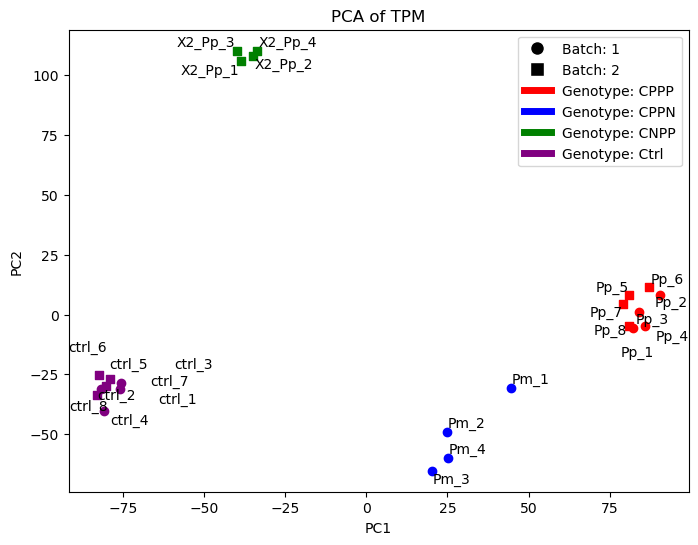

In [69]:
color_map = {'CPPP': 'red', 'CPPN': 'blue', 'CNPP': 'green','Ctrl':"purple"}
marker_map = {'1': 'o', '2': 's'}

plt.figure(figsize=(8, 6))
texts = []

for i in range(len(pca_tpm_me)):
    genotype = pca_tpm_index_me.iloc[i]['Genotype']
    batch = pca_tpm_index_me.iloc[i]['Batch']
    
    plt.scatter(pca_result_me[i, 0], pca_result_me[i, 1], color=color_map[genotype], marker=marker_map[batch])
    texts.append(plt.text(pca_result_me[i, 0], pca_result_me[i, 1], pca_tpm_index_me.index[i]))

adjust_text(texts)


legend_elements = [Line2D([0], [0], marker=marker_map[batch], color='w', label='Batch: ' + batch,
                          markerfacecolor='black', markersize=10) for batch in marker_map]
legend_elements += [Line2D([0], [0], color=color_map[genotype], lw=5, label='Genotype: ' + genotype) for genotype in color_map]

plt.legend(handles=legend_elements)
plt.title('PCA of TPM')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


# Data Preprocess - Check low counts

In [70]:
combo_df_4 = combo_df_1.copy()

In [71]:
column_sums = combo_df_4.sum()
combo_df_4.loc['sum'] = column_sums

In [72]:
combo_df_4

ensembl,ENSMUSG00000033845,ENSMUSG00000025903,ENSMUSG00000033813,ENSMUSG00000062588,ENSMUSG00000002459,ENSMUSG00000033793,ENSMUSG00000025907,ENSMUSG00000090031,ENSMUSG00000051285,ENSMUSG00000103509,...,ENSMUSG00000075268,ENSMUSG00000078528,ENSMUSG00000024810,ENSMUSG00000090369,ENSMUSG00000118217,ENSMUSG00000051984,ENSMUSG00000118210,ENSMUSG00000064344,ENSMUSG00000064357,ENSMUSG00000064372
ctrl_1,2484.0,1044.0,2810.0,21.0,54.0,2476.0,2275.0,18.0,820.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ctrl_2,2021.0,991.0,2327.0,11.0,49.0,2004.0,1847.0,16.0,661.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ctrl_3,2681.0,1151.0,2991.0,27.0,48.0,2647.0,2403.0,30.0,872.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ctrl_4,2452.0,1244.0,3009.0,24.0,73.0,2583.0,2330.0,20.0,841.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pp_1,2418.0,1364.0,2810.0,14.0,109.0,2153.0,2369.0,21.0,870.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pp_2,2261.0,1329.0,2561.0,21.0,87.0,2027.0,2201.0,20.0,893.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pp_3,2180.0,1195.0,2509.0,20.0,109.0,1867.0,2073.0,7.0,846.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pp_4,2493.0,1243.0,2698.0,18.0,105.0,1941.0,2194.0,13.0,899.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pm_1,2862.0,1141.0,2770.0,26.0,86.0,2762.0,2215.0,21.0,907.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pm_2,2452.0,1200.0,2887.0,17.0,60.0,2512.0,2287.0,17.0,882.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
low_count_columns = [column for column in  combo_df_4.columns if combo_df_4[column]['sum'] < 24]

if low_count_columns:
    for column in low_count_columns:
        print(column)
else:
    print("no low count")

no low count


# Multifactor analysis - combo_df_1 (all the datas)

In [74]:
metadata = metadata.reindex(combo_df_1.index)

In [75]:
inference = DefaultInference(n_cpus=8)
dds_ma = DeseqDataSet(
    counts=combo_df_1,
    metadata=metadata,
    design_factors=['Batch','Genotype'],
    refit_cooks=True,
    inference=inference,
)

In [76]:
dds_ma.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.51 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 4.39 seconds.

Fitting LFCs...
... done in 1.82 seconds.

Refitting 0 outliers.



In [77]:
dds_ma.deseq2

<bound method DeseqDataSet.deseq2 of AnnData object with n_obs × n_vars = 24 × 13977
    obs: 'Genotype', 'Replicate', 'Batch'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'>

## Ctrl vs CPPN (ctrl vs pm)

In [78]:
stat_res_Ctrl_vs_CPPN = DeseqStats(dds_ma, contrast=["Genotype", "CPPN", "Ctrl"], inference=inference)
stat_res_Ctrl_vs_CPPN.summary()
#CPPN 相比较于 Ctrl 

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPN vs Ctrl
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ensembl                                                                         
ENSMUSG00000033845  2370.355943        0.038692  0.035950  1.076272  0.281806   
ENSMUSG00000025903  1159.267411        0.015713  0.052036  0.301973  0.762673   
ENSMUSG00000033813  2662.413556        0.023848  0.052177  0.457059  0.647629   
ENSMUSG00000062588    20.080322        0.007751  0.284069  0.027284  0.978233   
ENSMUSG00000002459    69.834088        0.428650  0.149198  2.873037  0.004065   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000051984     3.687141       -0.185608  2.092296 -0.088710  0.929312   
ENSMUSG00000118210     3.138419        0.105973  2.107005  0.050295  0.959887   
ENSMUSG00000064344     4.067640       -0.430672  2.077050 -0.207348  0.835738   
ENSMUSG00000064357     5.062002        0.099581  

... done in 0.95 seconds.



In [79]:
stat_res_Ctrl_vs_CPPN_results = stat_res_Ctrl_vs_CPPN.results_df
stat_res_Ctrl_vs_CPPN_results.loc[:,'symbol'] = combo_df_2.loc[:,'symbol']
stat_res_Ctrl_vs_CPPN_results.set_index('symbol',inplace = True)

In [80]:
stat_res_Ctrl_vs_CPPN_results = stat_res_Ctrl_vs_CPPN_results.sort_values(by='padj', ascending=True)

### Volcano plot

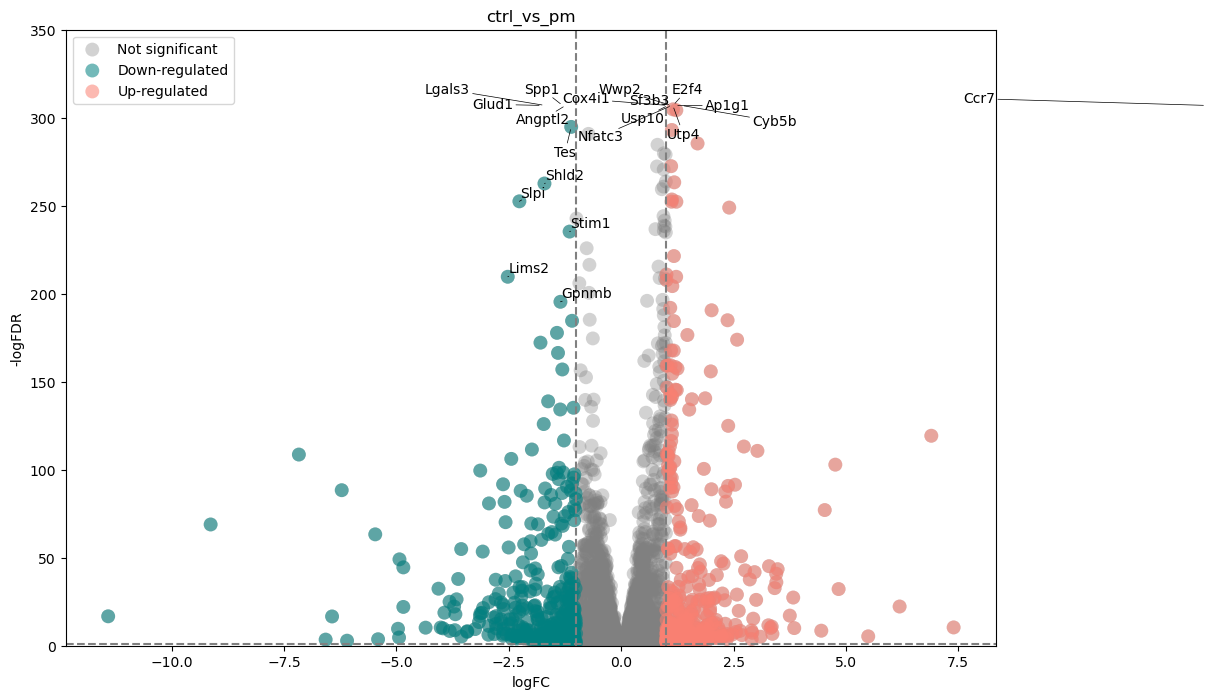

In [81]:
volcano_1(stat_res_Ctrl_vs_CPPN_results,(12,8))
plt.title('ctrl_vs_pm')
plt.show()

### DEG list

In [82]:
not_significaiton_ctrl_vs_CPPN = not_signification(stat_res_Ctrl_vs_CPPN_results)
not_significaiton_ctrl_vs_CPPN

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Mbtps1,12501.773592,0.932770,0.018689,49.908980,0.000000e+00,0.000000e+00
Kars,18083.060800,0.947615,0.020114,47.111648,0.000000e+00,0.000000e+00
BC005537,13267.826107,-0.729307,0.019891,-36.664345,2.703617e-294,1.453402e-291
Mapk6,9631.393644,0.806551,0.022237,36.270991,4.639156e-288,2.315767e-285
Slc7a6,5531.222535,0.947745,0.026354,35.962122,3.272127e-283,1.577052e-280
...,...,...,...,...,...,...
Gm42664,45.760429,0.000212,0.221116,0.000961,9.992333e-01,9.995193e-01
Cox7b,3847.050477,-0.000018,0.045361,-0.000393,9.996863e-01,9.997866e-01
Hltf,2604.026408,0.000011,0.031269,0.000357,9.997151e-01,9.997866e-01


In [83]:
filter_Ctrl_vs_CPPN = filter(stat_res_Ctrl_vs_CPPN_results)
filter_Ctrl_vs_CPPN

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
E2f4,4609.270011,1.155441,0.030330,38.095227,0.000000,0.000000
Lgals3,6444.408255,-1.700991,0.035465,-47.962002,0.000000,0.000000
Ccr7,43630.146479,13.010829,0.167152,77.838240,0.000000,0.000000
Wwp2,4016.959576,1.111879,0.024974,44.522051,0.000000,0.000000
Nfatc3,8408.702273,1.128781,0.028546,39.542153,0.000000,0.000000
...,...,...,...,...,...,...
Npas3,4.823545,1.014611,0.434546,2.334874,0.019550,0.039125
Lama3,8.321981,-1.007516,0.432157,-2.331367,0.019734,0.039454
Pcdhb20,3.849265,1.307531,0.561000,2.330715,0.019768,0.039506


filter_test = filter_Ctrl_vs_CPPN.copy()

filter_test= filter_test[filter_test.index.notnull()]

index_list_1 = filter_test.index.tolist()

In [84]:
up_Ctrl_vs_CPPN = up_reg(stat_res_Ctrl_vs_CPPN_results)
up_Ctrl_vs_CPPN

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
E2f4,4609.270011,1.155441,0.030330,38.095227,0.000000,0.000000
Ddx19a,2668.669284,1.371668,0.028249,48.555770,0.000000,0.000000
Aars,24900.839941,1.088132,0.023320,46.661076,0.000000,0.000000
Zc3h18,5966.795600,1.154517,0.023005,50.185657,0.000000,0.000000
Rfwd3,3999.674646,1.052571,0.025359,41.506172,0.000000,0.000000
...,...,...,...,...,...,...
Tnfsf13os,3.238644,1.605788,0.683030,2.350977,0.018724,0.037634
Npas3,4.823545,1.014611,0.434546,2.334874,0.019550,0.039125
Pcdhb20,3.849265,1.307531,0.561000,2.330715,0.019768,0.039506


In [85]:
save(up_Ctrl_vs_CPPN,'Up_Ctrl_vs_CPPN')

In [86]:
down_Ctrl_vs_CPPN = down_reg(stat_res_Ctrl_vs_CPPN_results)
down_Ctrl_vs_CPPN

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Lgals3,6444.408255,-1.700991,0.035465,-47.962002,0.000000e+00,0.000000e+00
Glud1,20107.341279,-1.765098,0.023127,-76.321750,0.000000e+00,0.000000e+00
Angptl2,6400.913699,-1.237015,0.027820,-44.465202,0.000000e+00,0.000000e+00
Spp1,3398.813263,-1.306896,0.031017,-42.134440,0.000000e+00,0.000000e+00
Tes,2745.983014,-1.113445,0.030164,-36.913563,2.800229e-298,1.630783e-295
...,...,...,...,...,...,...
Sema3a,11.845829,-1.028241,0.392325,-2.620890,8.770054e-03,1.906361e-02
H2-T10,8.838740,-1.279549,0.495031,-2.584786,9.743955e-03,2.096863e-02
Gm3336,8.708421,-1.085892,0.440158,-2.467053,1.362303e-02,2.833047e-02


In [87]:
save(down_Ctrl_vs_CPPN,'Down_Ctrl_vs_CPPN')

### GSEA

gp.get_library_name()

In [88]:
gsea(up_Ctrl_vs_CPPN)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Regulation Of DNA-...,0.000000,0.627683,1.572110
1,GO_Biological_Process_2023__Regulation Of Tran...,0.030151,0.583072,1.416612


In [89]:
gsea(down_Ctrl_vs_CPPN)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Positive Regulatio...,0.288024,-0.522157,-1.449327
1,GO_Biological_Process_2023__Positive Regulatio...,0.405290,-0.455425,-1.271658
2,GO_Biological_Process_2023__Positive Regulatio...,0.445751,-0.518194,-1.339081
3,GO_Biological_Process_2023__Regulation Of DNA-...,0.473181,-0.516318,-1.484245
4,GO_Biological_Process_2023__Negative Regulatio...,0.498898,-0.483505,-1.275156
5,GO_Biological_Process_2023__Positive Regulatio...,0.546902,-0.459673,-1.188555
6,GO_Biological_Process_2023__Regulation Of Cell...,0.559589,-0.397535,-1.065535
7,GO_Biological_Process_2023__Cellular Response ...,0.565760,-0.433589,-1.088113
8,GO_Biological_Process_2023__Regulation Of Tran...,0.597906,-0.379619,-1.108735
9,GO_Biological_Process_2023__Regulation Of Cell...,0.633358,-0.416917,-1.123331


In [90]:
gsea(filter_Ctrl_vs_CPPN)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Regulation Of Gene...,0.000000,0.627862,2.039449
1,GO_Biological_Process_2023__Proteolysis (GO:00...,0.120863,-0.589804,-1.813381
2,GO_Biological_Process_2023__Cellular Response ...,0.189928,-0.569399,-1.675007
3,GO_Biological_Process_2023__Defense Response T...,0.202878,-0.506251,-1.586217
4,GO_Biological_Process_2023__Negative Regulatio...,0.264748,-0.518185,-1.595989
5,GO_Biological_Process_2023__Regulation Of DNA-...,0.267220,0.376129,1.468237
6,GO_Biological_Process_2023__Negative Regulatio...,0.305479,-0.377730,-1.278504
7,GO_Biological_Process_2023__Positive Regulatio...,0.315108,-0.421742,-1.288202
8,GO_Biological_Process_2023__Positive Regulatio...,0.329209,-0.384948,-1.221776
9,GO_Biological_Process_2023__Positive Regulatio...,0.339045,-0.318901,-1.291055


### MsigDb Hallmark

In [91]:
hallmark_enrichment(filter_Ctrl_vs_CPPN)

2024-03-05 10:15:41,263 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:41,266 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:41,270 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:41,286 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:41,803 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
26,HALLMARK_INTERFERON_GAMMA_RESPONSE,5.916001e-07,0.000028,Ifih1;Gbp3;Ccl7;Cd274;Pnp;Casp4;Usp18;Cmklr1;D...
24,HALLMARK_INFLAMMATORY_RESPONSE,4.982892e-06,0.000086,Ccr7;Rnf144b;Serpine1;Ccl7;Nod2;Best1;Osmr;Cmk...
28,HALLMARK_KRAS_SIGNALING_UP,5.465872e-06,0.000086,Plau;Prrx1;Prdm1;Birc3;Cmklr1;Plat;Plek2;Il2rg...
1,HALLMARK_ALLOGRAFT_REJECTION,2.664680e-04,0.003131,Hcls1;Ccl7;Il27ra;Ly75;Ncf4;Il2rg;Tlr2;Cd80;Ir...
25,HALLMARK_INTERFERON_ALPHA_RESPONSE,4.517191e-04,0.004246,Ifih1;Gbp3;Rtp4;Irf7;Gmpr;Dhx58;Ddx60;Isg15;Cm...
31,HALLMARK_MYOGENESIS,2.709498e-03,0.021224,Myh3;Actn3;Mylk;Sod3;Ckmt2;Gnao1;Vipr1;Col15a1...
6,HALLMARK_APOPTOSIS,9.328297e-03,0.060501,Mmp2;Plat;Tgfb2;Pmaip1;Rnasel;Ereg;Bmf;Cd69;Ca...
27,HALLMARK_KRAS_SIGNALING_DN,1.051377e-02,0.060501,Kcnmb1;Camk1d;Nos1;Tgfb2;Fgfr3;Hc;Selenop;Cntf...
41,HALLMARK_TNFA_SIGNALING_VIA_NFKB,1.158531e-02,0.060501,Nfat5;Ifih1;Slc2a6;Serpine1;Lif;Plau;Areg;Tnfa...
23,HALLMARK_IL6_JAK_STAT3_SIGNALING,1.918872e-02,0.090187,Acvrl1;Ccl7;Il2rg;Cntfr;Tnf;Tlr2;Osmr;Irf9;Itgb3


In [92]:
hallmark_enrichment(up_Ctrl_vs_CPPN) 

2024-03-05 10:15:41,817 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:41,819 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:41,823 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:41,836 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:42,094 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
26,HALLMARK_KRAS_SIGNALING_DN,0.017637,0.282564,Camk1d;Nos1;Ryr1;Lgals7;Chrng;Tcf7l1;Cd80;Ccdc106
27,HALLMARK_KRAS_SIGNALING_UP,0.019714,0.282564,Cmklr1;Tmem176a;Il2rg;Ephb2;Trib2;Gprc5b;Tmem1...
30,HALLMARK_MYOGENESIS,0.006690,0.282564,Ncam1;Nos1;Vipr1;Mylk;Col6a3;Ryr1;Col3a1;Chrng...
1,HALLMARK_ALLOGRAFT_REJECTION,0.046209,0.496743,Fgr;Hcls1;Il2rg;Cd79a;Aars;Cd80;Il16


In [93]:
hallmark_enrichment(down_Ctrl_vs_CPPN)

2024-03-05 10:15:42,104 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:42,106 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:42,110 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:42,120 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:42,367 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
25,HALLMARK_INTERFERON_GAMMA_RESPONSE,1.946041e-10,8.367975e-09,Ifih1;Gbp3;Ccl7;Cd274;Pnp;Casp4;Usp18;Dhx58;Dd...
23,HALLMARK_INFLAMMATORY_RESPONSE,1.475695e-06,3.172745e-05,Rnf144b;Serpine1;Ccl7;Nod2;Osmr;Sgms2;P2rx7;Tn...
24,HALLMARK_INTERFERON_ALPHA_RESPONSE,2.243970e-05,3.216357e-04,Ifih1;Gbp3;Rtp4;Irf7;Dhx58;Ddx60;Isg15;Cmpk2;C...
27,HALLMARK_KRAS_SIGNALING_UP,8.749977e-05,9.406225e-04,Plat;Ace;Tph1;Plek2;Lif;Gpnmb;Ereg;Plau;Prrx1;...
6,HALLMARK_APOPTOSIS,1.116170e-03,9.599063e-03,Mmp2;Plat;Tgfb2;Pmaip1;Rnasel;Ereg;Cd69;Casp4;...
1,HALLMARK_ALLOGRAFT_REJECTION,1.936673e-03,1.387949e-02,Stab1;Il11;Il27ra;Tgfb2;Irf7;Lif;Ccl7;Ncf4;Ere...
37,HALLMARK_TNFA_SIGNALING_VIA_NFKB,2.352049e-03,1.444830e-02,Slc2a6;Ifih1;Serpine1;Lif;Areg;Plau;Tnfaip6;Cd...
22,HALLMARK_IL6_JAK_STAT3_SIGNALING,4.075644e-03,2.190659e-02,Acvrl1;Ccl7;Cntfr;Tnf;Osmr;Tlr2;Irf9;Itgb3
13,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,1.458099e-02,6.966471e-02,Mmp2;Serpine1;Pfn2;Areg;Lama3;Prrx1;Crlf1;Eno2...
10,HALLMARK_COMPLEMENT,2.479080e-02,1.066004e-01,Hnf4a;Plat;Irf7;Serpine1;F5;Casp4;Pla2g4a;Lipa...


## Ctrl vs CNPP (ctrl vs x2 pp)

In [94]:
stat_res_Ctrl_vs_CNPP = DeseqStats(dds_ma, contrast=["Genotype", "CNPP", "Ctrl"], inference=inference)
stat_res_Ctrl_vs_CNPP.summary()
# CNPP 相比较与 Ctrl

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CNPP vs Ctrl
                       baseMean  log2FoldChange     lfcSE      stat  \
ensembl                                                               
ENSMUSG00000033845  2370.355943       -0.181577  0.036105 -5.029088   
ENSMUSG00000025903  1159.267411       -0.255527  0.052315 -4.884435   
ENSMUSG00000033813  2662.413556       -0.208039  0.052398 -3.970325   
ENSMUSG00000062588    20.080322       -0.269453  0.278988 -0.965820   
ENSMUSG00000002459    69.834088       -0.020646  0.161068 -0.128181   
...                         ...             ...       ...       ...   
ENSMUSG00000051984     3.687141       -0.909702  0.558004 -1.630280   
ENSMUSG00000118210     3.138419        0.650691  0.580558  1.120804   
ENSMUSG00000064344     4.067640        0.720682  0.507718  1.419454   
ENSMUSG00000064357     5.062002        0.359572  0.463975  0.774981   
ENSMUSG00000064372     4.238548        0.821508  0.485063  1.693612   

                

... done in 1.16 seconds.



In [95]:
stat_res_Ctrl_vs_CNPP_results = stat_res_Ctrl_vs_CNPP.results_df
stat_res_Ctrl_vs_CNPP_results.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
stat_res_Ctrl_vs_CNPP_results.set_index('symbol',inplace = True)

In [96]:
stat_res_Ctrl_vs_CNPP_results = stat_res_Ctrl_vs_CNPP_results.sort_values(by='padj', ascending=True)

volcano_1_FDR(stat_res_Ctrl_vs_CNPP_results)

volcano_1_FC(stat_res_Ctrl_vs_CNPP_results)

### Valcano plot

Text(0.5, 1.0, 'ctrl_vs_x2pp')

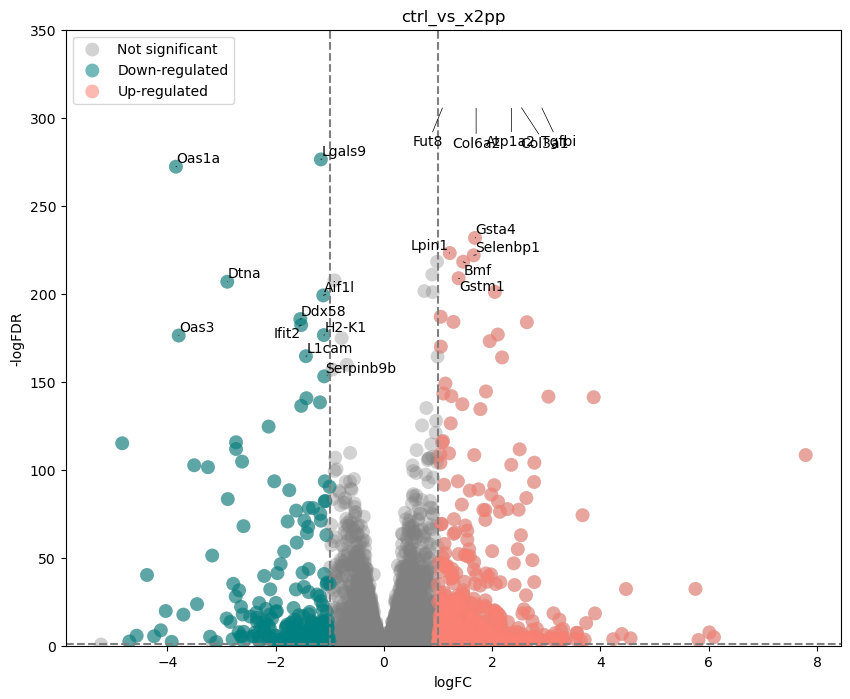

In [97]:
volcano_1(stat_res_Ctrl_vs_CNPP_results,(10,8))
plt.title('ctrl_vs_x2pp')

### DEG list

In [98]:
not_significaiton_Ctrl_vs_CNPP = not_signification(stat_res_Ctrl_vs_CNPP_results)
not_significaiton_Ctrl_vs_CNPP

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Col18a1,8378.533864,0.883751,0.021927,40.303749,0.000000e+00,0.000000e+00
Col6a1,12266.956056,0.982207,0.030880,31.807639,5.075588e-222,5.911791e-219
Egln3,4453.064062,0.892281,0.028537,31.267316,1.298628e-214,1.296494e-211
Atp6v1b2,5752.570624,-0.914034,0.029465,-31.021166,2.794279e-211,2.440977e-208
Bcl2l11,3324.408491,0.745868,0.024406,30.561234,4.010137e-205,3.113872e-202
...,...,...,...,...,...,...
Apol8,6.636604,-0.000334,0.511600,-0.000653,9.994790e-01,9.996936e-01
Gm41341,15.086829,0.000208,0.306035,0.000681,9.994570e-01,9.996936e-01
Abi2,1800.421996,0.000019,0.044299,0.000437,9.996513e-01,9.997944e-01


In [99]:
filter_Ctrl_vs_CNPP = filter(stat_res_Ctrl_vs_CNPP_results)
filter_Ctrl_vs_CNPP

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Fut8,3709.027395,1.099551,0.023592,46.606013,0.000000,0.000000
Atp1a2,1482.589939,2.353334,0.046250,50.883087,0.000000,0.000000
Tgfbi,856.449624,2.894028,0.048216,60.021664,0.000000,0.000000
Col3a1,535.546005,2.512448,0.065080,38.605361,0.000000,0.000000
Col6a2,4415.496631,1.702481,0.035692,47.699557,0.000000,0.000000
...,...,...,...,...,...,...
Nyx,5.732639,-1.152212,0.507304,-2.271245,0.023132,0.043456
Tmem144,16.145201,-1.519622,0.671770,-2.262118,0.023690,0.044386
NaN,4.288303,1.176068,0.528631,2.224741,0.026099,0.048463


In [100]:
up_Ctrl_vs_CNPP = up_reg(stat_res_Ctrl_vs_CNPP_results)
up_Ctrl_vs_CNPP

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Fut8,3709.027395,1.099551,0.023592,46.606013,0.000000,0.000000
Atp1a2,1482.589939,2.353334,0.046250,50.883087,0.000000,0.000000
Tgfbi,856.449624,2.894028,0.048216,60.021664,0.000000,0.000000
Col3a1,535.546005,2.512448,0.065080,38.605361,0.000000,0.000000
Col6a2,4415.496631,1.702481,0.035692,47.699557,0.000000,0.000000
...,...,...,...,...,...,...
Vpreb3,8.274635,1.060966,0.461909,2.296916,0.021624,0.040953
NaN,4.134022,1.087237,0.473369,2.296806,0.021630,0.040959
NaN,4.644190,1.023320,0.448365,2.282336,0.022470,0.042320


In [101]:
save(up_Ctrl_vs_CNPP,'Up_Ctrl_vs_CNPP')

In [102]:
down_Ctrl_vs_CNPP = down_reg(stat_res_Ctrl_vs_CNPP_results)
down_Ctrl_vs_CNPP

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Lgals9,3763.312047,-1.164816,0.032557,-35.777530,2.469704e-280,4.931292e-277
Oas1a,402.763145,-3.842543,0.108216,-35.508194,3.673778e-276,6.418549e-273
Dtna,404.160821,-2.894111,0.093480,-30.959758,1.877705e-210,1.543805e-207
Aif1l,1375.869509,-1.120687,0.036901,-30.369915,1.371603e-202,9.128999e-200
Ddx58,1539.184530,-1.545021,0.052674,-29.331609,4.101387e-189,2.492395e-186
...,...,...,...,...,...,...
Dyrk4,6.121991,-1.164095,0.499056,-2.332596,1.966938e-02,3.769628e-02
NaN,3.525715,-1.397609,0.607937,-2.298937,2.150849e-02,4.075155e-02
Nyx,5.732639,-1.152212,0.507304,-2.271245,2.313214e-02,4.345597e-02


In [103]:
save(down_Ctrl_vs_CNPP,'Down_Ctrl_vs_CNPP')

### GSEA

In [104]:
gsea(down_Ctrl_vs_CNPP)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Defense Response T...,0.0,-0.699734,-1.783427
1,GO_Biological_Process_2023__Defense Response T...,0.0,-0.685171,-1.809688


In [105]:
gsea(up_Ctrl_vs_CNPP)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Positive Regulatio...,0.222385,0.551970,1.371859
1,GO_Biological_Process_2023__Regulation Of Apop...,0.251466,0.507719,1.294627
2,GO_Biological_Process_2023__Positive Regulatio...,0.261730,0.538399,1.390233
3,GO_Biological_Process_2023__Regulation Of Tran...,0.390029,0.510575,1.422770
4,GO_Biological_Process_2023__Regulation Of Cell...,0.509091,0.415861,1.101387
5,GO_Biological_Process_2023__Regulation Of DNA-...,0.550831,0.369897,1.001949
6,GO_Biological_Process_2023__Regulation Of Gene...,0.579179,0.347967,0.934093


In [106]:
gsea(filter_Ctrl_vs_CNPP)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Defense Response T...,0.000000,-0.847971,-2.683365
1,GO_Biological_Process_2023__Defense Response T...,0.000000,-0.789791,-2.861812
2,GO_Biological_Process_2023__Positive Regulatio...,0.351752,0.530528,1.412312
3,GO_Biological_Process_2023__Positive Regulatio...,0.363881,0.556538,1.451335
4,GO_Biological_Process_2023__Regulation Of Cell...,0.367925,0.415564,1.340883
5,GO_Biological_Process_2023__Regulation Of Tran...,0.391606,0.359193,1.297675
6,GO_Biological_Process_2023__Negative Regulatio...,0.413915,0.421956,1.260118
7,GO_Biological_Process_2023__Regulation Of Apop...,0.434232,0.425452,1.343640
8,GO_Biological_Process_2023__Positive Regulatio...,0.464286,-0.298737,-0.996437
9,GO_Biological_Process_2023__Positive Regulatio...,0.469407,0.341806,1.180471


### MsigDb Hallmark

In [107]:
hallmark_enrichment(filter_Ctrl_vs_CNPP)

2024-03-05 10:15:45,310 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:45,312 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:45,315 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:45,327 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:45,571 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
23,HALLMARK_INTERFERON_ALPHA_RESPONSE,1.976237e-16,8.300196e-15,Ifih1;Bst2;Gbp3;Gmpr;Trim21;Parp9;Parp14;Batf2...
24,HALLMARK_INTERFERON_GAMMA_RESPONSE,1.077535e-12,2.262824e-11,Ifih1;Bst2;Gbp3;Trim21;Cd274;Parp14;Batf2;Usp1...
26,HALLMARK_KRAS_SIGNALING_UP,3.137747e-03,4.392845e-02,Lcp1;Cmklr1;Tmem176a;Ace;Ppp1r15a;Cxcl10;Hkdc1...
4,HALLMARK_APICAL_JUNCTION,7.995885e-03,6.716544e-02,Mmp2;Lamb3;Nrxn2;Cdsn;Myl9;Rac2;Actg2;Cldn9;Co...
29,HALLMARK_MYOGENESIS,7.995885e-03,6.716544e-02,Myom2;Ncam1;Col6a2;Nos1;Fxyd1;Vipr1;Lpin1;Col1...
12,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,1.473567e-02,1.031497e-01,Mmp2;Col6a2;Myl9;Lrrc15;Col1a1;Mylk;Nnmt;Col6a...
5,HALLMARK_APICAL_SURFACE,2.446052e-02,1.467631e-01,Rtn4rl1;Mdga1;Slc2a4;Il2rg;Cx3cl1
17,HALLMARK_HEDGEHOG_SIGNALING,4.602176e-02,2.416143e-01,Adgrg1;Nrcam;L1cam;Slit1


In [108]:
hallmark_enrichment(up_Ctrl_vs_CNPP)

2024-03-05 10:15:45,583 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:45,584 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:45,588 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:45,597 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:45,833 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
28,HALLMARK_MYOGENESIS,0.000512,0.020478,Col6a2;Ncam1;Nos1;Fxyd1;Vipr1;Lpin1;Col1a1;Myl...
25,HALLMARK_KRAS_SIGNALING_UP,0.001643,0.032861,Cmklr1;Tmem176a;Ace;Cxcl10;Il2rg;Trib2;Gng11;P...
5,HALLMARK_APICAL_SURFACE,0.003014,0.040182,Rtn4rl1;Mdga1;Slc2a4;Il2rg;Cx3cl1
4,HALLMARK_APICAL_JUNCTION,0.005252,0.042013,Nrxn2;Myl9;Rac2;Actg2;Cldn9;Col9a1;Pecam1;Jup;...
11,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.004331,0.042013,Col6a2;Myl9;Lrrc15;Col1a1;Mylk;Col6a3;Col3a1;T...
3,HALLMARK_ANGIOGENESIS,0.047952,0.274013,Jag2;Col3a1;S100a4
37,HALLMARK_UV_RESPONSE_DN,0.045305,0.274013,Atp2b4;Celf2;Col1a1;Prkar2b;Col3a1;Pmp22;Cdon


In [109]:
hallmark_enrichment(down_Ctrl_vs_CNPP)

2024-03-05 10:15:45,843 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:45,845 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:45,848 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:45,858 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:46,108 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
18,HALLMARK_INTERFERON_ALPHA_RESPONSE,1.381271e-21,4.281939e-20,Ifih1;Bst2;Gbp3;Trim21;Parp9;Parp14;Usp18;Psmb...
19,HALLMARK_INTERFERON_GAMMA_RESPONSE,1.996080e-19,3.093924e-18,Ifih1;Bst2;Gbp3;Trim21;Cd274;Parp14;Usp18;Psmb...
13,HALLMARK_HEDGEHOG_SIGNALING,1.661358e-02,1.716736e-01,Adgrg1;Nrcam;L1cam


## Ctrl vs CPPP (ctrl vs pp)

In [110]:
stat_res_Ctrl_vs_CPPP = DeseqStats(dds_ma, contrast=["Genotype", "CPPP", "Ctrl"], inference=inference)
stat_res_Ctrl_vs_CPPP.summary()
# CPPP 相比较于 ctrl

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPP vs Ctrl
                       baseMean  log2FoldChange     lfcSE      stat  \
ensembl                                                               
ENSMUSG00000033845  2370.355943       -0.131029  0.027331 -4.794072   
ENSMUSG00000025903  1159.267411        0.105714  0.039062  2.706329   
ENSMUSG00000033813  2662.413556       -0.188774  0.039607 -4.766227   
ENSMUSG00000062588    20.080322        0.059990  0.209401  0.286484   
ENSMUSG00000002459    69.834088        0.817393  0.113023  7.232070   
...                         ...             ...       ...       ...   
ENSMUSG00000051984     3.687141       -0.421756  0.528877 -0.797456   
ENSMUSG00000118210     3.138419        0.161403  0.594696  0.271404   
ENSMUSG00000064344     4.067640       -0.911888  0.578553 -1.576154   
ENSMUSG00000064357     5.062002        0.148619  0.469347  0.316651   
ENSMUSG00000064372     4.238548        0.895217  0.481050  1.860964   

                

... done in 0.96 seconds.



In [111]:
stat_res_Ctrl_vs_CPPP_results = stat_res_Ctrl_vs_CPPP.results_df
stat_res_Ctrl_vs_CPPP_results.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
stat_res_Ctrl_vs_CPPP_results.set_index('symbol',inplace = True)

In [112]:
stat_res_Ctrl_vs_CPPP_results = stat_res_Ctrl_vs_CPPP_results.sort_values(by='padj', ascending=True)

### Volcano plot

Text(0.5, 1.0, 'ctrl_vs_pp')

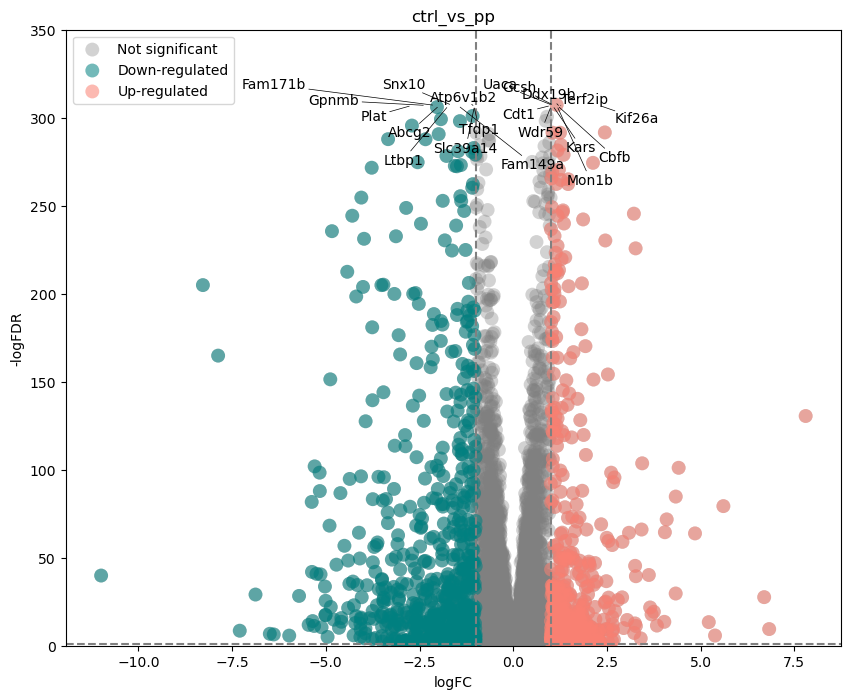

In [113]:
volcano_1(stat_res_Ctrl_vs_CPPP_results,(10,8))
plt.title('ctrl_vs_pp')

volcano_1_FDR(stat_res_Ctrl_vs_CPPP_results)

### DEG list

In [114]:
filter_Ctrl_vs_CPPP = filter(stat_res_Ctrl_vs_CPPP_results)
filter_Ctrl_vs_CPPP

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Ddx19b,3094.390120,1.205121,0.022739,52.998833,0.000000,0.000000
Fam149a,1176.716688,-1.474713,0.030366,-48.565030,0.000000,0.000000
Mon1b,1430.078367,1.160768,0.027256,42.588003,0.000000,0.000000
Uaca,4105.121421,1.055247,0.020061,52.602550,0.000000,0.000000
Fam171b,438.357731,-2.081626,0.053345,-39.021811,0.000000,0.000000
...,...,...,...,...,...,...
NaN,2.485024,1.608202,0.735194,2.187453,0.028709,0.041769
NaN,2.473306,1.398556,0.654986,2.135245,0.032741,0.047265
Ly6g6d,4.340288,1.051019,0.493207,2.130991,0.033090,0.047715


In [115]:
up_Ctrl_vs_CPPP = up_reg(stat_res_Ctrl_vs_CPPP_results)
up_Ctrl_vs_CPPP

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Ddx19b,3094.390120,1.205121,0.022739,52.998833,0.000000,0.000000
Gse1,6212.839014,1.274484,0.027861,45.744579,0.000000,0.000000
Mvd,3258.249792,2.556549,0.045978,55.603297,0.000000,0.000000
6430548M08Rik,1119.052205,1.430772,0.032523,43.992726,0.000000,0.000000
Nup133,6426.075517,1.170941,0.023292,50.271737,0.000000,0.000000
...,...,...,...,...,...,...
NaN,3.531682,1.133398,0.517330,2.190861,0.028462,0.041426
NaN,2.485024,1.608202,0.735194,2.187453,0.028709,0.041769
NaN,2.473306,1.398556,0.654986,2.135245,0.032741,0.047265


In [116]:
save(up_Ctrl_vs_CPPP, 'Up_Ctrl_vs_CPPP')

up_Ctrl_vs_CPPP_0 = up_reg_0(stat_res_Ctrl_vs_CPPP_results)
up_Ctrl_vs_CPPP_0

In [117]:
down_Ctrl_vs_CPPP = down_reg(stat_res_Ctrl_vs_CPPP_results)
down_Ctrl_vs_CPPP

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Fam149a,1176.716688,-1.474713,0.030366,-48.565030,0.000000,0.000000
Oas1a,402.763145,-2.772120,0.062736,-44.186963,0.000000,0.000000
C3,2415.219746,-2.080757,0.037720,-55.162763,0.000000,0.000000
Slpi,627.753090,-3.023862,0.054812,-55.167599,0.000000,0.000000
Stim1,1557.244570,-1.082305,0.025479,-42.478944,0.000000,0.000000
...,...,...,...,...,...,...
Cfap43,4.708745,-1.012821,0.440403,-2.299761,0.021462,0.031797
NaN,5.581852,-1.098608,0.482646,-2.276220,0.022833,0.033689
NaN,3.806703,-1.097753,0.494276,-2.220931,0.026356,0.038569


In [118]:
save(down_Ctrl_vs_CPPP,'Down_Ctrl_vs_CPPP')

### GSEA

In [119]:
gsea(down_Ctrl_vs_CPPP)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Positive Regulatio...,0.273613,-0.590345,-1.516648
1,GO_Biological_Process_2023__Response To Lipopo...,0.315379,-0.560948,-1.445051
2,GO_Biological_Process_2023__Defense Response T...,0.317084,-0.556205,-1.473937
3,GO_Biological_Process_2023__Defense Response T...,0.330722,-0.557610,-1.530664
4,GO_Biological_Process_2023__Negative Regulatio...,0.339733,-0.474106,-1.324825
5,GO_Biological_Process_2023__Positive Regulatio...,0.342087,-0.492388,-1.395780
6,GO_Biological_Process_2023__Positive Regulatio...,0.342314,-0.511074,-1.315781
7,GO_Biological_Process_2023__Negative Regulatio...,0.353395,-0.433163,-1.259321
8,GO_Biological_Process_2023__Positive Regulatio...,0.363505,-0.507412,-1.326368
9,GO_Biological_Process_2023__Positive Regulatio...,0.364391,-0.465815,-1.293966


In [120]:
gsea(up_Ctrl_vs_CPPP)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Negative Regulatio...,0.020202,0.641827,1.491649
1,GO_Biological_Process_2023__Regulation Of Tran...,0.060606,0.579701,1.414684
2,GO_Biological_Process_2023__Regulation Of DNA-...,0.121212,0.523023,1.294068
3,GO_Biological_Process_2023__Regulation Of Cell...,0.459596,0.436446,1.021988


In [121]:
gsea(filter_Ctrl_vs_CPPP)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Positive Regulatio...,0.027483,-0.549413,-1.895885
1,GO_Biological_Process_2023__Positive Regulatio...,0.028857,-0.621415,-1.864853
2,GO_Biological_Process_2023__Defense Response T...,0.032980,-0.580258,-1.846942
3,GO_Biological_Process_2023__Defense Response T...,0.032980,-0.642447,-1.904408
4,GO_Biological_Process_2023__Central Nervous Sy...,0.043973,-0.568389,-1.806281
...,...,...,...,...
70,GO_Biological_Process_2023__Negative Regulatio...,0.853582,-0.220757,-0.731519
71,GO_Biological_Process_2023__Positive Regulatio...,0.857767,0.268677,0.756650
72,GO_Biological_Process_2023__Negative Regulatio...,0.908716,-0.237113,-0.665817
73,GO_Biological_Process_2023__Negative Regulatio...,0.932099,0.380642,1.286402


### MsigDb Hallmark

In [122]:
hallmark_enrichment(filter_Ctrl_vs_CPPP)

2024-03-05 10:15:51,293 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:51,294 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:51,298 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:51,310 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 


,Term,P-value,Adjusted P-value,Genes
24,HALLMARK_INTERFERON_ALPHA_RESPONSE,1.611888e-14,7.737063e-13,Ifih1;Bst2;Gbp3;Gmpr;Oasl1;Parp14;Usp18;Tap1;P...
25,HALLMARK_INTERFERON_GAMMA_RESPONSE,1.398310e-13,3.355944e-12,Ifih1;Bst2;Gbp3;H2-DMa;Ccl7;Cd274;Casp4;Oasl1;...
27,HALLMARK_KRAS_SIGNALING_UP,2.637798e-05,3.505558e-04,Plau;Prrx1;Prdm1;Etv1;Map4k1;Tnfaip3;Birc3;Pla...
31,HALLMARK_MYOGENESIS,2.921298e-05,3.505558e-04,Fabp3;Myh3;Actn3;Mylk;Sod3;Ckmt2;Gnao1;Itga7;M...
23,HALLMARK_INFLAMMATORY_RESPONSE,6.139834e-05,5.894240e-04,Bst2;Ccr7;Rnf144b;Serpine1;Ccl7;Calcrl;Best1;O...
42,HALLMARK_TNFA_SIGNALING_VIA_NFKB,3.319838e-04,2.655871e-03,Lamb3;Ifih1;Serpine1;Ackr3;Plau;Tnfaip3;Birc3;...
8,HALLMARK_CHOLESTEROL_HOMEOSTASIS,4.518320e-04,3.098277e-03,Lss;Aldoc;Atf5;Hsd17b7;Idi1;Stard4;Acat2;Lgals...
1,HALLMARK_ALLOGRAFT_REJECTION,5.464480e-03,2.992379e-02,H2-DMa;Ccl7;Map4k1;Itgal;Tap1;Il27ra;Ly75;Ncf4...
6,HALLMARK_APOPTOSIS,5.610711e-03,2.992379e-02,Rnasel;Casp4;Birc3;Igf2r;Tap1;Plat;Gadd45a;Erb...
10,HALLMARK_COMPLEMENT,6.921001e-03,3.322081e-02,Notch4;Serpine1;F8;Gp9;Casp4;Tnfaip3;Plat;Psmb...


In [123]:
hallmark_enrichment(up_Ctrl_vs_CPPP)

2024-03-05 10:15:51,734 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:51,735 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:51,739 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:51,751 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:51,998 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
8,HALLMARK_CHOLESTEROL_HOMEOSTASIS,4.598092e-07,0.000021,Lss;Aldoc;Hsd17b7;Idi1;Stard4;Acat2;Mvd;Cyp51;...
30,HALLMARK_MYOGENESIS,1.566399e-04,0.003524,Ncam1;Col6a2;Nos1;Nqo1;Mras;Gabarapl2;Vipr1;Lp...
26,HALLMARK_KRAS_SIGNALING_UP,3.783139e-02,0.567471,Tmem176a;Il2rg;Trib2;Scn1b;Etv1;Gprc5b;Tmem176...


In [124]:
hallmark_enrichment(down_Ctrl_vs_CPPP)

2024-03-05 10:15:52,010 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:52,012 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:52,015 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:52,027 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:52,290 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
24,HALLMARK_INTERFERON_GAMMA_RESPONSE,2.716073e-20,1.276555e-18,Ifih1;Bst2;Gbp3;H2-DMa;Ccl7;Cd274;Casp4;Oasl1;...
23,HALLMARK_INTERFERON_ALPHA_RESPONSE,1.680968e-18,3.950275e-17,Ifih1;Bst2;Gbp3;Oasl1;Parp14;Usp18;Tap1;Psmb9;...
22,HALLMARK_INFLAMMATORY_RESPONSE,9.147742e-06,1.433146e-04,Bst2;Rnf144b;Serpine1;Ccl7;Calcrl;Osmr;Sgms2;P...
41,HALLMARK_TNFA_SIGNALING_VIA_NFKB,2.577968e-05,3.029112e-04,Lamb3;Ifih1;Serpine1;Ackr3;Plau;Tnfaip3;Tap1;C...
26,HALLMARK_KRAS_SIGNALING_UP,2.450945e-04,2.303889e-03,Plau;Prrx1;Prdm1;Map4k1;Tnfaip3;Plat;Hkdc1;Hsd...
5,HALLMARK_APOPTOSIS,8.487488e-04,6.648533e-03,Mmp2;Plat;Tgfb2;Pmaip1;Rnasel;Erbb3;Gadd45a;Er...
9,HALLMARK_COMPLEMENT,1.713598e-03,1.150559e-02,Serpine1;Casp4;Tnfaip3;Plat;Psmb9;C1s1;C2;Casp...
1,HALLMARK_ALLOGRAFT_REJECTION,2.639556e-03,1.550739e-02,H2-DMa;Ccl7;Map4k1;Tap1;Il27ra;Ly75;Ncf4;C2;Tl...
8,HALLMARK_COAGULATION,5.900174e-03,3.081202e-02,Pros1;Mmp2;Hnf4a;Plat;Mmp3;Serpine1;Acox2;C1s1...
21,HALLMARK_IL6_JAK_STAT3_SIGNALING,8.515958e-03,4.002500e-02,Acvrl1;Ccl7;Cntfr;Tnf;Osmr;Tlr2;Fas;Irf9;Il7;I...


## CPPN vs CPPP

In [125]:
stat_res_CPPN_vs_CPPP = DeseqStats(dds_ma, contrast=["Genotype", "CPPP", "CPPN"], inference=inference)
stat_res_CPPN_vs_CPPP.summary()
# CPPP (pp) 相比较于 CPPN (pm)

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPP vs CPPN
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ensembl                                                                         
ENSMUSG00000033845  2370.355943       -0.169721  0.035990 -4.715740  0.000002   
ENSMUSG00000025903  1159.267411        0.090000  0.051745  1.739308  0.081981   
ENSMUSG00000033813  2662.413556       -0.212622  0.052237 -4.070325  0.000047   
ENSMUSG00000062588    20.080322        0.052240  0.281698  0.185445  0.852880   
ENSMUSG00000002459    69.834088        0.388743  0.141293  2.751336  0.005935   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000051984     3.687141       -0.236148  2.099800 -0.112462  0.910457   
ENSMUSG00000118210     3.138419        0.055430  2.100028  0.026395  0.978942   
ENSMUSG00000064344     4.067640       -0.481216  2.098807 -0.229281  0.818651   
ENSMUSG00000064357     5.062002        0.049039  

... done in 0.89 seconds.



In [126]:
stat_res_CPPN_vs_CPPP_results = stat_res_CPPN_vs_CPPP.results_df
stat_res_CPPN_vs_CPPP_results.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
stat_res_CPPN_vs_CPPP_results.set_index('symbol',inplace = True)

In [127]:
stat_res_CPPN_vs_CPPP_results = stat_res_CPPN_vs_CPPP_results.sort_values(by='padj', ascending=True)

In [128]:
stat_res_CPPN_vs_CPPP_results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Abcg2,1059.744785,-2.827809,0.053648,-52.710093,0.000000e+00,0.000000e+00
Ly6e,2603.116627,-1.824981,0.044419,-41.085413,0.000000e+00,0.000000e+00
Ifit2,668.718767,-2.358192,0.059296,-39.770123,0.000000e+00,0.000000e+00
Dtna,404.160821,-3.084501,0.088516,-34.846651,4.785205e-266,1.672070e-262
Snx2,4794.963796,-0.716705,0.022861,-31.350170,9.677144e-216,2.705149e-212
...,...,...,...,...,...,...
NaN,3.948155,0.001572,2.087143,0.000753,9.993989e-01,9.996850e-01
Cdk5rap2,2062.837952,0.000015,0.039036,0.000390,9.996885e-01,9.999031e-01
NaN,5.498730,-0.000353,2.111612,-0.000167,9.998668e-01,9.999040e-01


### Volcano plot

Text(0.5, 1.0, 'pm_vs_pp')

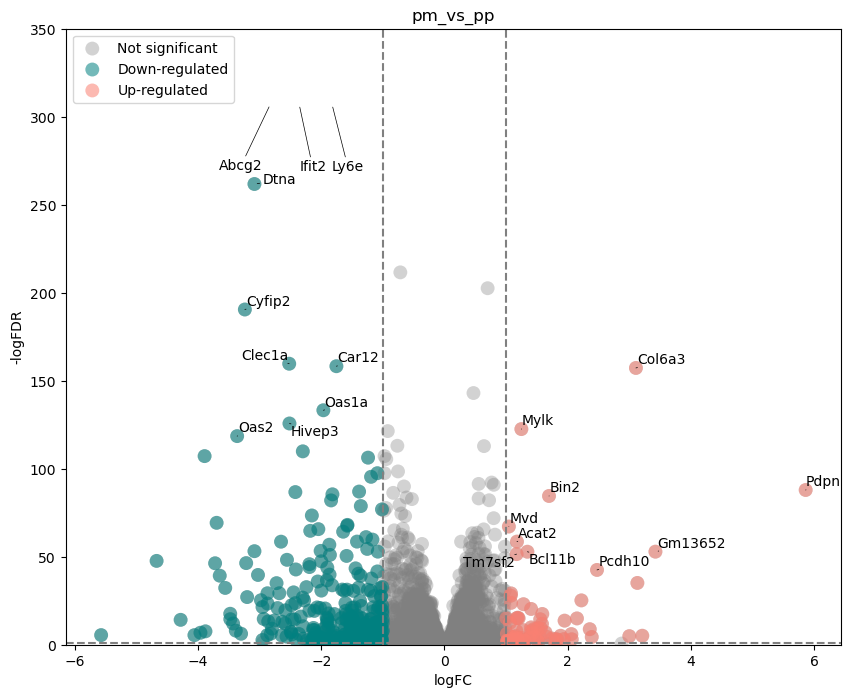

In [129]:
volcano_1(stat_res_CPPN_vs_CPPP_results,(10,8))
plt.title('pm_vs_pp')

### DEG list

In [130]:
filter_CPPPvsCPPN = filter(stat_res_CPPN_vs_CPPP_results)
filter_CPPPvsCPPN

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Abcg2,1059.744785,-2.827809,0.053648,-52.710093,0.000000e+00,0.000000e+00
Ly6e,2603.116627,-1.824981,0.044419,-41.085413,0.000000e+00,0.000000e+00
Ifit2,668.718767,-2.358192,0.059296,-39.770123,0.000000e+00,0.000000e+00
Dtna,404.160821,-3.084501,0.088516,-34.846651,4.785205e-266,1.672070e-262
Cyfip2,219.921843,-3.239959,0.108904,-29.750531,1.706946e-194,3.408284e-191
...,...,...,...,...,...,...
Gm50163,5.618047,-1.175614,0.493216,-2.383567,1.714576e-02,3.934433e-02
Shroom3,8.509028,-1.762971,0.743215,-2.372086,1.768795e-02,4.046227e-02
Gm26558,4.354619,-1.368485,0.580741,-2.356446,1.845073e-02,4.197361e-02


In [131]:
up_CPPPvsCPPN = up_reg(stat_res_CPPN_vs_CPPP_results)
up_CPPPvsCPPN

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Col6a3,1475.136938,3.106811,0.114862,27.048280,4.001588e-161,5.593020e-158
Mylk,632.612244,1.247597,0.052199,23.900979,2.991788e-126,2.986873e-123
Pdpn,370.144888,5.861652,0.289300,20.261514,2.811833e-91,1.228156e-88
Bin2,297.407433,1.696279,0.085393,19.864324,8.285951e-88,3.130074e-85
Mvd,3258.249792,1.044737,0.058947,17.723206,2.776299e-70,7.055333e-68
...,...,...,...,...,...,...
Large2,9.249254,1.139629,0.446455,2.552616,1.069173e-02,2.599380e-02
Frmd4b,12.222070,1.029625,0.404064,2.548171,1.082894e-02,2.629290e-02
AA474408,3.605557,1.522801,0.604215,2.520295,1.172566e-02,2.818392e-02


In [132]:
save(up_CPPPvsCPPN,'Up_CPPPvsCPPN')

In [133]:
down_CPPPvsCPPN = down_reg(stat_res_CPPN_vs_CPPP_results)
down_CPPPvsCPPN

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Abcg2,1059.744785,-2.827809,0.053648,-52.710093,0.000000e+00,0.000000e+00
Ly6e,2603.116627,-1.824981,0.044419,-41.085413,0.000000e+00,0.000000e+00
Ifit2,668.718767,-2.358192,0.059296,-39.770123,0.000000e+00,0.000000e+00
Dtna,404.160821,-3.084501,0.088516,-34.846651,4.785205e-266,1.672070e-262
Cyfip2,219.921843,-3.239959,0.108904,-29.750531,1.706946e-194,3.408284e-191
...,...,...,...,...,...,...
Ric3,7.862272,-1.119357,0.467255,-2.395601,1.659312e-02,3.819534e-02
Gm50163,5.618047,-1.175614,0.493216,-2.383567,1.714576e-02,3.934433e-02
Shroom3,8.509028,-1.762971,0.743215,-2.372086,1.768795e-02,4.046227e-02


In [134]:
save(down_CPPPvsCPPN,'Down_CPPPvsCPPN')

In [135]:
### Filter-S

filter_CPPPvsCPPN_s = filter_s(stat_res_CPPN_vs_CPPP_results)
filter_CPPPvsCPPN_s

up_CPPPvsCPPN_s = up_reg_s(stat_res_CPPN_vs_CPPP_results)
up_CPPPvsCPPN_s

down_CPPPvsCPPN_s = down_reg_s(stat_res_CPPN_vs_CPPP_results)
down_CPPPvsCPPN_s

volcano_1_s(stat_res_CPPN_vs_CPPP_results)
plt.title("CPPN_vs_CPPP_padj<0.01")

### GSEA

In [136]:
gsea(filter_CPPPvsCPPN)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Negative Regulatio...,0.142494,-0.505792,-1.414050
1,GO_Biological_Process_2023__Regulation Of Tran...,0.152672,-0.444395,-1.449952
2,GO_Biological_Process_2023__Regulation Of Cell...,0.175439,0.308530,1.235261
3,GO_Biological_Process_2023__Regulation Of DNA-...,0.183206,-0.508729,-1.597880
4,GO_Biological_Process_2023__Positive Regulatio...,0.183206,-0.499720,-1.489500
5,GO_Biological_Process_2023__Positive Regulatio...,0.254453,-0.458028,-1.250731
6,GO_Biological_Process_2023__Positive Regulatio...,0.299237,-0.473052,-1.259079
7,GO_Biological_Process_2023__Cellular Response ...,0.309706,-0.426859,-1.179631
8,GO_Biological_Process_2023__Regulation Of Gene...,0.354962,-0.417463,-1.103682


In [137]:
gsea(down_CPPPvsCPPN)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Positive Regulatio...,0.149742,-0.497477,-1.465710
1,GO_Biological_Process_2023__Regulation Of Tran...,0.227194,-0.479963,-1.482736
2,GO_Biological_Process_2023__Regulation Of DNA-...,0.230637,-0.454238,-1.332301
3,GO_Biological_Process_2023__Cellular Response ...,0.497418,-0.374137,-0.991515
4,GO_Biological_Process_2023__Positive Regulatio...,0.497762,-0.412183,-1.063910
5,GO_Biological_Process_2023__Regulation Of Gene...,0.570568,-0.413808,-1.089692


gsea(up_CPPPvsCPPN)
#不知道为什么跑不出来

### MsigDb Hallmark

In [138]:
hallmark_enrichment(down_CPPPvsCPPN)

2024-03-05 10:15:54,917 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:54,919 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:54,923 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:54,933 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:55,178 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
22,HALLMARK_INTERFERON_GAMMA_RESPONSE,3.151878e-16,1.229232e-14,Ifih1;Gbp3;Cd274;Casp4;Parp14;Usp18;Cmklr1;Ly6...
21,HALLMARK_INTERFERON_ALPHA_RESPONSE,6.258787e-12,1.220463e-10,Sp110;Ifih1;Trim14;Gbp3;Rtp4;Ifit2;Ifit3;Irf7;...
33,HALLMARK_TNFA_SIGNALING_VIA_NFKB,1.036385e-03,1.347301e-02,Serpinb8;Lamb3;Gem;Ifih1;Ifit2;Plek;Ppp1r15a;C...
4,HALLMARK_APOPTOSIS,6.390589e-03,6.230824e-02,Mmp2;Plcb2;Tgfb2;Ddit3;Pmaip1;Casp4;Casp1;Btg2...
20,HALLMARK_INFLAMMATORY_RESPONSE,9.389950e-03,6.329392e-02,Cmklr1;Scarf1;Rtp4;Irf7;Ly6e;Calcrl;Cd69;Lcp2;...
24,HALLMARK_KRAS_SIGNALING_UP,9.737526e-03,6.329392e-02,Lcp1;Cmklr1;Ppp1r15a;Hkdc1;Ephb2;Prrx1;Ush1c;H...
8,HALLMARK_COMPLEMENT,1.619293e-02,9.021773e-02,Plek;Irf7;F5;C1s1;Casp4;Pla2g4a;Lcp2;Ctso;Casp...


In [139]:
hallmark_enrichment(up_CPPPvsCPPN)

2024-03-05 10:15:55,189 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:15:55,191 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:55,194 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:15:55,201 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:15:55,441 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
3,HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.000177,0.003188,Aldoc;Mvd;Acat2;Tm7sf2
4,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.045041,0.287998,Pfn2;Col6a3;Mylk
13,HALLMARK_MYOGENESIS,0.048000,0.287998,Col6a3;Ryr1;Mylk


## CNPP vs CPPP (x2 pp vs pp)

In [140]:
stat_res_CNPP_vs_CPPP = DeseqStats(dds_ma, contrast=["Genotype", "CPPP", "CNPP"], inference=inference)
stat_res_CNPP_vs_CPPP.summary()
# cppp 相比较于 cnpp 

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPP vs CNPP
                       baseMean  log2FoldChange     lfcSE      stat  \
ensembl                                                               
ENSMUSG00000033845  2370.355943        0.050548  0.036312  1.392030   
ENSMUSG00000025903  1159.267411        0.361241  0.052255  6.913090   
ENSMUSG00000033813  2662.413556        0.019265  0.052571  0.366461   
ENSMUSG00000062588    20.080322        0.329443  0.278953  1.180996   
ENSMUSG00000002459    69.834088        0.838039  0.154551  5.422398   
...                         ...             ...       ...       ...   
ENSMUSG00000051984     3.687141        0.487946  0.575734  0.847521   
ENSMUSG00000118210     3.138419       -0.489288  0.574813 -0.851213   
ENSMUSG00000064344     4.067640       -1.632569  0.564692 -2.891079   
ENSMUSG00000064357     5.062002       -0.210953  0.460385 -0.458209   
ENSMUSG00000064372     4.238548        0.073709  0.441805  0.166837   

                

... done in 0.89 seconds.



In [141]:
stat_res_CNPP_vs_CPPP_results = stat_res_CNPP_vs_CPPP.results_df
stat_res_CNPP_vs_CPPP_results.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
stat_res_CNPP_vs_CPPP_results.set_index('symbol',inplace = True)

In [142]:
stat_res_CNPP_vs_CPPP_results = stat_res_CNPP_vs_CPPP_results.sort_values(by='padj', ascending=True)

In [143]:
stat_res_CNPP_vs_CPPP_results

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Wdr59,2530.941150,1.141349,0.029877,38.201647,0.000000,0.000000
Aars,24900.839941,1.421917,0.023688,60.026272,0.000000,0.000000
Nfatc3,8408.702273,1.453396,0.029245,49.696482,0.000000,0.000000
Rfwd3,3999.674646,1.423711,0.026613,53.497715,0.000000,0.000000
Mlkl,5136.630167,1.642806,0.032416,50.678502,0.000000,0.000000
...,...,...,...,...,...,...
NaN,2.410413,-0.001004,0.697507,-0.001439,0.998852,0.999138
Idh3b,3888.890127,0.000017,0.023993,0.000700,0.999441,0.999656
Plcb3,3447.225514,0.000016,0.027255,0.000599,0.999522,0.999665


### Volcano plot

Text(0.5, 1.0, 'x2pp_vs_pp')

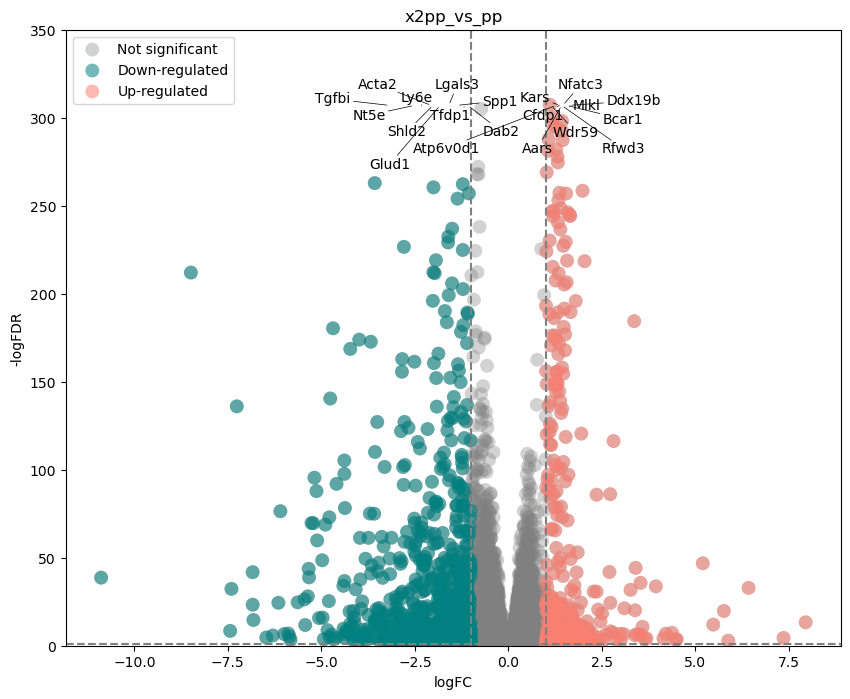

In [144]:
volcano_1(stat_res_CNPP_vs_CPPP_results,(10,8))
plt.title('x2pp_vs_pp')

### DEG list

In [145]:
filter_CNPPvsCPPP = filter(stat_res_CNPP_vs_CPPP_results)
filter_CNPPvsCPPP

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Wdr59,2530.941150,1.141349,0.029877,38.201647,0.000000,0.000000
Aars,24900.839941,1.421917,0.023688,60.026272,0.000000,0.000000
Nfatc3,8408.702273,1.453396,0.029245,49.696482,0.000000,0.000000
Rfwd3,3999.674646,1.423711,0.026613,53.497715,0.000000,0.000000
Mlkl,5136.630167,1.642806,0.032416,50.678502,0.000000,0.000000
...,...,...,...,...,...,...
NaN,3.646000,-1.213620,0.554690,-2.187924,0.028675,0.047532
NaN,2.772086,1.420716,0.650115,2.185330,0.028865,0.047818
NaN,4.096769,-1.195736,0.548123,-2.181509,0.029146,0.048255


In [146]:
up_CPPPvsCNPP = up_reg(stat_res_CNPP_vs_CPPP_results)
up_CPPPvsCNPP

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Wdr59,2530.941150,1.141349,0.029877,38.201647,0.000000,0.000000
Prmt7,4189.235969,1.477297,0.032000,46.165418,0.000000,0.000000
Ist1,4219.671722,1.517513,0.028295,53.632668,0.000000,0.000000
Atxn1l,3800.699710,1.369960,0.033512,40.879083,0.000000,0.000000
Ap1g1,7694.759449,1.503023,0.028227,53.248161,0.000000,0.000000
...,...,...,...,...,...,...
NaN,2.629877,1.579836,0.673066,2.347222,0.018914,0.032497
NaN,3.184676,1.383375,0.617171,2.241476,0.024995,0.041864
NaN,3.000539,1.301570,0.584109,2.228301,0.025860,0.043205


In [147]:
save(up_CPPPvsCNPP,'Up_CPPPvsCNPP')

In [148]:
down_CPPPvsCNPP = down_reg(stat_res_CNPP_vs_CPPP_results)
down_CPPPvsCNPP

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Dab2,3444.610315,-1.086617,0.027629,-39.328941,0.000000,0.000000
Slc39a14,3402.937248,-1.311844,0.028827,-45.507675,0.000000,0.000000
Slpi,627.753090,-2.677221,0.065998,-40.564981,0.000000,0.000000
Gpnmb,9855.324840,-1.797011,0.045305,-39.665062,0.000000,0.000000
Ly6e,2603.116627,-2.316955,0.044028,-52.624786,0.000000,0.000000
...,...,...,...,...,...,...
NaN,3.419865,-1.275765,0.580700,-2.196945,0.028024,0.046525
NaN,3.646000,-1.213620,0.554690,-2.187924,0.028675,0.047532
NaN,4.096769,-1.195736,0.548123,-2.181509,0.029146,0.048255


In [149]:
save(down_CPPPvsCNPP,'Down_CPPPvsCNPP')

In [150]:
### Filter_s

filter_CNPPvsCPPP_s = filter_s(stat_res_CNPP_vs_CPPP_results)
filter_CNPPvsCPPP_s

up_CPPPvsCNPP_s = up_reg_s(stat_res_CNPP_vs_CPPP_results)
up_CPPPvsCNPP_s

down_CPPPvsCNPP_s = down_reg_s(stat_res_CNPP_vs_CPPP_results)
down_CPPPvsCNPP_s

volcano_1_s(stat_res_CNPP_vs_CPPP_results)
plt.title("CNPP_vs_CPPP_padj<0.01")

### GSEA

In [151]:
gsea(filter_CNPPvsCPPP)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Ubiquitin-Dependen...,0.000000,0.716807,2.072864
1,GO_Biological_Process_2023__Protein Ubiquitina...,0.014948,0.638719,1.953906
2,GO_Biological_Process_2023__Negative Regulatio...,0.048152,-0.543248,-1.798645
3,GO_Biological_Process_2023__Regulation Of GTPa...,0.052529,-0.614699,-1.867815
4,GO_Biological_Process_2023__Cellular Response ...,0.058366,-0.607914,-1.818778
...,...,...,...,...
72,GO_Biological_Process_2023__Positive Regulatio...,0.782279,0.301131,0.824669
73,GO_Biological_Process_2023__Regulation Of Cell...,0.812175,0.264517,0.855184
74,GO_Biological_Process_2023__Inorganic Cation T...,0.840791,-0.207711,-0.743833
75,GO_Biological_Process_2023__Supramolecular Fib...,0.935009,0.215082,0.627481


In [152]:
gsea(up_CPPPvsCNPP)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Regulation Of DNA-...,0.040404,0.600768,1.409694
1,GO_Biological_Process_2023__Negative Regulatio...,0.055556,0.587833,1.312803
2,GO_Biological_Process_2023__Regulation Of Tran...,0.225589,0.507419,1.182461
3,GO_Biological_Process_2023__Positive Regulatio...,0.345960,0.503205,1.085228


In [153]:
gsea(down_CPPPvsCNPP)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Positive Regulatio...,0.195094,-0.620703,-1.663076
1,GO_Biological_Process_2023__Negative Regulatio...,0.241301,-0.537015,-1.591022
2,GO_Biological_Process_2023__Negative Regulatio...,0.274672,-0.561752,-1.516576
3,GO_Biological_Process_2023__Positive Regulatio...,0.310097,-0.501184,-1.485641
4,GO_Biological_Process_2023__Negative Regulatio...,0.332002,-0.592716,-1.525744
5,GO_Biological_Process_2023__Negative Regulatio...,0.338848,-0.498826,-1.459611
6,GO_Biological_Process_2023__Transmembrane Rece...,0.414575,-0.463622,-1.237723
7,GO_Biological_Process_2023__Positive Regulatio...,0.415242,-0.416922,-1.229057
8,GO_Biological_Process_2023__Positive Regulatio...,0.416975,-0.463637,-1.245081
9,GO_Biological_Process_2023__Positive Regulatio...,0.427527,-0.435825,-1.247320


### MsigDb Hallmark

In [154]:
hallmark_enrichment(up_CPPPvsCNPP)

2024-03-05 10:16:04,154 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:04,156 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:04,160 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:04,171 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:04,428 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
37,HALLMARK_XENOBIOTIC_METABOLISM,0.005452,0.207189,Cyp2j6;Nqo1;Lcat;Psmb10;Bcar1;Kars;Tmem176b;Sl...


In [155]:
hallmark_enrichment(down_CPPPvsCNPP)

2024-03-05 10:16:04,439 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:04,441 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:04,444 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:04,456 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:04,697 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
25,HALLMARK_INTERFERON_GAMMA_RESPONSE,2.352940e-09,1.082352e-07,Ifih1;Ccl7;Casp4;Tnfaip3;Batf2;Apol6;Cmklr1;Ly...
23,HALLMARK_INFLAMMATORY_RESPONSE,4.982892e-06,1.146065e-04,Serpine1;Ccl7;Calcrl;Nod2;Osmr;Cmklr1;P2rx7;Ly...
24,HALLMARK_INTERFERON_ALPHA_RESPONSE,3.020725e-05,4.631778e-04,Ifih1;Trim14;Ifit2;Rtp4;Ifit3;Rsad2;Ly6e;Cxcl1...
40,HALLMARK_TNFA_SIGNALING_VIA_NFKB,4.448766e-05,5.116081e-04,Ifih1;Serpine1;Ackr3;Egr3;Tnfaip3;Serpinb8;Gem...
12,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,3.078476e-04,2.832198e-03,Serpine1;Prrx1;Tnfaip3;Tgfbi;Matn2;Nt5e;Gem;My...
6,HALLMARK_APOPTOSIS,5.683936e-04,4.357684e-03,Mmp2;Cth;Plat;Tgfb2;Pmaip1;Rnasel;Erbb3;Ereg;T...
10,HALLMARK_COMPLEMENT,1.148678e-03,7.548458e-03,S100a13;Serpine1;Pla2g7;Casp4;Tnfaip3;Plat;C1s...
27,HALLMARK_KRAS_SIGNALING_UP,5.880216e-03,3.381124e-02,Cmklr1;Plat;Ace;Tph1;Btc;Lif;Gpnmb;Cxcl10;Ereg...
22,HALLMARK_IL6_JAK_STAT3_SIGNALING,6.765313e-03,3.457827e-02,Acvrl1;Cxcl10;Ccl7;Cntfr;Tnf;Osmr;Tlr2;Fas;Il7...
9,HALLMARK_COAGULATION,1.096921e-02,4.587125e-02,Pros1;Mmp2;Plat;S100a13;Mmp3;Serpine1;Trf;Lrp1...


# Multifactor analysis - merged_df_1

In [156]:
metadata = metadata.reindex(merged_df_1.index)

In [157]:
inference = DefaultInference(n_cpus=8)
dds_me = DeseqDataSet(
    counts=merged_df_1,
    metadata=metadata,
    design_factors=['Batch','Genotype'],
    refit_cooks=True,
    inference=inference,
)

In [158]:
dds_me.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.95 seconds.

Fitting dispersion trend curve...
... done in 0.38 seconds.

Fitting MAP dispersions...
... done in 4.01 seconds.

Fitting LFCs...
... done in 1.57 seconds.

Refitting 0 outliers.



## Ctrl vs CPPN (ctrl vs pm)

In [159]:
stat_res_Ctrl_vs_CPPN_me = DeseqStats(dds_me, contrast=["Genotype", "CPPN", "Ctrl"], inference=inference)
stat_res_Ctrl_vs_CPPN_me.summary()
#CPPN 相比较于 Ctrl 

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPN vs Ctrl
                       baseMean  log2FoldChange     lfcSE       stat  \
ensembl                                                                
ENSMUSG00000033845  2370.355943        0.038691  0.035975   1.075490   
ENSMUSG00000025903  1159.267411        0.015713  0.052024   0.302025   
ENSMUSG00000033813  2662.413556        0.023841  0.051978   0.458680   
ENSMUSG00000062588    20.080322        0.007687  0.286349   0.026846   
ENSMUSG00000002459    69.834088        0.428846  0.150387   2.851627   
...                         ...             ...       ...        ...   
ENSMUSG00000051412   783.762879        0.082459  0.057604   1.431470   
ENSMUSG00000061654   558.076836       -0.751602  0.058772 -12.788544   
ENSMUSG00000079834   671.147121       -0.100631  0.052283  -1.924735   
ENSMUSG00000095041  5672.196591       -0.568684  0.103545  -5.492122   
ENSMUSG00000063897   537.012771        0.268270  0.059213   4.530558   

   

... done in 0.85 seconds.



In [160]:
stat_res_Ctrl_vs_CPPN_results_me = stat_res_Ctrl_vs_CPPN_me.results_df.copy()
stat_res_Ctrl_vs_CPPN_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol']
stat_res_Ctrl_vs_CPPN_results_me.set_index('symbol',inplace = True)

In [161]:
stat_res_Ctrl_vs_CPPN_results_me = stat_res_Ctrl_vs_CPPN_results_me.sort_values(by='padj', ascending=True)

In [162]:
res_Ctrl_vs_CPPN_results_me=add_DEG_column(stat_res_Ctrl_vs_CPPN_me.results_df)

In [163]:
res_Ctrl_vs_CPPN_results_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,DEG
ensembl,,,,,,,
ENSMUSG00000033845,2370.355943,0.038691,0.035975,1.075490,2.821555e-01,3.707735e-01,0
ENSMUSG00000025903,1159.267411,0.015713,0.052024,0.302025,7.626330e-01,8.165452e-01,0
ENSMUSG00000033813,2662.413556,0.023841,0.051978,0.458680,6.464643e-01,7.182210e-01,0
ENSMUSG00000062588,20.080322,0.007687,0.286349,0.026846,9.785822e-01,9.838025e-01,0
ENSMUSG00000002459,69.834088,0.428846,0.150387,2.851627,4.349606e-03,9.580899e-03,0
...,...,...,...,...,...,...,...
ENSMUSG00000051412,783.762879,0.082459,0.057604,1.431470,1.522956e-01,2.211672e-01,0
ENSMUSG00000061654,558.076836,-0.751602,0.058772,-12.788544,1.899992e-37,3.803444e-36,0
ENSMUSG00000079834,671.147121,-0.100631,0.052283,-1.924735,5.426255e-02,9.060012e-02,0


### Valcano plot

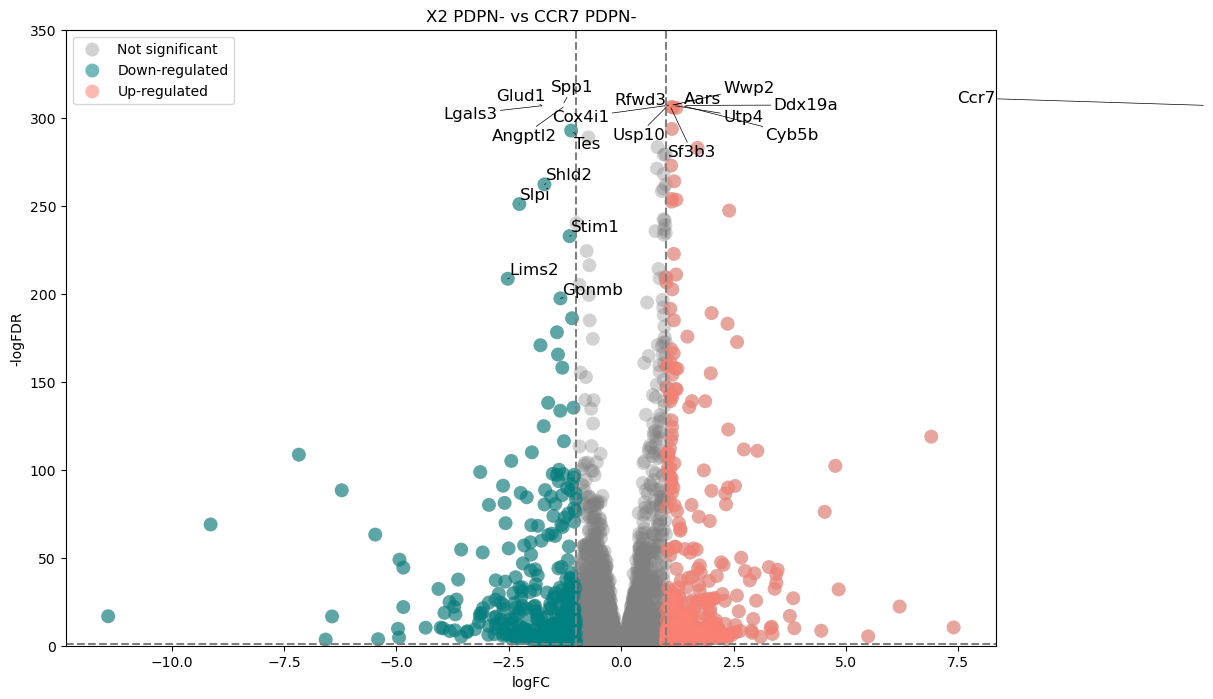

In [483]:
volcano_1(stat_res_Ctrl_vs_CPPN_results_me,(12,8))
plt.title('X2 PDPN- vs CCR7 PDPN-')
plt.show()

### DEG list

In [165]:
not_significaiton_Ctrl_vs_CPPN_me = not_signification(stat_res_Ctrl_vs_CPPN_results_me)
not_significaiton_Ctrl_vs_CPPN_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Mbtps1,12501.773592,0.932773,0.018772,49.689247,0.000000e+00,0.000000e+00
Kars,18083.060800,0.947616,0.020161,47.001928,0.000000e+00,0.000000e+00
BC005537,13267.826107,-0.729307,0.019960,-36.538433,2.722070e-292,1.381136e-289
Mapk6,9631.393644,0.806551,0.022289,36.185790,1.018585e-286,4.976728e-284
Zcchc14,7585.534055,0.986954,0.027480,35.915924,1.723668e-282,7.840905e-280
...,...,...,...,...,...,...
Gm6421,12.165123,0.000574,0.342625,0.001675,9.986637e-01,9.989666e-01
Gm42664,45.760429,0.000270,0.222263,0.001215,9.990308e-01,9.992581e-01
Elp2,5170.738954,0.000021,0.023249,0.000894,9.992871e-01,9.994386e-01


In [166]:
filter_Ctrl_vs_CPPN_me = filter(stat_res_Ctrl_vs_CPPN_results_me)
filter_Ctrl_vs_CPPN_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Glud1,20107.341279,-1.765097,0.023142,-76.273979,0.000000,0.000000
Wwp2,4016.959576,1.111901,0.025093,44.311787,0.000000,0.000000
Cyb5b,19536.320431,1.336240,0.022425,59.587216,0.000000,0.000000
Aars,24900.839941,1.088132,0.023319,46.662295,0.000000,0.000000
Cox4i1,11300.633389,1.030261,0.025752,40.006471,0.000000,0.000000
...,...,...,...,...,...,...
Gm32352,8.712507,1.034480,0.426978,2.422792,0.015402,0.029941
Rslcan18,6.642616,1.198858,0.501882,2.388723,0.016907,0.032574
Lama3,8.321981,-1.007571,0.435563,-2.313260,0.020708,0.039082


In [167]:
up_Ctrl_vs_CPPN_me = up_reg(stat_res_Ctrl_vs_CPPN_results_me)
up_Ctrl_vs_CPPN_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Wwp2,4016.959576,1.111901,0.025093,44.311787,0.000000,0.000000
E2f4,4609.270011,1.155442,0.030335,38.089710,0.000000,0.000000
Nfatc3,8408.702273,1.128780,0.028524,39.572583,0.000000,0.000000
Ap1g1,7694.759449,1.195841,0.027550,43.406525,0.000000,0.000000
Sf3b3,12917.499840,1.079950,0.027978,38.600531,0.000000,0.000000
...,...,...,...,...,...,...
Mfsd2b,8.909923,1.010382,0.406788,2.483806,0.012999,0.025751
Pbx4,8.867314,1.075717,0.435227,2.471620,0.013450,0.026555
Gm32352,8.712507,1.034480,0.426978,2.422792,0.015402,0.029941


In [168]:
up_Ctrl_vs_CPPN_me_s = up_reg_s(stat_res_Ctrl_vs_CPPN_results_me)
up_Ctrl_vs_CPPN_me_s

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Wwp2,4016.959576,1.111901,0.025093,44.311787,0.000000,0.000000
E2f4,4609.270011,1.155442,0.030335,38.089710,0.000000,0.000000
Zc3h18,5966.795600,1.154508,0.023091,49.997229,0.000000,0.000000
Ap1g1,7694.759449,1.195841,0.027550,43.406525,0.000000,0.000000
Sf3b3,12917.499840,1.079950,0.027978,38.600531,0.000000,0.000000
...,...,...,...,...,...,...
2310068J16Rik,10.644782,1.022929,0.355154,2.880242,0.003974,0.008826
Tmem91,7.916331,1.318612,0.460877,2.861096,0.004222,0.009332
Gm33460,10.509913,1.110330,0.390990,2.839792,0.004514,0.009916


In [169]:
save(up_Ctrl_vs_CPPN_me,'Up_Ctrl_vs_CPPN_me')

In [170]:
down_Ctrl_vs_CPPN_me = down_reg(stat_res_Ctrl_vs_CPPN_results_me)
down_Ctrl_vs_CPPN_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Glud1,20107.341279,-1.765097,0.023142,-76.273979,0.000000e+00,0.000000e+00
Spp1,3398.813263,-1.306872,0.031092,-42.031791,0.000000e+00,0.000000e+00
Angptl2,6400.913699,-1.237015,0.027841,-44.431745,0.000000e+00,0.000000e+00
Lgals3,6444.408255,-1.700996,0.035380,-48.077323,0.000000e+00,0.000000e+00
Tes,2745.983014,-1.113468,0.030273,-36.780486,3.787225e-296,1.998443e-293
...,...,...,...,...,...,...
Sema3a,11.845829,-1.027234,0.394846,-2.601605,9.278871e-03,1.900728e-02
H2-T10,8.838740,-1.280769,0.497956,-2.572051,1.010979e-02,2.054349e-02
Gm3336,8.708421,-1.086024,0.443739,-2.447441,1.438747e-02,2.819623e-02


In [171]:
down_Ctrl_vs_CPPN_me_s = down_reg_s(stat_res_Ctrl_vs_CPPN_results_me)
down_Ctrl_vs_CPPN_me_s

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Glud1,20107.341279,-1.765097,0.023142,-76.273979,0.000000e+00,0.000000e+00
Spp1,3398.813263,-1.306872,0.031092,-42.031791,0.000000e+00,0.000000e+00
Angptl2,6400.913699,-1.237015,0.027841,-44.431745,0.000000e+00,0.000000e+00
Lgals3,6444.408255,-1.700996,0.035380,-48.077323,0.000000e+00,0.000000e+00
Tes,2745.983014,-1.113468,0.030273,-36.780486,3.787225e-296,1.998443e-293
...,...,...,...,...,...,...
Gfra2,8.775289,-1.345430,0.460344,-2.922663,3.470521e-03,7.808819e-03
Gm10175,10.182617,-1.229561,0.421104,-2.919847,3.502031e-03,7.871664e-03
H2bc3,11.352879,-1.149483,0.394871,-2.911036,3.602323e-03,8.070965e-03


In [172]:
save(down_Ctrl_vs_CPPN_me,'down_Ctrl_vs_CPPN_me')

In [173]:
not_signification(stat_res_Ctrl_vs_CPPN_results_me)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Mbtps1,12501.773592,0.932773,0.018772,49.689247,0.000000e+00,0.000000e+00
Kars,18083.060800,0.947616,0.020161,47.001928,0.000000e+00,0.000000e+00
BC005537,13267.826107,-0.729307,0.019960,-36.538433,2.722070e-292,1.381136e-289
Mapk6,9631.393644,0.806551,0.022289,36.185790,1.018585e-286,4.976728e-284
Zcchc14,7585.534055,0.986954,0.027480,35.915924,1.723668e-282,7.840905e-280
...,...,...,...,...,...,...
Gm6421,12.165123,0.000574,0.342625,0.001675,9.986637e-01,9.989666e-01
Gm42664,45.760429,0.000270,0.222263,0.001215,9.990308e-01,9.992581e-01
Elp2,5170.738954,0.000021,0.023249,0.000894,9.992871e-01,9.994386e-01


### GSEA

In [174]:
gsea(down_Ctrl_vs_CPPN_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Positive Regulatio...,0.349136,-0.518541,-1.407941
1,GO_Biological_Process_2023__Positive Regulatio...,0.479630,-0.449633,-1.315488
2,GO_Biological_Process_2023__Positive Regulatio...,0.480494,-0.458534,-1.239435
3,GO_Biological_Process_2023__Cellular Response ...,0.480926,-0.437588,-1.175116
4,GO_Biological_Process_2023__Positive Regulatio...,0.502963,-0.519798,-1.411648
5,GO_Biological_Process_2023__Negative Regulatio...,0.508148,-0.488327,-1.256580
6,GO_Biological_Process_2023__Regulation Of Cell...,0.530370,-0.417798,-1.186194
7,GO_Biological_Process_2023__Regulation Of Tran...,0.543868,-0.378985,-1.104854
8,GO_Biological_Process_2023__Regulation Of Cell...,0.588000,-0.394932,-1.050236
9,GO_Biological_Process_2023__Regulation Of Infl...,0.641235,-0.350135,-0.955831


In [175]:
gsea(up_Ctrl_vs_CPPN_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Regulation Of DNA-...,0.000000,0.628800,1.565281
1,GO_Biological_Process_2023__Regulation Of Tran...,0.030151,0.582958,1.386526


### MsigDb Hallmark

In [176]:
hallmark_enrichment(up_Ctrl_vs_CPPN_me)

2024-03-05 10:16:21,660 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:21,662 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:21,665 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:21,676 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:22,118 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
26,HALLMARK_KRAS_SIGNALING_DN,0.016344,0.262052,Camk1d;Nos1;Ryr1;Lgals7;Chrng;Tcf7l1;Cd80;Ccdc106
27,HALLMARK_KRAS_SIGNALING_UP,0.018283,0.262052,Cmklr1;Tmem176a;Il2rg;Ephb2;Trib2;Gprc5b;Tmem1...
30,HALLMARK_MYOGENESIS,0.006115,0.262052,Ncam1;Nos1;Vipr1;Mylk;Col6a3;Ryr1;Col3a1;Chrng...
1,HALLMARK_ALLOGRAFT_REJECTION,0.043414,0.466696,Fgr;Hcls1;Il2rg;Cd79a;Aars;Cd80;Il16


In [177]:
hallmark_enrichment(down_Ctrl_vs_CPPN_me)

2024-03-05 10:16:22,129 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:22,131 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:22,135 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:22,145 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:22,396 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
25,HALLMARK_INTERFERON_GAMMA_RESPONSE,1.946041e-10,8.367975e-09,Ifih1;Gbp3;Ccl7;Cd274;Pnp;Casp4;Usp18;Dhx58;Dd...
23,HALLMARK_INFLAMMATORY_RESPONSE,1.475695e-06,3.172745e-05,Rnf144b;Serpine1;Ccl7;Nod2;Osmr;Sgms2;P2rx7;Tn...
24,HALLMARK_INTERFERON_ALPHA_RESPONSE,2.243970e-05,3.216357e-04,Ifih1;Gbp3;Rtp4;Irf7;Dhx58;Ddx60;Isg15;Cmpk2;C...
27,HALLMARK_KRAS_SIGNALING_UP,8.749977e-05,9.406225e-04,Plat;Ace;Tph1;Plek2;Lif;Gpnmb;Ereg;Plau;Prrx1;...
6,HALLMARK_APOPTOSIS,1.116170e-03,9.599063e-03,Mmp2;Plat;Tgfb2;Pmaip1;Rnasel;Ereg;Cd69;Casp4;...
1,HALLMARK_ALLOGRAFT_REJECTION,1.936673e-03,1.387949e-02,Stab1;Il11;Il27ra;Tgfb2;Irf7;Lif;Ccl7;Ncf4;Ere...
37,HALLMARK_TNFA_SIGNALING_VIA_NFKB,2.352049e-03,1.444830e-02,Slc2a6;Ifih1;Serpine1;Lif;Areg;Plau;Tnfaip6;Cd...
22,HALLMARK_IL6_JAK_STAT3_SIGNALING,4.075644e-03,2.190659e-02,Acvrl1;Ccl7;Cntfr;Tnf;Osmr;Tlr2;Irf9;Itgb3
13,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,1.458099e-02,6.966471e-02,Mmp2;Serpine1;Pfn2;Areg;Lama3;Prrx1;Crlf1;Eno2...
10,HALLMARK_COMPLEMENT,2.479080e-02,1.066004e-01,Hnf4a;Plat;Irf7;Serpine1;F5;Casp4;Pla2g4a;Lipa...


## Ctrl vs CNPP (ctrl vs x2 pp)

In [178]:
stat_res_Ctrl_vs_CNPP_me = DeseqStats(dds_me, contrast=["Genotype", "CNPP", "Ctrl"], inference=inference)
stat_res_Ctrl_vs_CNPP_me.summary()
#CNPP 相比较于 Ctrl 

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CNPP vs Ctrl
                       baseMean  log2FoldChange     lfcSE      stat  \
ensembl                                                               
ENSMUSG00000033845  2370.355943       -0.181578  0.036130 -5.025647   
ENSMUSG00000025903  1159.267411       -0.255528  0.052304 -4.885469   
ENSMUSG00000033813  2662.413556       -0.208048  0.052200 -3.985580   
ENSMUSG00000062588    20.080322       -0.269273  0.281298 -0.957251   
ENSMUSG00000002459    69.834088       -0.020521  0.162177 -0.126535   
...                         ...             ...       ...       ...   
ENSMUSG00000051412   783.762879       -0.167292  0.058350 -2.867042   
ENSMUSG00000061654   558.076836        0.168733  0.052611  3.207179   
ENSMUSG00000079834   671.147121       -0.020594  0.051407 -0.400617   
ENSMUSG00000095041  5672.196591        0.136286  0.103277  1.319611   
ENSMUSG00000063897   537.012771       -0.089889  0.059584 -1.508609   

                

... done in 0.85 seconds.



In [179]:
stat_res_Ctrl_vs_CNPP_results_me = stat_res_Ctrl_vs_CNPP_me.results_df.copy()
stat_res_Ctrl_vs_CNPP_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol']
stat_res_Ctrl_vs_CNPP_results_me.set_index('symbol',inplace = True)

In [180]:
res_Ctrl_vs_CNPP_results_me = add_DEG_column(stat_res_Ctrl_vs_CNPP_me.results_df)

In [181]:
res_Ctrl_vs_CNPP_results_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,DEG
ensembl,,,,,,,
ENSMUSG00000033845,2370.355943,-0.181578,0.036130,-5.025647,5.017369e-07,0.000002,0
ENSMUSG00000025903,1159.267411,-0.255528,0.052304,-4.885469,1.031827e-06,0.000004,0
ENSMUSG00000033813,2662.413556,-0.208048,0.052200,-3.985580,6.731562e-05,0.000194,0
ENSMUSG00000062588,20.080322,-0.269273,0.281298,-0.957251,3.384404e-01,0.431289,0
ENSMUSG00000002459,69.834088,-0.020521,0.162177,-0.126535,8.993082e-01,0.926777,0
...,...,...,...,...,...,...,...
ENSMUSG00000051412,783.762879,-0.167292,0.058350,-2.867042,4.143276e-03,0.008885,0
ENSMUSG00000061654,558.076836,0.168733,0.052611,3.207179,1.340435e-03,0.003131,0
ENSMUSG00000079834,671.147121,-0.020594,0.051407,-0.400617,6.887025e-01,0.760345,0


### Valcano plot

Text(0.5, 1.0, 'ctrl_vs_x2pp')

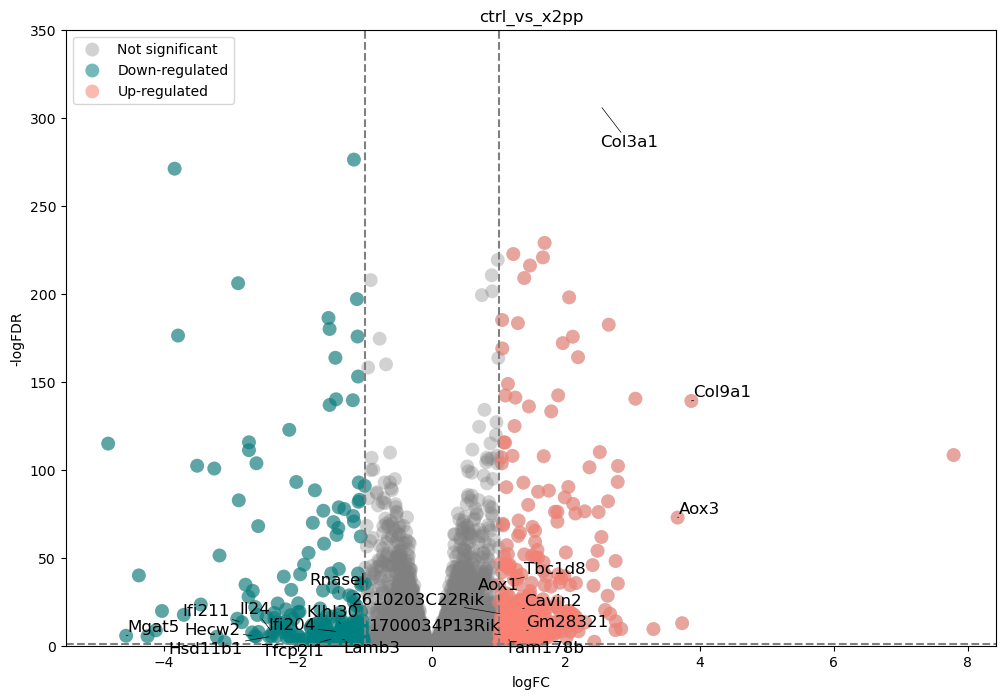

In [501]:
volcano_1(stat_res_Ctrl_vs_CNPP_results_me,(12,8))
plt.title('ctrl_vs_x2pp')

### DEG list

In [183]:
not_significaiton_Ctrl_vs_CNPP_me = not_signification(stat_res_Ctrl_vs_CNPP_results_me)
not_significaiton_Ctrl_vs_CNPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Mrpl15,2370.355943,-0.181578,0.036130,-5.025647,5.017369e-07,0.000002
Lypla1,1159.267411,-0.255528,0.052304,-4.885469,1.031827e-06,0.000004
Tcea1,2662.413556,-0.208048,0.052200,-3.985580,6.731562e-05,0.000194
Gm6104,20.080322,-0.269273,0.281298,-0.957251,3.384404e-01,0.431289
Rgs20,69.834088,-0.020521,0.162177,-0.126535,8.993082e-01,0.926777
...,...,...,...,...,...,...
NaN,783.762879,-0.167292,0.058350,-2.867042,4.143276e-03,0.008885
NaN,558.076836,0.168733,0.052611,3.207179,1.340435e-03,0.003131
NaN,671.147121,-0.020594,0.051407,-0.400617,6.887025e-01,0.760345


In [184]:
filter_Ctrl_vs_CNPP_me = filter(stat_res_Ctrl_vs_CNPP_results_me)
filter_Ctrl_vs_CNPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
2610203C22Rik,100.864853,1.054369,0.115937,9.094294,9.520305e-20,1.067051e-18
1700034P13Rik,35.840276,1.064045,0.204335,5.207366,1.915403e-07,7.731946e-07
Col9a1,101.230005,3.873706,0.152545,25.393856,2.948445e-142,8.455627e-140
Fam178b,14.862900,1.100875,0.280013,3.931516,8.441195e-05,2.393214e-04
Tbc1d8,195.529536,1.223270,0.092676,13.199403,8.843354e-40,2.615729e-38
...,...,...,...,...,...,...
Slit1,72.187313,2.530832,0.149485,16.930316,2.689317e-64,1.673465e-62
Cfap58,31.292879,-1.623904,0.203917,-7.963563,1.671544e-15,1.409010e-14
Mirt1,81.274954,-1.045847,0.164914,-6.341767,2.271444e-10,1.238219e-09


In [185]:
up_Ctrl_vs_CNPP_me = up_reg(stat_res_Ctrl_vs_CNPP_results_me)
up_Ctrl_vs_CNPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Fut8,3709.027395,1.099557,0.023723,46.349253,0.000000,0.000000
Col3a1,535.546005,2.512570,0.065374,38.433963,0.000000,0.000000
Atp1a2,1482.589939,2.353333,0.046257,50.875520,0.000000,0.000000
Col6a2,4415.496631,1.702479,0.035633,47.778139,0.000000,0.000000
Tgfbi,856.449624,2.893998,0.048451,59.730997,0.000000,0.000000
...,...,...,...,...,...,...
Gm47218,8.281466,1.000010,0.394201,2.536800,0.011187,0.021886
Smim43,6.916188,1.040284,0.416746,2.496206,0.012553,0.024324
Gm42670,6.346731,1.335832,0.555632,2.404165,0.016209,0.030613


In [186]:
up_Ctrl_vs_CNPP_me_s = up_reg_s(stat_res_Ctrl_vs_CNPP_results_me)
up_Ctrl_vs_CNPP_me_s

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Tgfbi,856.449624,2.893998,0.048451,59.730997,0.000000,0.000000
Atp1a2,1482.589939,2.353333,0.046257,50.875520,0.000000,0.000000
Fut8,3709.027395,1.099557,0.023723,46.349253,0.000000,0.000000
Col6a2,4415.496631,1.702479,0.035633,47.778139,0.000000,0.000000
Col3a1,535.546005,2.512570,0.065374,38.433963,0.000000,0.000000
...,...,...,...,...,...,...
Gm44983,9.496977,1.148250,0.391829,2.930485,0.003384,0.007383
Pecam1,9.146924,1.150694,0.393276,2.925915,0.003434,0.007481
Slc16a5,10.669596,1.078953,0.369383,2.920963,0.003490,0.007590


In [187]:
save(up_Ctrl_vs_CNPP_me,'Up_Ctrl_vs_CNPP_me')

In [188]:
down_Ctrl_vs_CNPP_me = down_reg(stat_res_Ctrl_vs_CNPP_results_me)
down_Ctrl_vs_CNPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Lgals9,3763.312047,-1.164815,0.032565,-35.769121,3.337267e-280,6.289318e-277
Oas1a,402.763145,-3.842610,0.108448,-35.432709,5.356090e-275,8.832193e-272
Dtna,404.160821,-2.894243,0.093679,-30.895407,1.376782e-209,1.068383e-206
Aif1l,1375.869509,-1.120681,0.037097,-30.209565,1.773724e-200,1.114236e-197
Rigi,1539.184530,-1.545021,0.052588,-29.379609,1.000620e-189,6.000082e-187
...,...,...,...,...,...,...
Gm10544,10.302016,-1.117054,0.457253,-2.442964,1.456719e-02,2.783464e-02
Gm13270,7.340573,-1.245399,0.519589,-2.396891,1.653485e-02,3.114446e-02
Dyrk4,6.121991,-1.164820,0.503576,-2.313094,2.071747e-02,3.819241e-02


In [189]:
down_Ctrl_vs_CNPP_me_s = down_reg_s(stat_res_Ctrl_vs_CNPP_results_me)
down_Ctrl_vs_CNPP_me_s

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Lgals9,3763.312047,-1.164815,0.032565,-35.769121,3.337267e-280,6.289318e-277
Oas1a,402.763145,-3.842610,0.108448,-35.432709,5.356090e-275,8.832193e-272
Dtna,404.160821,-2.894243,0.093679,-30.895407,1.376782e-209,1.068383e-206
Aif1l,1375.869509,-1.120681,0.037097,-30.209565,1.773724e-200,1.114236e-197
Rigi,1539.184530,-1.545021,0.052588,-29.379609,1.000620e-189,6.000082e-187
...,...,...,...,...,...,...
Tmsb4x,95.083675,-3.096899,1.058829,-2.924835,3.446388e-03,7.503672e-03
Ak8,8.495572,-1.379290,0.474654,-2.905888,3.662126e-03,7.931500e-03
Cdh5,8.586487,-1.595585,0.549313,-2.904690,3.676174e-03,7.956701e-03


In [190]:
save(down_Ctrl_vs_CNPP_me,'down_Ctrl_vs_CNPP_me')

### GSEA

In [191]:
gsea(down_Ctrl_vs_CNPP_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Defense Response T...,0.000000,-0.698197,-1.878755
1,GO_Biological_Process_2023__Defense Response T...,0.000000,-0.718678,-1.885397
2,GO_Biological_Process_2023__Regulation Of Tran...,0.102473,-0.520837,-1.352099


In [192]:
gsea(up_Ctrl_vs_CNPP_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Positive Regulatio...,0.127148,0.535308,1.419319
1,GO_Biological_Process_2023__Regulation Of Tran...,0.185567,0.510163,1.430950
2,GO_Biological_Process_2023__Regulation Of Apop...,0.247423,0.506590,1.284537
3,GO_Biological_Process_2023__Positive Regulatio...,0.309278,0.551669,1.444697
4,GO_Biological_Process_2023__Regulation Of Cell...,0.364948,0.412939,1.152136
5,GO_Biological_Process_2023__Regulation Of DNA-...,0.529210,0.369194,1.036731
6,GO_Biological_Process_2023__Regulation Of Gene...,0.596465,0.349087,0.942177


### MsigDb Hallmark

In [193]:
hallmark_enrichment(up_Ctrl_vs_CNPP_me)

2024-03-05 10:16:25,530 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:25,531 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:25,535 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:25,545 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:25,794 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
28,HALLMARK_MYOGENESIS,0.000512,0.020478,Col6a2;Ncam1;Nos1;Fxyd1;Vipr1;Lpin1;Col1a1;Myl...
25,HALLMARK_KRAS_SIGNALING_UP,0.001643,0.032861,Cmklr1;Tmem176a;Ace;Cxcl10;Il2rg;Trib2;Gng11;P...
5,HALLMARK_APICAL_SURFACE,0.003014,0.040182,Rtn4rl1;Mdga1;Slc2a4;Il2rg;Cx3cl1
4,HALLMARK_APICAL_JUNCTION,0.005252,0.042013,Nrxn2;Myl9;Rac2;Actg2;Cldn9;Col9a1;Pecam1;Jup;...
11,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.004331,0.042013,Col6a2;Myl9;Lrrc15;Col1a1;Mylk;Col6a3;Col3a1;T...
3,HALLMARK_ANGIOGENESIS,0.047952,0.274013,Jag2;Col3a1;S100a4
37,HALLMARK_UV_RESPONSE_DN,0.045305,0.274013,Atp2b4;Celf2;Col1a1;Prkar2b;Col3a1;Pmp22;Cdon


In [194]:
hallmark_enrichment(down_Ctrl_vs_CNPP_me)

2024-03-05 10:16:25,805 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:25,807 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:25,810 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:25,820 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:26,076 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
18,HALLMARK_INTERFERON_ALPHA_RESPONSE,2.038187e-21,6.318379e-20,Ifih1;Bst2;Gbp3;Trim21;Parp9;Parp14;Usp18;Psmb...
19,HALLMARK_INTERFERON_GAMMA_RESPONSE,1.866619e-20,2.893259e-19,Ifih1;Bst2;Gbp3;Trim21;Cd274;Parp14;Usp18;Psmb...
13,HALLMARK_HEDGEHOG_SIGNALING,1.730560e-02,1.788245e-01,Adgrg1;Nrcam;L1cam
28,HALLMARK_TNFA_SIGNALING_VIA_NFKB,2.969091e-02,2.301046e-01,Lamb3;Ifih1;Ifit2;Ppp1r15a;Rigi;Panx1;Cd69


## Ctrl vs CPPP (ctrl vs pp)

In [195]:
stat_res_Ctrl_vs_CPPP_me = DeseqStats(dds_me, contrast=["Genotype", "CPPP", "Ctrl"], inference=inference)
stat_res_Ctrl_vs_CPPP_me.summary()
# CPPP 相比较于 ctrl

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPP vs Ctrl
                       baseMean  log2FoldChange     lfcSE       stat  \
ensembl                                                                
ENSMUSG00000033845  2370.355943       -0.131027  0.027350  -4.790708   
ENSMUSG00000025903  1159.267411        0.105714  0.039053   2.706924   
ENSMUSG00000033813  2662.413556       -0.188774  0.039457  -4.784344   
ENSMUSG00000062588    20.080322        0.059749  0.211167   0.282948   
ENSMUSG00000002459    69.834088        0.817333  0.113922   7.174522   
...                         ...             ...       ...        ...   
ENSMUSG00000051412   783.762879        0.068757  0.043641   1.575509   
ENSMUSG00000061654   558.076836       -0.608304  0.042858 -14.193627   
ENSMUSG00000079834   671.147121        0.004116  0.039078   0.105318   
ENSMUSG00000095041  5672.196591       -0.219495  0.078153  -2.808520   
ENSMUSG00000063897   537.012771        0.109345  0.045077   2.425754   

   

... done in 0.87 seconds.



In [196]:
stat_res_Ctrl_vs_CPPP_results_me = stat_res_Ctrl_vs_CPPP_me.results_df.copy()
stat_res_Ctrl_vs_CPPP_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol']
stat_res_Ctrl_vs_CPPP_results_me.set_index('symbol',inplace = True)

In [197]:
res_Ctrl_vs_CPPP_results_me = add_DEG_column(stat_res_Ctrl_vs_CPPP_me.results_df)

In [198]:
res_Ctrl_vs_CPPP_results_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,DEG
ensembl,,,,,,,
ENSMUSG00000033845,2370.355943,-0.131027,0.027350,-4.790708,1.661942e-06,3.541897e-06,0
ENSMUSG00000025903,1159.267411,0.105714,0.039053,2.706924,6.790977e-03,1.030204e-02,0
ENSMUSG00000033813,2662.413556,-0.188774,0.039457,-4.784344,1.715466e-06,3.651836e-06,0
ENSMUSG00000062588,20.080322,0.059749,0.211167,0.282948,7.772166e-01,8.088546e-01,0
ENSMUSG00000002459,69.834088,0.817333,0.113922,7.174522,7.256021e-13,2.224011e-12,0
...,...,...,...,...,...,...,...
ENSMUSG00000051412,783.762879,0.068757,0.043641,1.575509,1.151390e-01,1.461337e-01,0
ENSMUSG00000061654,558.076836,-0.608304,0.042858,-14.193627,1.003316e-45,8.539189e-45,0
ENSMUSG00000079834,671.147121,0.004116,0.039078,0.105318,9.161238e-01,9.303700e-01,0


### Valcano plot

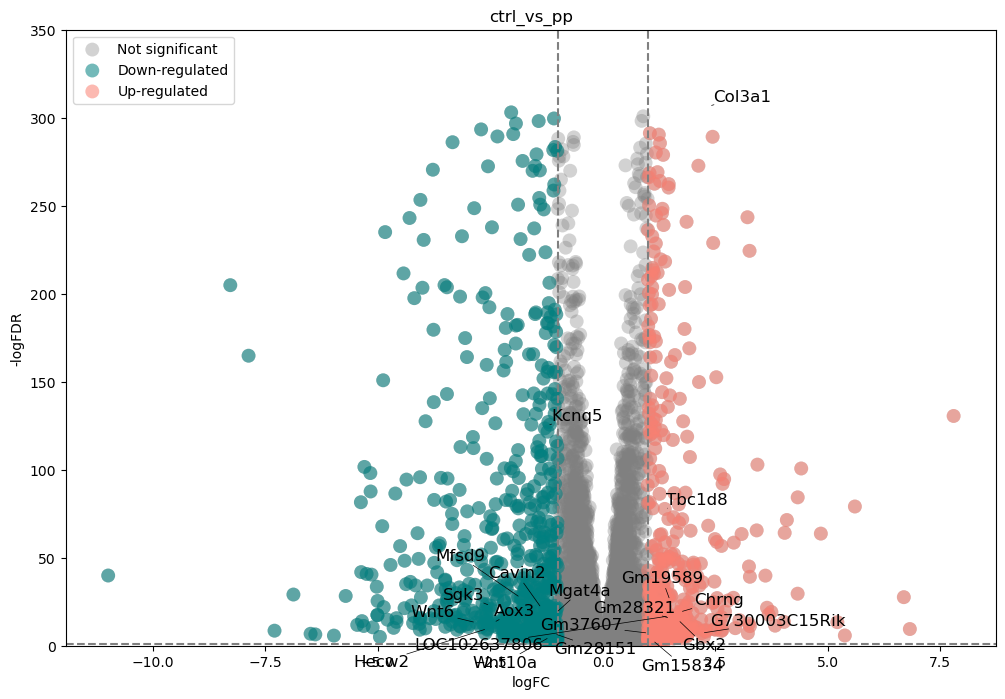

In [503]:
volcano_1(stat_res_Ctrl_vs_CPPP_results_me,(12,8))
plt.title('ctrl_vs_pp')
plt.show()

### DEG list

In [200]:
not_significaiton_Ctrl_vs_CPPP_me = not_signification(stat_res_Ctrl_vs_CPPP_results_me)
not_significaiton_Ctrl_vs_CPPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Mrpl15,2370.355943,-0.131027,0.027350,-4.790708,1.661942e-06,3.541897e-06
Lypla1,1159.267411,0.105714,0.039053,2.706924,6.790977e-03,1.030204e-02
Tcea1,2662.413556,-0.188774,0.039457,-4.784344,1.715466e-06,3.651836e-06
Gm6104,20.080322,0.059749,0.211167,0.282948,7.772166e-01,8.088546e-01
Rgs20,69.834088,0.817333,0.113922,7.174522,7.256021e-13,2.224011e-12
...,...,...,...,...,...,...
NaN,783.762879,0.068757,0.043641,1.575509,1.151390e-01,1.461337e-01
NaN,558.076836,-0.608304,0.042858,-14.193627,1.003316e-45,8.539189e-45
NaN,671.147121,0.004116,0.039078,0.105318,9.161238e-01,9.303700e-01


In [201]:
filter_Ctrl_vs_CPPP_me = filter(stat_res_Ctrl_vs_CPPP_results_me)
filter_Ctrl_vs_CPPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Sgk3,21.778590,-2.498318,0.246478,-10.136053,3.822328e-24,1.854511e-23
Kcnq5,467.400569,-1.175648,0.048897,-24.043379,9.791121e-128,2.508048e-126
Mgat4a,86.693008,-1.037926,0.113320,-9.159209,5.227890e-20,2.185245e-19
Tbc1d8,195.529536,1.379693,0.073016,18.895754,1.236081e-79,1.821943e-78
Mfsd9,35.041359,-1.828008,0.164317,-11.124851,9.496469e-29,5.283738e-28
...,...,...,...,...,...,...
Ablim1,359.083670,-1.194883,0.055544,-21.512358,1.192840e-102,2.341659e-101
mt-Rnr2,2952.239384,1.341339,0.175854,7.627588,2.391867e-14,7.902205e-14
mt-Tl1,106.031058,1.472593,0.198832,7.406199,1.299706e-13,4.146487e-13


In [202]:
up_Ctrl_vs_CPPP_me = up_reg(stat_res_Ctrl_vs_CPPP_results_me)
up_Ctrl_vs_CPPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Ddx19b,3094.390120,1.205120,0.022797,52.862373,0.000000,0.000000
6430548M08Rik,1119.052205,1.430765,0.032666,43.799253,0.000000,0.000000
Apobr,3029.409896,1.152373,0.023508,49.020130,0.000000,0.000000
Gse1,6212.839014,1.274484,0.027788,45.864842,0.000000,0.000000
Psmd7,9849.931487,1.322710,0.023243,56.908782,0.000000,0.000000
...,...,...,...,...,...,...
Rslcan18,6.642616,1.257109,0.393031,3.198496,0.001381,0.002272
Gm11508,6.631489,1.381077,0.438781,3.147535,0.001647,0.002691
Il16,8.185023,1.013482,0.327655,3.093141,0.001981,0.003208


In [203]:
up_Ctrl_vs_CPPP_me_s = up_reg_s(stat_res_Ctrl_vs_CPPP_results_me)
up_Ctrl_vs_CPPP_me_s

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Ddx19b,3094.390120,1.205120,0.022797,52.862373,0.000000,0.000000
6430548M08Rik,1119.052205,1.430765,0.032666,43.799253,0.000000,0.000000
Apobr,3029.409896,1.152373,0.023508,49.020130,0.000000,0.000000
Gse1,6212.839014,1.274484,0.027788,45.864842,0.000000,0.000000
Psmd7,9849.931487,1.322710,0.023243,56.908782,0.000000,0.000000
...,...,...,...,...,...,...
Rslcan18,6.642616,1.257109,0.393031,3.198496,0.001381,0.002272
Gm11508,6.631489,1.381077,0.438781,3.147535,0.001647,0.002691
Il16,8.185023,1.013482,0.327655,3.093141,0.001981,0.003208


In [204]:
save(up_Ctrl_vs_CPPP_me,'Up_Ctrl_vs_CPPP_me')

In [205]:
down_Ctrl_vs_CPPP_me = down_reg(stat_res_Ctrl_vs_CPPP_results_me)
down_Ctrl_vs_CPPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Slpi,627.753090,-3.023860,0.054950,-55.029090,0.000000,0.000000
Plat,431.724334,-2.703035,0.061068,-44.262828,0.000000,0.000000
Stim1,1557.244570,-1.082287,0.025628,-42.230706,0.000000,0.000000
Oas1a,402.763145,-2.772140,0.062958,-44.031265,0.000000,0.000000
Csrp1,2028.641948,-1.147823,0.026247,-43.731546,0.000000,0.000000
...,...,...,...,...,...,...
Sytl1,9.554365,-1.032973,0.303462,-3.403963,0.000664,0.001129
Gm43965,8.323295,-1.081502,0.318750,-3.392948,0.000691,0.001174
Gm7390,11.540456,-1.003315,0.301020,-3.333055,0.000859,0.001444


In [206]:
down_Ctrl_vs_CPPP_me_s = down_reg_s(stat_res_Ctrl_vs_CPPP_results_me)
down_Ctrl_vs_CPPP_me_s

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Lims2,466.044753,-2.443569,0.057904,-42.200197,0.000000,0.000000
Slpi,627.753090,-3.023860,0.054950,-55.029090,0.000000,0.000000
Plat,431.724334,-2.703035,0.061068,-44.262828,0.000000,0.000000
Abcg2,1059.744785,-1.969358,0.044335,-44.419599,0.000000,0.000000
Csrp1,2028.641948,-1.147823,0.026247,-43.731546,0.000000,0.000000
...,...,...,...,...,...,...
AA388235,10.483488,-1.019414,0.290142,-3.513502,0.000442,0.000765
Eef1akmt3,10.799263,-1.024084,0.298313,-3.432924,0.000597,0.001020
Sytl1,9.554365,-1.032973,0.303462,-3.403963,0.000664,0.001129


In [207]:
save(down_Ctrl_vs_CPPP_me,'down_Ctrl_vs_CPPP_me')

### GSEA

In [208]:
gsea(down_Ctrl_vs_CPPP_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Regulation Of Cyto...,0.051227,-0.672092,-1.722103
1,GO_Biological_Process_2023__Positive Regulatio...,0.133191,-0.589039,-1.560201
2,GO_Biological_Process_2023__Defense Response T...,0.146852,-0.568852,-1.578122
3,GO_Biological_Process_2023__Positive Regulatio...,0.147535,-0.557403,-1.528447
4,GO_Biological_Process_2023__Positive Regulatio...,0.157097,-0.544746,-1.504946
5,GO_Biological_Process_2023__Response To Lipopo...,0.162464,-0.561264,-1.486650
6,GO_Biological_Process_2023__Defense Response T...,0.163927,-0.554580,-1.467486
7,GO_Biological_Process_2023__Defense Response T...,0.199787,-0.587657,-1.594279
8,GO_Biological_Process_2023__Positive Regulatio...,0.226425,-0.547679,-1.408683
9,GO_Biological_Process_2023__Positive Regulatio...,0.226539,-0.542039,-1.420670


In [209]:
gsea(up_Ctrl_vs_CPPP_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Regulation Of Tran...,0.065990,0.577626,1.382276
1,GO_Biological_Process_2023__Negative Regulatio...,0.071066,0.641971,1.456759
2,GO_Biological_Process_2023__Regulation Of DNA-...,0.155668,0.521825,1.242819
3,GO_Biological_Process_2023__Regulation Of Cell...,0.500000,0.435503,1.000713


### MsigDb Hallmark

In [210]:
hallmark_enrichment(up_Ctrl_vs_CPPP_me)

2024-03-05 10:16:34,544 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:34,547 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:34,550 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:34,562 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:34,804 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
8,HALLMARK_CHOLESTEROL_HOMEOSTASIS,4.598092e-07,0.000021,Lss;Aldoc;Hsd17b7;Idi1;Stard4;Acat2;Mvd;Cyp51;...
30,HALLMARK_MYOGENESIS,1.566399e-04,0.003524,Ncam1;Col6a2;Nos1;Nqo1;Mras;Gabarapl2;Vipr1;Lp...
26,HALLMARK_KRAS_SIGNALING_UP,3.783139e-02,0.567471,Tmem176a;Il2rg;Trib2;Scn1b;Etv1;Gprc5b;Tmem176...


In [211]:
hallmark_enrichment(down_Ctrl_vs_CPPP_me)

2024-03-05 10:16:34,816 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:34,818 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:34,821 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:34,834 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:35,272 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
24,HALLMARK_INTERFERON_GAMMA_RESPONSE,4.392696e-21,2.064567e-19,Ifih1;Bst2;Gbp3;H2-DMa;Ccl7;Cd274;Casp4;Oasl1;...
23,HALLMARK_INTERFERON_ALPHA_RESPONSE,1.937966e-18,4.554221e-17,Ifih1;Bst2;Gbp3;Oasl1;Parp14;Usp18;Tap1;Psmb9;...
22,HALLMARK_INFLAMMATORY_RESPONSE,9.951395e-06,1.169289e-04,Bst2;Rnf144b;Serpine1;Ccl7;Calcrl;Osmr;Sgms2;P...
41,HALLMARK_TNFA_SIGNALING_VIA_NFKB,9.082471e-06,1.169289e-04,Lamb3;Ifih1;Serpine1;Ackr3;Plau;Tnfaip3;Tap1;C...
26,HALLMARK_KRAS_SIGNALING_UP,2.623186e-04,2.465795e-03,Plau;Prrx1;Prdm1;Map4k1;Tnfaip3;Plat;Hkdc1;Hsd...
5,HALLMARK_APOPTOSIS,8.971839e-04,7.027941e-03,Mmp2;Plat;Tgfb2;Pmaip1;Rnasel;Erbb3;Gadd45a;Er...
9,HALLMARK_COMPLEMENT,1.810948e-03,1.215922e-02,Serpine1;Casp4;Tnfaip3;Plat;Psmb9;C1s1;C2;Casp...
1,HALLMARK_ALLOGRAFT_REJECTION,2.785149e-03,1.636275e-02,H2-DMa;Ccl7;Map4k1;Tap1;Il27ra;Ly75;Ncf4;C2;Tl...
8,HALLMARK_COAGULATION,6.148525e-03,3.210896e-02,Pros1;Mmp2;Hnf4a;Plat;Mmp3;Serpine1;Acox2;C1s1...
21,HALLMARK_IL6_JAK_STAT3_SIGNALING,8.792265e-03,4.132364e-02,Acvrl1;Ccl7;Cntfr;Tnf;Osmr;Tlr2;Fas;Irf9;Il7;I...


## CPPN vs CPPP (pm vs pp)

In [212]:
stat_res_CPPN_vs_CPPP_me = DeseqStats(dds_me, contrast=["Genotype", "CPPP", "CPPN"], inference=inference)
stat_res_CPPN_vs_CPPP_me.summary()
# CPPP (pp) 相比较于 CPPN (pm)

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPP vs CPPN
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ensembl                                                                         
ENSMUSG00000033845  2370.355943       -0.169718  0.036015 -4.712380  0.000002   
ENSMUSG00000025903  1159.267411        0.090002  0.051734  1.739704  0.081911   
ENSMUSG00000033813  2662.413556       -0.212615  0.052038 -4.085760  0.000044   
ENSMUSG00000062588    20.080322        0.052062  0.283997  0.183318  0.854548   
ENSMUSG00000002459    69.834088        0.388486  0.142552  2.725217  0.006426   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000051412   783.762879       -0.013702  0.057289 -0.239169  0.810974   
ENSMUSG00000061654   558.076836        0.143299  0.060240  2.378789  0.017370   
ENSMUSG00000079834   671.147121        0.104747  0.052042  2.012729  0.044143   
ENSMUSG00000095041  5672.196591        0.349189  

... done in 0.85 seconds.



In [213]:
stat_res_CPPN_vs_CPPP_results_me = stat_res_CPPN_vs_CPPP_me.results_df.copy()
stat_res_CPPN_vs_CPPP_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
stat_res_CPPN_vs_CPPP_results_me.set_index('symbol',inplace = True)

In [214]:
stat_res_CPPN_vs_CPPP_results_me = stat_res_CPPN_vs_CPPP_results_me.sort_values(by='padj', ascending=True)

In [215]:
res_CPPN_vs_CPPP_results_me = add_DEG_column(stat_res_CPPN_vs_CPPP_me.results_df)

### Valcano plot

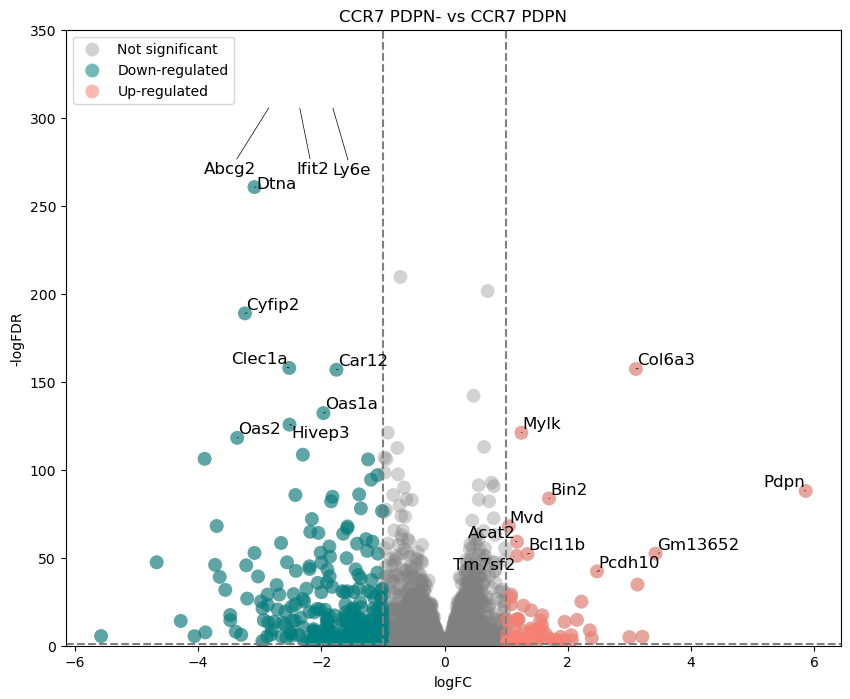

In [504]:
volcano_1(stat_res_CPPN_vs_CPPP_results_me,(10,8))
plt.title('CCR7 PDPN- vs CCR7 PDPN')
plt.show()

### DEG list

In [217]:
filter_CPPPvsCPPN_me = filter(stat_res_CPPN_vs_CPPP_results_me)
filter_CPPPvsCPPN_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Ly6e,2603.116627,-1.824993,0.044370,-41.131507,0.000000e+00,0.000000e+00
Abcg2,1059.744785,-2.827804,0.053697,-52.661883,0.000000e+00,0.000000e+00
Ifit2,668.718767,-2.358319,0.059585,-39.579116,0.000000e+00,0.000000e+00
Dtna,404.160821,-3.084627,0.088726,-34.765922,7.965448e-265,2.627005e-261
Cyfip2,219.921843,-3.239953,0.109374,-29.622806,7.599991e-193,1.432273e-189
...,...,...,...,...,...,...
Rps12-ps4,10.730383,1.021207,0.417224,2.447623,1.438019e-02,3.185083e-02
Ric3,7.862272,-1.119404,0.470552,-2.378917,1.736360e-02,3.770544e-02
Shroom3,8.509028,-1.763645,0.745730,-2.364992,1.803045e-02,3.901225e-02


In [218]:
up_CPPPvsCPPN_me = up_reg(stat_res_CPPN_vs_CPPP_results_me)
up_CPPPvsCPPN_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Col6a3,1475.136938,3.106811,0.114862,27.048280,4.001588e-161,5.865439e-158
Mylk,632.612244,1.247586,0.052531,23.749664,1.107562e-124,9.740638e-122
Pdpn,370.144888,5.861652,0.289300,20.261514,2.811833e-91,1.159178e-88
Bin2,297.407433,1.696211,0.085813,19.766363,5.801058e-87,2.068312e-84
Mvd,3258.249792,1.044709,0.058634,17.817377,5.180942e-71,1.265685e-68
...,...,...,...,...,...,...
Gm12203,9.261520,1.018796,0.393484,2.589165,9.620900e-03,2.246750e-02
Large2,9.249254,1.140053,0.449838,2.534364,1.126517e-02,2.583115e-02
Frmd4b,12.222070,1.029966,0.406549,2.533432,1.129515e-02,2.588252e-02


In [219]:
up_CPPPvsCPPN_me_s = up_reg_s(stat_res_CPPN_vs_CPPP_results_me)
up_CPPPvsCPPN_me_s

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Col6a3,1475.136938,3.106811,0.114862,27.048280,4.001588e-161,5.865439e-158
Mylk,632.612244,1.247586,0.052531,23.749664,1.107562e-124,9.740638e-122
Pdpn,370.144888,5.861652,0.289300,20.261514,2.811833e-91,1.159178e-88
Bin2,297.407433,1.696211,0.085813,19.766363,5.801058e-87,2.068312e-84
Mvd,3258.249792,1.044709,0.058634,17.817377,5.180942e-71,1.265685e-68
...,...,...,...,...,...,...
Rpl10-ps3,21.726772,1.125251,0.362421,3.104813,1.903993e-03,5.393489e-03
Cyp46a1,15.000145,1.308812,0.421536,3.104861,1.903683e-03,5.393489e-03
Angpt2,15.373352,1.093115,0.358888,3.045842,2.320300e-03,6.437306e-03


In [220]:
save(up_CPPPvsCPPN_me,'Up_CPPPvsCPPN_me')

In [221]:
down_CPPPvsCPPN_me = down_reg(stat_res_CPPN_vs_CPPP_results_me)
down_CPPPvsCPPN_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Ly6e,2603.116627,-1.824993,0.044370,-41.131507,0.000000e+00,0.000000e+00
Abcg2,1059.744785,-2.827804,0.053697,-52.661883,0.000000e+00,0.000000e+00
Ifit2,668.718767,-2.358319,0.059585,-39.579116,0.000000e+00,0.000000e+00
Dtna,404.160821,-3.084627,0.088726,-34.765922,7.965448e-265,2.627005e-261
Cyfip2,219.921843,-3.239953,0.109374,-29.622806,7.599991e-193,1.432273e-189
...,...,...,...,...,...,...
Gm45552,19.925301,-1.261787,0.509437,-2.476825,1.325569e-02,2.970427e-02
Wnt6,12.626688,-1.196063,0.484216,-2.470099,1.350756e-02,3.017642e-02
Ric3,7.862272,-1.119404,0.470552,-2.378917,1.736360e-02,3.770544e-02


In [222]:
down_CPPPvsCPPN_me_s = down_reg_s(stat_res_CPPN_vs_CPPP_results_me)
down_CPPPvsCPPN_me_s

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Ly6e,2603.116627,-1.824993,0.044370,-41.131507,0.000000e+00,0.000000e+00
Abcg2,1059.744785,-2.827804,0.053697,-52.661883,0.000000e+00,0.000000e+00
Ifit2,668.718767,-2.358319,0.059585,-39.579116,0.000000e+00,0.000000e+00
Dtna,404.160821,-3.084627,0.088726,-34.765922,7.965448e-265,2.627005e-261
Cyfip2,219.921843,-3.239953,0.109374,-29.622806,7.599991e-193,1.432273e-189
...,...,...,...,...,...,...
Coro2b,9.657775,-1.201286,0.407569,-2.947439,3.204183e-03,8.551402e-03
D730044K07Rik,15.077876,-1.227248,0.420221,-2.920483,3.494897e-03,9.244973e-03
Gm42928,10.565241,-1.137809,0.390106,-2.916668,3.537922e-03,9.353160e-03


In [223]:
save(down_CPPPvsCPPN_me,'Down_CPPPvsCPPN_me')

In [224]:
not_significaiton_CPPP_vs_CPPN_me = not_signification(stat_res_CPPN_vs_CPPP_results_me)

### GSEA

gsea(up_CPPPvsCPPN_me) #跑不出来

In [225]:
gsea(down_CPPPvsCPPN_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Positive Regulatio...,0.286201,-0.496517,-1.353641
1,GO_Biological_Process_2023__Regulation Of DNA-...,0.316865,-0.453042,-1.268057
2,GO_Biological_Process_2023__Cellular Response ...,0.488927,-0.359484,-1.010253
3,GO_Biological_Process_2023__Positive Regulatio...,0.496763,-0.404592,-1.064381
4,GO_Biological_Process_2023__Regulation Of Gene...,0.521295,-0.398140,-1.099083
5,GO_Biological_Process_2023__Regulation Of Tran...,0.551959,-0.477599,-1.366267


### MsigDb Hallmark

In [226]:
hallmark_enrichment(up_CPPPvsCPPN_me)

2024-03-05 10:16:37,840 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:37,843 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:37,848 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:37,862 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:38,103 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
3,HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.000177,0.003188,Aldoc;Mvd;Acat2;Tm7sf2
4,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.045041,0.287998,Pfn2;Col6a3;Mylk
13,HALLMARK_MYOGENESIS,0.048000,0.287998,Col6a3;Ryr1;Mylk


In [227]:
hallmark_enrichment(down_CPPPvsCPPN_me)

2024-03-05 10:16:38,114 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:38,117 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:38,120 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:38,133 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:38,378 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
22,HALLMARK_INTERFERON_GAMMA_RESPONSE,3.151878e-16,1.229232e-14,Ifih1;Gbp3;Cd274;Casp4;Parp14;Usp18;Cmklr1;Ly6...
21,HALLMARK_INTERFERON_ALPHA_RESPONSE,6.258787e-12,1.220463e-10,Sp110;Ifih1;Trim14;Gbp3;Rtp4;Ifit2;Ifit3;Irf7;...
33,HALLMARK_TNFA_SIGNALING_VIA_NFKB,1.036385e-03,1.347301e-02,Serpinb8;Lamb3;Gem;Ifih1;Ifit2;Plek;Ppp1r15a;C...
4,HALLMARK_APOPTOSIS,6.390589e-03,6.230824e-02,Mmp2;Plcb2;Tgfb2;Ddit3;Pmaip1;Casp4;Casp1;Btg2...
20,HALLMARK_INFLAMMATORY_RESPONSE,9.389950e-03,6.329392e-02,Cmklr1;Scarf1;Rtp4;Irf7;Ly6e;Calcrl;Cd69;Lcp2;...
24,HALLMARK_KRAS_SIGNALING_UP,9.737526e-03,6.329392e-02,Lcp1;Cmklr1;Ppp1r15a;Hkdc1;Ephb2;Prrx1;Ush1c;H...
8,HALLMARK_COMPLEMENT,1.619293e-02,9.021773e-02,Plek;Irf7;F5;C1s1;Casp4;Pla2g4a;Lcp2;Ctso;Casp...


## CNPP vs CPPP (x2pp vs pp)

In [228]:
stat_res_CNPP_vs_CPPP_me = DeseqStats(dds_me, contrast=["Genotype", "CPPP", "CNPP"], inference=inference)
stat_res_CNPP_vs_CPPP_me.summary()
# cppp 相比较于 cnpp 

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPP vs CNPP
                       baseMean  log2FoldChange     lfcSE       stat  \
ensembl                                                                
ENSMUSG00000033845  2370.355943        0.050551  0.036337   1.391159   
ENSMUSG00000025903  1159.267411        0.361242  0.052244   6.914564   
ENSMUSG00000033813  2662.413556        0.019274  0.052373   0.368011   
ENSMUSG00000062588    20.080322        0.329023  0.281271   1.169773   
ENSMUSG00000002459    69.834088        0.837854  0.155704   5.381077   
...                         ...             ...       ...        ...   
ENSMUSG00000051412   783.762879        0.236049  0.058338   4.046251   
ENSMUSG00000061654   558.076836       -0.777037  0.054720 -14.200243   
ENSMUSG00000079834   671.147121        0.024710  0.051550   0.479344   
ENSMUSG00000095041  5672.196591       -0.355781  0.103323  -3.443403   
ENSMUSG00000063897   537.012771        0.199234  0.059443   3.351668   

   

... done in 0.81 seconds.



In [229]:
stat_res_CNPP_vs_CPPP_results_me = stat_res_CNPP_vs_CPPP_me.results_df.copy()
stat_res_CNPP_vs_CPPP_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
stat_res_CNPP_vs_CPPP_results_me.set_index('symbol',inplace = True)

In [230]:
stat_res_CNPP_vs_CPPP_results_me = stat_res_CNPP_vs_CPPP_results_me.sort_values(by='padj', ascending=True)

In [231]:
res_CNPP_vs_CPPP_results_me = add_DEG_column(stat_res_CNPP_vs_CPPP_me.results_df)

### Valcano plot

Text(0.5, 1.0, 'x2pp_vs_pp')

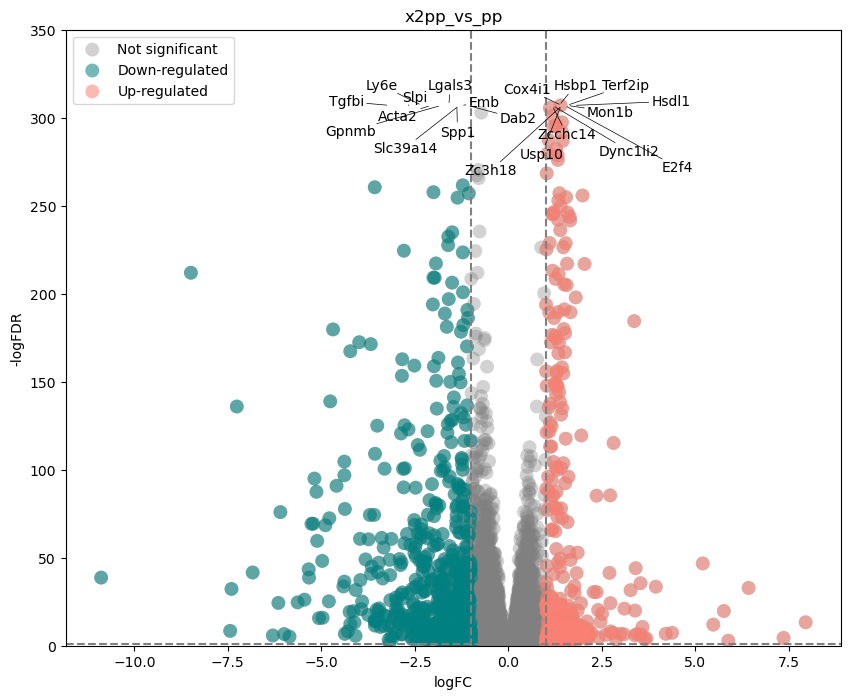

In [232]:
volcano_1(stat_res_CNPP_vs_CPPP_results_me,(10,8))
plt.title('x2pp_vs_pp')

### DEG list

In [233]:
filter_CNPPvsCPPP_me= filter(stat_res_CNPP_vs_CPPP_results_me)
filter_CNPPvsCPPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Hsbp1,3096.279066,1.354836,0.034484,39.288625,0.000000,0.000000
Dync1li2,4913.740773,1.178601,0.027605,42.694603,0.000000,0.000000
Zc3h18,5966.795600,1.437146,0.024215,59.348949,0.000000,0.000000
Zcchc14,7585.534055,1.167923,0.027909,41.847860,0.000000,0.000000
Cox4i1,11300.633389,1.423924,0.026367,54.004804,0.000000,0.000000
...,...,...,...,...,...,...
D730044K07Rik,15.077876,-1.065005,0.442510,-2.406736,0.016096,0.027268
Gm43205,9.140743,-1.004073,0.424107,-2.367496,0.017909,0.030104
Gm10544,10.302016,1.073017,0.459291,2.336249,0.019478,0.032460


In [234]:
up_CPPPvsCNPP_me = up_reg(stat_res_CNPP_vs_CPPP_results_me)
up_CPPPvsCNPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Hsbp1,3096.279066,1.354836,0.034484,39.288625,0.000000,0.000000
Sf3b3,12917.499840,1.378154,0.028196,48.877849,0.000000,0.000000
Cog4,3056.736777,1.471631,0.033567,43.842238,0.000000,0.000000
Vac14,3061.185112,1.514205,0.030480,49.677921,0.000000,0.000000
Mlkl,5136.630167,1.642806,0.032399,50.704972,0.000000,0.000000
...,...,...,...,...,...,...
Krt78,7.922017,1.203729,0.469815,2.562135,0.010403,0.018289
Mettl5os,8.222181,1.195510,0.481191,2.484481,0.012974,0.022394
A430093F15Rik,8.289016,1.005812,0.405354,2.481316,0.013090,0.022552


In [235]:
save(up_CPPPvsCNPP_me,'Up_CPPPvsCNPP_me')

In [236]:
down_CPPPvsCNPP_me = down_reg(stat_res_CNPP_vs_CPPP_results_me)
down_CPPPvsCNPP_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Lgals3,6444.408255,-1.591263,0.035233,-45.163944,0.000000,0.000000
Glud1,20107.341279,-1.824121,0.022749,-80.185336,0.000000,0.000000
Shld2,1365.005477,-2.017072,0.045996,-43.853278,0.000000,0.000000
Tfdp1,2177.149334,-1.117785,0.028162,-39.691505,0.000000,0.000000
Gpnmb,9855.324840,-1.797009,0.045085,-39.858252,0.000000,0.000000
...,...,...,...,...,...,...
Siglecg,9.813601,-1.508145,0.625937,-2.409417,0.015978,0.027079
D730044K07Rik,15.077876,-1.065005,0.442510,-2.406736,0.016096,0.027268
Gm43205,9.140743,-1.004073,0.424107,-2.367496,0.017909,0.030104


In [237]:
save(down_CPPPvsCNPP_me,'Down_CPPPvsCNPP_me')

In [238]:
not_significaiton_CPPP_vs_CNPP_me = not_signification(stat_res_CNPP_vs_CPPP_results_me)

### GSEA

In [239]:
gsea(down_CPPPvsCNPP_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Positive Regulatio...,0.163698,-0.622198,-1.657600
1,GO_Biological_Process_2023__Negative Regulatio...,0.266010,-0.594923,-1.586669
2,GO_Biological_Process_2023__Negative Regulatio...,0.283062,-0.563801,-1.546534
3,GO_Biological_Process_2023__Cellular Response ...,0.340186,-0.536969,-1.501003
4,GO_Biological_Process_2023__Positive Regulatio...,0.387965,-0.421064,-1.236471
5,GO_Biological_Process_2023__Protein Modificati...,0.395473,-0.443742,-1.227342
6,GO_Biological_Process_2023__Response To Lipopo...,0.397310,-0.458159,-1.239368
7,GO_Biological_Process_2023__Positive Regulatio...,0.400349,-0.439565,-1.245362
8,GO_Biological_Process_2023__Positive Regulatio...,0.410176,-0.467862,-1.249270
9,GO_Biological_Process_2023__Positive Regulatio...,0.422299,-0.437850,-1.193941


In [240]:
gsea(up_CPPPvsCNPP_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Regulation Of DNA-...,0.030303,0.604266,1.427557
1,GO_Biological_Process_2023__Negative Regulatio...,0.085859,0.588163,1.317080
2,GO_Biological_Process_2023__Regulation Of Tran...,0.195286,0.507756,1.201272
3,GO_Biological_Process_2023__Positive Regulatio...,0.282828,0.506100,1.102185


### MsigDb Hallmark

In [241]:
hallmark_enrichment(down_CPPPvsCNPP_me)

2024-03-05 10:16:46,173 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:46,174 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:46,178 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:46,189 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:46,437 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
25,HALLMARK_INTERFERON_GAMMA_RESPONSE,2.352940e-09,1.082352e-07,Ifih1;Ccl7;Casp4;Tnfaip3;Batf2;Apol6;Cmklr1;Ly...
23,HALLMARK_INFLAMMATORY_RESPONSE,4.982892e-06,1.146065e-04,Serpine1;Ccl7;Calcrl;Nod2;Osmr;Cmklr1;P2rx7;Ly...
24,HALLMARK_INTERFERON_ALPHA_RESPONSE,3.020725e-05,4.631778e-04,Ifih1;Trim14;Ifit2;Rtp4;Ifit3;Rsad2;Ly6e;Cxcl1...
40,HALLMARK_TNFA_SIGNALING_VIA_NFKB,4.448766e-05,5.116081e-04,Ifih1;Serpine1;Ackr3;Egr3;Tnfaip3;Serpinb8;Gem...
12,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,3.078476e-04,2.832198e-03,Serpine1;Prrx1;Tnfaip3;Tgfbi;Matn2;Nt5e;Gem;My...
6,HALLMARK_APOPTOSIS,5.683936e-04,4.357684e-03,Mmp2;Cth;Plat;Tgfb2;Pmaip1;Rnasel;Erbb3;Ereg;T...
10,HALLMARK_COMPLEMENT,1.148678e-03,7.548458e-03,S100a13;Serpine1;Pla2g7;Casp4;Tnfaip3;Plat;C1s...
27,HALLMARK_KRAS_SIGNALING_UP,5.880216e-03,3.381124e-02,Cmklr1;Plat;Ace;Tph1;Btc;Lif;Gpnmb;Cxcl10;Ereg...
22,HALLMARK_IL6_JAK_STAT3_SIGNALING,6.765313e-03,3.457827e-02,Acvrl1;Cxcl10;Ccl7;Cntfr;Tnf;Osmr;Tlr2;Fas;Il7...
9,HALLMARK_COAGULATION,1.096921e-02,4.587125e-02,Pros1;Mmp2;Plat;S100a13;Mmp3;Serpine1;Trf;Lrp1...


In [242]:
hallmark_enrichment(up_CPPPvsCNPP_me)

2024-03-05 10:16:46,448 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:46,450 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:46,454 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:46,464 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:46,703 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
37,HALLMARK_XENOBIOTIC_METABOLISM,0.005452,0.207189,Cyp2j6;Nqo1;Lcat;Psmb10;Bcar1;Kars;Tmem176b;Sl...


## CNPP _vs_ CPPN x2pp vs pm

In [243]:
stat_res_CNPP_vs_CPPN_me = DeseqStats(dds_me, contrast=["Genotype", "CPPN", "CNPP"], inference=inference)
#CPPN 相较于 CNPP

In [244]:
stat_res_CNPP_vs_CPPN_me.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Genotype CPPN vs CNPP
                       baseMean  log2FoldChange     lfcSE       stat  \
ensembl                                                                
ENSMUSG00000033845  2370.355943        0.220269  0.047271   4.659743   
ENSMUSG00000025903  1159.267411        0.271240  0.068274   3.972812   
ENSMUSG00000033813  2662.413556        0.231889  0.068266   3.396837   
ENSMUSG00000062588    20.080322        0.276961  0.371685   0.745149   
ENSMUSG00000002459    69.834088        0.449368  0.200175   2.244871   
...                         ...             ...       ...        ...   
ENSMUSG00000051412   783.762879        0.249751  0.075841   3.293090   
ENSMUSG00000061654   558.076836       -0.920335  0.074118 -12.417220   
ENSMUSG00000079834   671.147121       -0.080037  0.067879  -1.179110   
ENSMUSG00000095041  5672.196591       -0.704970  0.135427  -5.205536   
ENSMUSG00000063897   537.012771        0.358158  0.077441   4.624900   

   

... done in 1.02 seconds.



In [245]:
stat_res_CNPP_vs_CPPN_results_me = stat_res_CNPP_vs_CPPN_me.results_df.copy()
stat_res_CNPP_vs_CPPN_results_me.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
stat_res_CNPP_vs_CPPN_results_me.set_index('symbol',inplace = True)

In [246]:
stat_res_CNPP_vs_CPPN_results_me = stat_res_CNPP_vs_CPPN_results_me.sort_values(by='padj', ascending=True)

In [247]:
res_CNPP_vs_CPPN_results_me = add_DEG_column(stat_res_CNPP_vs_CPPN_me.results_df)

In [248]:
res_CNPP_vs_CPPN_results_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,DEG
ensembl,,,,,,,
ENSMUSG00000033845,2370.355943,0.220269,0.047271,4.659743,3.166046e-06,1.234234e-05,0
ENSMUSG00000025903,1159.267411,0.271240,0.068274,3.972812,7.102919e-05,2.258961e-04,0
ENSMUSG00000033813,2662.413556,0.231889,0.068266,3.396837,6.816966e-04,1.837544e-03,0
ENSMUSG00000062588,20.080322,0.276961,0.371685,0.745149,4.561819e-01,5.579410e-01,0
ENSMUSG00000002459,69.834088,0.449368,0.200175,2.244871,2.477644e-02,4.719186e-02,0
...,...,...,...,...,...,...,...
ENSMUSG00000051412,783.762879,0.249751,0.075841,3.293090,9.909267e-04,2.586527e-03,0
ENSMUSG00000061654,558.076836,-0.920335,0.074118,-12.417220,2.107586e-35,5.828778e-34,0
ENSMUSG00000079834,671.147121,-0.080037,0.067879,-1.179110,2.383542e-01,3.309862e-01,0


### Valcano plot

Text(0.5, 1.0, 'x2pp_vs_pm')

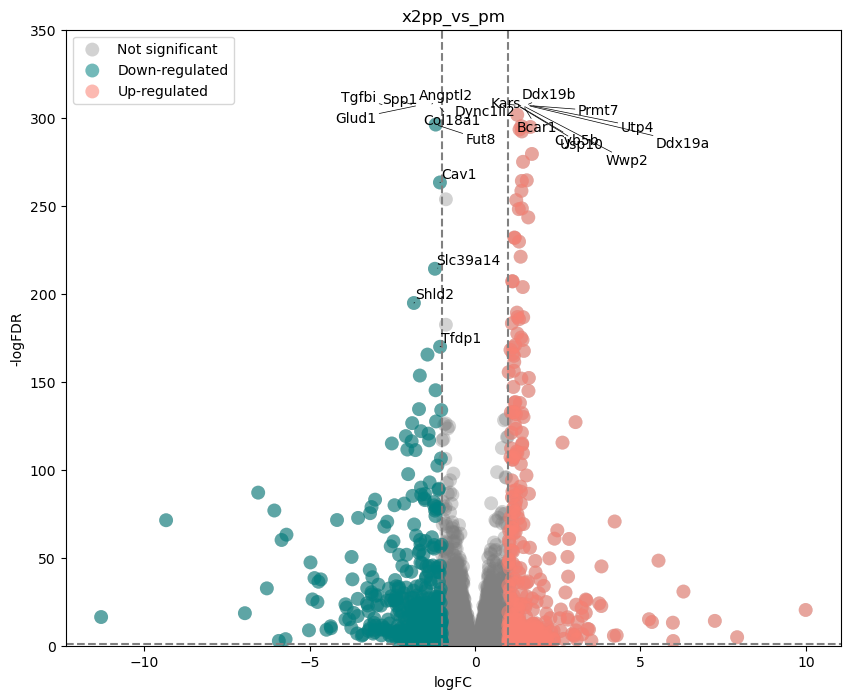

In [249]:
volcano_1(stat_res_CNPP_vs_CPPN_results_me,(10,8))
plt.title('x2pp_vs_pm')

### DEG list

In [250]:
filter_CNPPvsCPPN_me= filter(stat_res_CNPP_vs_CPPN_results_me)
filter_CNPPvsCPPN_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Spp1,3398.813263,-1.841832,0.038740,-47.543541,0.000000,0.000000
Dync1li2,4913.740773,1.382346,0.035197,39.274879,0.000000,0.000000
Usp10,10703.611061,1.280751,0.030061,42.605124,0.000000,0.000000
Tgfbi,856.449624,-2.731364,0.069112,-39.520892,0.000000,0.000000
Prmt7,4189.235969,1.565442,0.040768,38.399188,0.000000,0.000000
...,...,...,...,...,...,...
Acat3,9.060885,1.414953,0.622553,2.272822,0.023037,0.044262
Palm3,10.442527,-1.083516,0.476821,-2.272377,0.023064,0.044301
Cyp27b1,13.179665,-1.019992,0.449670,-2.268313,0.023310,0.044709


In [251]:
up_CNPPvsCPPN_me = up_reg(stat_res_CNPP_vs_CPPN_results_me)
up_CNPPvsCPPN_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Dync1li2,4913.740773,1.382346,0.035197,39.274879,0.000000,0.000000
Ccr7,43630.146479,12.120473,0.171434,70.700583,0.000000,0.000000
Zc3h18,5966.795600,1.334678,0.030938,43.139752,0.000000,0.000000
Slc7a6,5531.222535,1.349882,0.035263,38.280269,0.000000,0.000000
Rhou,9568.101077,1.128624,0.029821,37.846341,0.000000,0.000000
...,...,...,...,...,...,...
Rslcan18,6.642616,1.589895,0.697705,2.278750,0.022682,0.043669
Ttc16,14.093161,1.015875,0.446059,2.277446,0.022760,0.043793
Mthfs,10.385227,1.125557,0.494276,2.277182,0.022775,0.043817


In [252]:
down_CNPPvsCPPN_me = down_reg(stat_res_CNPP_vs_CPPN_results_me)
down_CNPPvsCPPN_me

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Spp1,3398.813263,-1.841832,0.038740,-47.543541,0.000000,0.000000
Tgfbi,856.449624,-2.731364,0.069112,-39.520892,0.000000,0.000000
Angptl2,6400.913699,-1.381467,0.035599,-38.806664,0.000000,0.000000
Glud1,20107.341279,-1.717234,0.030001,-57.239406,0.000000,0.000000
Col18a1,8378.533864,-1.113458,0.029397,-37.876794,0.000000,0.000000
...,...,...,...,...,...,...
Snora17,9.674247,-1.208111,0.527841,-2.288779,0.022092,0.042646
Gm10175,10.182617,-1.237405,0.543911,-2.275015,0.022905,0.044034
Palm3,10.442527,-1.083516,0.476821,-2.272377,0.023064,0.044301


### GSEA

In [253]:
gsea(up_CNPPvsCPPN_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Regulation Of Gene...,0.000000,0.717577,1.657140
1,GO_Biological_Process_2023__Regulation Of DNA-...,0.020408,0.576795,1.403895
2,GO_Biological_Process_2023__Negative Regulatio...,0.149660,0.575457,1.286064
3,GO_Biological_Process_2023__Regulation Of Tran...,0.183673,0.512641,1.241364
4,GO_Biological_Process_2023__Positive Regulatio...,0.187755,0.516164,1.198691


In [254]:
gsea(down_CNPPvsCPPN_me)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Negative Regulatio...,0.123580,-0.570604,-1.655619
1,GO_Biological_Process_2023__Negative Regulatio...,0.177131,-0.553073,-1.505188
2,GO_Biological_Process_2023__Positive Regulatio...,0.216264,-0.556497,-1.506451
3,GO_Biological_Process_2023__Negative Regulatio...,0.229995,-0.565800,-1.527265
4,GO_Biological_Process_2023__Regulation Of Apop...,0.244217,-0.496868,-1.413839
5,GO_Biological_Process_2023__Regulation Of Tran...,0.271188,-0.465800,-1.419899
6,GO_Biological_Process_2023__Regulation Of DNA-...,0.272905,-0.508543,-1.548923
7,GO_Biological_Process_2023__Regulation Of Cell...,0.305087,-0.488865,-1.366227
8,GO_Biological_Process_2023__Regulation Of Cell...,0.310093,-0.474024,-1.350219
9,GO_Biological_Process_2023__Positive Regulatio...,0.322056,-0.476752,-1.310913


### MgsigDb Hallmark

In [255]:
hallmark_enrichment(up_CNPPvsCPPN_me)

2024-03-05 10:16:52,193 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:52,194 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:52,198 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:52,209 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:52,457 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
18,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.000046,0.001845,Ifit2;Gbp3;Rtp4;Irf7;Oas1a;Ifi27;Parp14;Ifi44;...
19,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.000137,0.002742,Ifit2;Ifi27;Gbp3;Rtp4;Irf7;Psmb10;Oas3;Oas2;Xa...
39,HALLMARK_XENOBIOTIC_METABOLISM,0.026627,0.355023,Cyp2j6;Acox2;Lcat;Psmb10;Bcar1;Hsd11b1;Kars;Sl...


In [256]:
hallmark_enrichment(down_CNPPvsCPPN_me)

2024-03-05 10:16:52,471 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:52,473 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:52,477 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:52,489 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:52,786 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
13,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.000497,0.022853,Myl9;Lrrc15;Mmp3;Serpine1;Pfn2;Ecm1;Col1a1;Are...
5,HALLMARK_APICAL_SURFACE,0.004434,0.051992,Rtn4rl1;Mdga1;Atp6v0a4;Il2rb;Sulf2;Cx3cl1
27,HALLMARK_KRAS_SIGNALING_DN,0.003728,0.051992,Kcnmb1;Tnni3;Tgfb2;Cyp39a1;Fgfr3;Hc;Selenop;Cn...
28,HALLMARK_KRAS_SIGNALING_UP,0.004521,0.051992,Tph1;Ace;Btc;Plek2;Cxcl10;Ereg;Prrx1;Gng11;Prd...
6,HALLMARK_APOPTOSIS,0.012205,0.080207,Cav1;Tgfb2;Rnasel;Ereg;Txnip;Tnf;Egr3;Cd38;Cas...
23,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.010632,0.080207,Acvrl1;Cxcl10;Ccl7;Cntfr;Tnf;Cd38;Fas;Itgb3
40,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.010019,0.080207,Serpinb8;Slc2a6;Serpine1;Egr1;Cxcl10;Areg;Tnf;...
1,HALLMARK_ALLOGRAFT_REJECTION,0.019473,0.107529,Il11;Il27ra;Tgfb2;Ccl7;Ncf4;Ereg;Ly75;Il2rb;Tn...
15,HALLMARK_ESTROGEN_RESPONSE_LATE,0.021038,0.107529,Atp2b4;Cav1;Fdft1;Fgfr3;Flnb;Plaat3;Areg;Hr;Ce...
24,HALLMARK_INFLAMMATORY_RESPONSE,0.023561,0.108381,Serpine1;Cxcl10;Pdpn;Ereg;Ccl7;Il2rb;Nod2;Itgb...


# Gene Dependency Analysis

## CCR7 Dependent Genes

In [257]:
#(DEG in (ctrlvspp) & DEG(ctrlvspm) & Notsignification(ctrlvsx2pp)& DEG(x2ppvspp) & Notsignification(pmvspp)

In [258]:
index_intersection_cp_1 = filter_Ctrl_vs_CPPN_me.index.intersection(filter_Ctrl_vs_CPPP_me.index).intersection(not_significaiton_Ctrl_vs_CNPP_me.index).intersection(filter_CNPPvsCPPP_me.index).intersection(not_significaiton_CPPP_vs_CPPN_me.index)

In [259]:
DEG_cp_1 = filter_Ctrl_vs_CPPN_me.loc[index_intersection_cp_1]

In [260]:
DEG_cp_1 = DEG_cp_1.sort_values(by='log2FoldChange', ascending=False)
DEG_cp_1

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Ccr7,43630.146479,13.010838,0.167060,77.881271,0.000000e+00,0.000000e+00
Gfra4,15.540195,7.393741,1.076533,6.868108,6.505917e-12,3.975269e-11
Xlr4c,36.230017,6.191772,0.611935,10.118348,4.580833e-24,5.616203e-23
Gm29243,5.070312,5.493245,1.133545,4.846076,1.259276e-06,4.724792e-06
Pcdhgb1,84.133026,4.762365,0.219083,21.737677,9.035753e-105,6.478242e-103
...,...,...,...,...,...,...
Xkr5,51.204492,-6.432566,0.736736,-8.731169,2.520542e-18,2.336682e-17
Nudt7,7.219097,-6.575046,1.700431,-3.866694,1.103207e-04,3.208446e-04
Rnf43,338.127338,-7.170601,0.320048,-22.404751,3.537651e-111,2.761461e-109


In [261]:
save(DEG_cp_1,'ccr7_dependent_gene_list_1')

In [262]:
hallmark_enrichment(DEG_cp_1)

2024-03-05 10:16:52,876 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:52,878 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:52,881 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:52,892 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:53,142 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
22,HALLMARK_INFLAMMATORY_RESPONSE,0.000127,0.004946,Stab1;Ccr7;Serpine1;Lif;P2rx7;Ccl7;Ereg;Tnfaip...
1,HALLMARK_ALLOGRAFT_REJECTION,0.001943,0.037893,Stab1;Il11;Il27ra;Lif;Ly75;Ccl7;Ereg;Tnf;Cd80
24,HALLMARK_KRAS_SIGNALING_DN,0.007602,0.078704,Fgfr3;Hc;Selenop;Cntfr;Kcnn1;Lgals7;Cd80;Ccdc106
35,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.008072,0.078704,Slc2a6;Nfat5;Serpine1;Lif;Tnfaip6;Tnf;Cd80;Fos
25,HALLMARK_KRAS_SIGNALING_UP,0.026835,0.209315,Plat;Lif;Gpnmb;Ereg;Prdm1;Rgs16;Slpi
21,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.037122,0.241294,Tnf;Ccl7;Itgb3;Cntfr
8,HALLMARK_COAGULATION,0.048417,0.269754,Plat;Mmp3;Serpine1;C3;Itgb3


In [263]:
up(DEG_cp_1)

2024-03-05 10:16:53,219 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:53,222 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:53,225 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:53,233 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:53,494 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes


In [264]:
down(DEG_cp_1)

2024-03-05 10:16:53,568 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:53,570 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:53,573 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:53,582 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:53,823 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
19,HALLMARK_INFLAMMATORY_RESPONSE,0.000021,0.000651,Stab1;Serpine1;Lif;P2rx7;Ccl7;Ereg;Tnfaip6;Rgs...
1,HALLMARK_ALLOGRAFT_REJECTION,0.000616,0.009543,Stab1;Il11;Il27ra;Lif;Ly75;Ccl7;Ereg;Tnf
22,HALLMARK_KRAS_SIGNALING_UP,0.003592,0.037116,Plat;Lif;Gpnmb;Ereg;Prdm1;Rgs16;Slpi
7,HALLMARK_COAGULATION,0.011279,0.069933,Plat;Mmp3;Serpine1;C3;Itgb3
18,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.010673,0.069933,Tnf;Ccl7;Itgb3;Cntfr
27,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.013960,0.072128,Slc2a6;Serpine1;Lif;Tnfaip6;Tnf;Fos
15,HALLMARK_HEME_METABOLISM,0.041703,0.181050,Bcam;Aqp3;Mgst3;Osbp2;C3
21,HALLMARK_KRAS_SIGNALING_DN,0.046723,0.181050,Fgfr3;Hc;Selenop;Cntfr;Kcnn1


In [265]:
gsea(DEG_cp_1)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Regulation Of Tran...,0.241611,0.447279,1.194623
1,GO_Biological_Process_2023__Regulation Of DNA-...,0.335570,0.464705,1.294462


In [266]:
# DEG(ctrlvspp)& DEG(x2ppvspp)&DEG(ctrlvspm)

In [267]:
index_intersection_cp_2 = filter_Ctrl_vs_CPPP_me.index.intersection(filter_CNPPvsCPPP_me.index).intersection(filter_Ctrl_vs_CPPN_me.index)

In [268]:
DEG_cp_2 = filter_Ctrl_vs_CPPP_me.loc[index_intersection_cp_2]

In [269]:
DEG_cp_2 = DEG_cp_2.sort_values(by='log2FoldChange', ascending=False)
DEG_cp_2

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Ccr7,43630.146479,13.124035,0.164178,79.937992,0.000000e+00,0.000000e+00
Gfra4,15.540195,6.828145,1.060453,6.438892,1.203487e-10,3.296594e-10
Xlr4c,36.230017,6.694275,0.598193,11.190828,4.521908e-29,2.543839e-28
Col6a3,1475.136938,6.135354,0.105719,58.034495,0.000000e+00,0.000000e+00
Gm13652,57.118807,5.606225,0.294118,19.061163,5.308137e-81,7.948348e-80
...,...,...,...,...,...,...
Xkr5,51.204492,-6.876608,0.598280,-11.493968,1.414609e-30,8.286642e-30
Fkbp14,14.971266,-7.296791,1.197198,-6.094891,1.095121e-09,2.843865e-09
Rnf43,338.127338,-7.873749,0.285817,-27.548262,4.642740e-167,1.687246e-165


In [270]:
save(DEG_cp_2,'ccr7_dependent_gene_list_2')

In [271]:
hallmark_enrichment(DEG_cp_2)

2024-03-05 10:16:54,020 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:54,021 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:54,025 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:54,036 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 


,Term,P-value,Adjusted P-value,Genes
22,HALLMARK_INFLAMMATORY_RESPONSE,0.000010,0.000440,Stab1;Ccr7;Rtp4;Serpine1;Lif;P2rx7;Ccl7;Ereg;T...
37,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.000497,0.010694,Nfat5;Ifih1;Slc2a6;Serpine1;Lif;Tnfaip6;Cd69;T...
5,HALLMARK_APOPTOSIS,0.000881,0.011642,Mmp2;Plat;Tgfb2;Pmaip1;Rnasel;Ereg;Casp4;Tnf;C...
24,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.001083,0.011642,Ifih1;Rtp4;Itgb7;Ccl7;Cmpk2;Tnfaip6;Zbp1;Cd69;...
1,HALLMARK_ALLOGRAFT_REJECTION,0.003952,0.030811,Stab1;Il11;Il27ra;Tgfb2;Lif;Ccl7;Ncf4;Ereg;Ly7...
25,HALLMARK_KRAS_SIGNALING_DN,0.004299,0.030811,Kcnmb1;Tgfb2;Fgfr3;Hc;Selenop;Cntfr;Kcnn1;Ryr1...
26,HALLMARK_KRAS_SIGNALING_UP,0.005067,0.031125,Plat;Tph1;Rgs16;Lif;Ereg;Prrx1;Prdm1;Prkg2;Gpn...
21,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.006325,0.033996,Acvrl1;Ccl7;Cntfr;Tnf;Osmr;Tlr2;Itgb3
29,HALLMARK_MYOGENESIS,0.013977,0.066777,Myom2;Myh3;Mylk;Col15a1;Col6a3;Sod3;Ryr1;Ckmt2...


In [272]:
up(DEG_cp_2)

2024-03-05 10:16:54,595 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:54,596 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:54,600 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:54,609 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:54,863 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
17,HALLMARK_KRAS_SIGNALING_DN,0.044301,0.718743,Cd80;Ryr1;Lgals7;Ccdc106
21,HALLMARK_MYOGENESIS,0.047916,0.718743,Col6a3;Ckmt2;Ryr1;Mylk


In [355]:
down(DEG_cp_2)

2024-03-05 10:20:20,335 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:20:20,337 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:20:20,341 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:20:20,351 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:20:20,626 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
19,HALLMARK_INFLAMMATORY_RESPONSE,6.112661e-07,0.000022,Stab1;Rtp4;Serpine1;Lif;P2rx7;Ccl7;Ereg;Tnfaip6;Cd69;Itgb3;Osmr;Tlr2;Btg2;Rgs16;Sele;Pde4b
5,HALLMARK_APOPTOSIS,4.392273e-05,0.000543,Mmp2;Plat;Tgfb2;Pmaip1;Rnasel;Ereg;Casp4;Tnf;Casp1;Btg2;Lgals3;Cd69
21,HALLMARK_INTERFERON_GAMMA_RESPONSE,4.528290e-05,0.000543,Ifih1;Rtp4;Itgb7;Ccl7;Cmpk2;Tnfaip6;Zbp1;Cd69;Pla2g4a;Casp4;Casp1;Ptgs2;Pde4b
30,HALLMARK_TNFA_SIGNALING_VIA_NFKB,2.921620e-04,0.002629,Slc2a6;Ifih1;Serpine1;Lif;Tnfaip6;Cd69;Tnf;Tlr2;Btg2;Fos;Ptgs2;Pde4b
1,HALLMARK_ALLOGRAFT_REJECTION,9.346289e-04,0.006198,Stab1;Il11;Il27ra;Tgfb2;Lif;Ccl7;Ncf4;Ereg;Ly75;Tnf;Tlr2
18,HALLMARK_IL6_JAK_STAT3_SIGNALING,1.070319e-03,0.006198,Acvrl1;Ccl7;Cntfr;Tnf;Osmr;Tlr2;Itgb3
23,HALLMARK_KRAS_SIGNALING_UP,1.205141e-03,0.006198,Plat;Tph1;Rgs16;Lif;Ereg;Prrx1;Prdm1;Prkg2;Gpnmb;Slpi;Ptgs2
8,HALLMARK_COMPLEMENT,8.190668e-03,0.036858,Plat;Serpine1;F5;Casp4;Pla2g4a;Lipa;Casp1;Lgals3;C3
22,HALLMARK_KRAS_SIGNALING_DN,3.073999e-02,0.122960,Kcnmb1;Tgfb2;Fgfr3;Hc;Selenop;Cntfr;Kcnn1;Btg2
7,HALLMARK_COAGULATION,4.192656e-02,0.150936,Mmp2;Plat;Mmp3;Serpine1;C3;Itgb3


In [354]:
pd.set_option('display.max_colwidth', None)

In [274]:
gsea(DEG_cp_2)

,Term,fdr,es,nes
0,GO_Biological_Process_2023__Regulation Of Gene...,0.156627,0.548589,1.610590
1,GO_Biological_Process_2023__Positive Regulatio...,0.240826,-0.440754,-1.392447
2,GO_Biological_Process_2023__Positive Regulatio...,0.323394,-0.434621,-1.216394
3,GO_Biological_Process_2023__Regulation Of DNA-...,0.397590,0.406761,1.319547
4,GO_Biological_Process_2023__Negative Regulatio...,0.463855,0.470144,1.372344
5,GO_Biological_Process_2023__Regulation Of Cell...,0.502294,-0.334509,-0.979680
6,GO_Biological_Process_2023__Positive Regulatio...,0.704819,0.297659,0.826757
7,GO_Biological_Process_2023__Positive Regulatio...,0.765921,0.307989,0.848888
8,GO_Biological_Process_2023__Positive Regulatio...,0.773092,0.320547,0.911623
9,GO_Biological_Process_2023__Regulation Of Cell...,0.848193,0.357314,0.953034


## PDPN Dependent Genes 

In [275]:
#(DEG in (ctrlvspp) & DEG(ctrlvsx2pp) & DEG(ppvspm))

In [276]:
index_intersection_pp_1 = filter_Ctrl_vs_CNPP_me.index.intersection(filter_Ctrl_vs_CPPP_me.index).intersection(filter_CPPPvsCPPN_me.index)

In [277]:
DEG_pp_1 = filter_Ctrl_vs_CNPP_me.loc[index_intersection_pp_1]

In [278]:
DEG_pp_1 = DEG_pp_1.sort_values(by='log2FoldChange', ascending=False)
DEG_pp_1

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Pdpn,370.144888,7.790075,0.347401,22.423851,2.303646e-111,4.675338e-109
Magea10,31.644778,2.775995,0.216957,12.795119,1.745843e-37,4.681129e-36
Col6a3,1475.136938,2.773416,0.133445,20.783256,6.135342e-96,8.993048e-94
Trib2,82.037684,2.742641,0.183524,14.944314,1.696290e-50,7.361005e-49
Slco2b1,55.974094,2.399217,0.164583,14.577581,3.900969e-48,1.593238e-46
...,...,...,...,...,...,...
Oas3,883.958052,-3.791481,0.132665,-28.579392,1.211936e-179,5.921427e-177
Oas1a,402.763145,-3.842610,0.108448,-35.432709,5.356090e-275,8.832193e-272
Gm8995,44.555324,-4.031080,0.422537,-9.540187,1.425749e-21,1.838561e-20


In [279]:
hallmark_enrichment(DEG_pp_1)

2024-03-05 10:16:55,363 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:55,364 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:55,368 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:55,379 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:55,646 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
19,HALLMARK_INTERFERON_GAMMA_RESPONSE,4.490378e-11,1.257306e-09,Ifih1;Ifit2;Gbp3;Rtp4;Ifit3;Irf7;Oas3;Cd274;Cm...
18,HALLMARK_INTERFERON_ALPHA_RESPONSE,2.817898e-09,3.945058e-08,Ifih1;Ifit2;Gbp3;Rtp4;Ifit3;Irf7;Cmpk2;Oas1a;P...


In [280]:
save(DEG_pp_1,'pdpn_dependent_gene_list_1')

In [281]:
up(DEG_pp_1)

2024-03-05 10:16:55,698 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:55,701 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:55,704 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:55,711 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:55,980 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
1,HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.013494,0.175423,Aldoc;Acat2


In [282]:
down(DEG_pp_1)

2024-03-05 10:16:56,031 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:56,033 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:56,036 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:56,044 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:56,303 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
17,HALLMARK_INTERFERON_GAMMA_RESPONSE,3.341241e-13,8.018979e-12,Ifih1;Ifit2;Gbp3;Rtp4;Ifit3;Irf7;Oas3;Cd274;Cm...
16,HALLMARK_INTERFERON_ALPHA_RESPONSE,1.184747e-10,1.421696e-09,Ifih1;Ifit2;Gbp3;Rtp4;Ifit3;Irf7;Cmpk2;Oas1a;P...


gsea(DEG_pp_1) #too less genes 

In [283]:
# DEG(ctrlvspp)& DEG(x2ppvspp)&Notsignificaiton(ctrlvspm)

index_intersection_pp_2 = filter_Ctrl_vs_CNPP_me.index.intersection(filter_Ctrl_vs_CPPP_me.index).intersection(not_significaiton_Ctrl_vs_CPPN_me.index)

DEG_pp_2 = filter_Ctrl_vs_CNPP_me.loc[index_intersection_pp_2]

DEG_pp_2 = DEG_pp_2.sort_values(by='log2FoldChange', ascending=False)
DEG_pp_2

hallmark_enrichment(DEG_pp_2)

## CCR7&PDPN Dependent Genes

In [284]:
#(DEG in (ctrlvspp) & Notsignification(ctrlvsx2pp) & Notsignification(ctrlvspm)& DEG in (pmvspp)& DEG in (x2ppvspp)

In [285]:
index_intersection_dp_1 = filter_Ctrl_vs_CPPP_me.index.intersection(not_significaiton_Ctrl_vs_CPPN_me.index).intersection(not_significaiton_Ctrl_vs_CNPP_me.index).intersection(filter_CNPPvsCPPP_me.index).intersection(filter_CPPPvsCPPN_me.index)

In [286]:
DEG_dp_1 = filter_Ctrl_vs_CPPP_me.loc[index_intersection_dp_1]

In [287]:
DEG_dp_1 = DEG_dp_1.sort_values(by='log2FoldChange', ascending=False)
DEG_dp_1

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Gm49701,6.121381,2.507660,0.398477,6.293113,3.111622e-10,8.341500e-10
Prss42,44.526177,2.483465,0.192656,12.890650,5.081363e-38,3.655035e-37
Gm43800,65.633332,2.181996,0.149361,14.608864,2.465942e-48,2.203977e-47
Fam83a,19.390457,1.792770,0.221575,8.091029,5.916268e-16,2.092985e-15
Smagp,69.136560,1.673925,0.114466,14.623761,1.981451e-48,1.776975e-47
...,...,...,...,...,...,...
Abcc8,8.526319,-3.161546,0.459613,-6.878714,6.039521e-12,1.766593e-11
Aig1,88.179043,-3.596011,0.171708,-20.942541,2.194395e-97,4.088766e-96
Il7,53.009992,-3.707784,0.231754,-15.998807,1.302468e-57,1.375673e-56


In [288]:
save(DEG_dp_1,'ccr7_pdpn_dependent_gene_list_1')

In [289]:
hallmark_enrichment(DEG_dp_1)

2024-03-05 10:16:56,371 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:56,373 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:56,377 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:56,385 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:56,635 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
15,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.000300,0.007490,Trim14;Rsad2;Ly6e;C1s1;Il7
16,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.001100,0.013746,Trim14;Rsad2;Ly6e;C1s1;Lcp2;Il7
7,HALLMARK_ESTROGEN_RESPONSE_EARLY,0.037243,0.310355,Ablim1;Bcl11b;Mapt;Car12


In [290]:
down(DEG_dp_1)

2024-03-05 10:16:56,672 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:56,675 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:56,678 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:56,687 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 


,Term,P-value,Adjusted P-value,Genes
15,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.000250,0.006260,Trim14;Rsad2;C1s1;Ly6e;Il7
16,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.000896,0.011203,Trim14;Rsad2;C1s1;Ly6e;Lcp2;Il7


In [291]:
up(DEG_dp_1)

2024-03-05 10:16:57,165 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:57,167 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:57,171 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:57,176 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:57,384 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
0,HALLMARK_ESTROGEN_RESPONSE_EARLY,0.045931,0.045931,Bcl11b


gsea(DEG_dp_1) # gene list is too short

In [292]:
## DEG(ctrlvspp)&Notsignificaiton(pmvspp)&Notsignificaiton(x2ppvspp)

index_intersection_dp_2 = filter_Ctrl_vs_CPPP_me.index.intersection(not_significaiton_CPPP_vs_CNPP_me.index).intersection(not_significaiton_CPPP_vs_CPPN_me.index)

DEG_dp_2 = filter_Ctrl_vs_CPPP_me.loc[index_intersection_dp_2]

DEG_dp_2 = DEG_dp_2.sort_values(by='log2FoldChange', ascending=False)
DEG_dp_2

hallmark_enrichment(DEG_dp_2)

## Cooperative

In [293]:
# Down(ctrlvspp)& Down(ctrlvspm)& Down (ctrlvsx2pp) log2FC of down(ctrlvspp) min
# Up(ctrlvspp)& Up(ctrlvspm)& up(ctrlvsx2pp) log2FC of up(ctrlvspp) max

### Down

In [294]:
index_intersection_down_1 = down_Ctrl_vs_CPPP_me.index.intersection(down_Ctrl_vs_CPPN_me.index).intersection(down_Ctrl_vs_CNPP_me.index)

In [295]:
DEG_down_1 = pd.DataFrame()

In [296]:
for idx in index_intersection_down_1:
    if down_Ctrl_vs_CPPP_me.loc[idx, 'log2FoldChange'] == min(down_Ctrl_vs_CPPP_me.loc[idx, 'log2FoldChange'], down_Ctrl_vs_CPPN_me.loc[idx, 'log2FoldChange'], down_Ctrl_vs_CNPP_me.loc[idx, 'log2FoldChange']):
        row_to_append = down_Ctrl_vs_CPPP_me.loc[idx:idx]
        DEG_down_1 = pd.concat([DEG_down_1, row_to_append], ignore_index=False)

In [297]:
DEG_down_1

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Fam107b,219.559056,-3.847277,0.096613,-39.821647,0.000000e+00,0.000000e+00
Lipa,357.481799,-2.570653,0.059986,-42.854215,0.000000e+00,0.000000e+00
Cd68,724.318463,-2.341204,0.064101,-36.523468,4.704465e-292,4.401511e-290
Slfn2,209.107532,-3.776623,0.106963,-35.307597,4.489994e-273,3.484235e-271
Irf9,744.642095,-1.826197,0.055967,-32.630042,1.538114e-233,8.978231e-232
...,...,...,...,...,...,...
Snai2,9.210914,-2.022021,0.354539,-5.703241,1.175504e-08,2.871181e-08
Myom2,5.521485,-6.389904,1.220508,-5.235444,1.645886e-07,3.741603e-07
Ccdc40,7.837849,-1.784609,0.351497,-5.077163,3.831130e-07,8.507029e-07


In [298]:
save(DEG_down_1,'cooperative_down')

In [299]:
hallmark_enrichment(DEG_down_1)

2024-03-05 10:16:57,468 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:57,471 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:57,474 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:57,482 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:57,732 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
14,HALLMARK_INTERFERON_GAMMA_RESPONSE,1.122180e-10,2.356578e-09,Ifih1;Gbp3;Rtp4;Ddx60;Isg15;Cd274;Cmpk2;Zbp1;I...
13,HALLMARK_INTERFERON_ALPHA_RESPONSE,1.213198e-09,1.273858e-08,Ifih1;Gbp3;Rtp4;Ddx60;Isg15;Cmpk2;Irf9;Ifi44;U...
1,HALLMARK_APOPTOSIS,1.306317e-02,9.144219e-02,Rnasel;Pmaip1;Cd69;Mmp2


### Up

In [300]:
index_intersection_up_1 = up_Ctrl_vs_CPPP_me.index.intersection(up_Ctrl_vs_CPPN_me.index).intersection(up_Ctrl_vs_CNPP_me.index)

In [301]:
DEG_up_1 = pd.DataFrame()

In [302]:
for idx in index_intersection_up_1:
    if up_Ctrl_vs_CPPP_me.loc[idx, 'log2FoldChange'] == max(up_Ctrl_vs_CPPP_me.loc[idx, 'log2FoldChange'], up_Ctrl_vs_CPPN_me.loc[idx, 'log2FoldChange'], up_Ctrl_vs_CNPP_me.loc[idx, 'log2FoldChange']):
        row_to_append = up_Ctrl_vs_CPPP_me.loc[idx:idx]
        DEG_up_1 = pd.concat([DEG_up_1, row_to_append], ignore_index=False)

In [303]:
DEG_up_1

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
symbol,,,,,,
Eya2,356.412444,3.081041,0.076142,40.464200,0.000000e+00,0.000000e+00
Bmf,865.208289,1.574443,0.037101,42.436506,0.000000e+00,0.000000e+00
Abcc3,1552.637302,1.842217,0.035348,52.117061,0.000000e+00,0.000000e+00
Col6a3,1475.136938,6.135354,0.105719,58.034495,0.000000e+00,0.000000e+00
Kif26a,426.773300,2.292604,0.057637,39.776533,0.000000e+00,0.000000e+00
Mylk,632.612244,3.649089,0.058623,62.246316,0.000000e+00,0.000000e+00
Acp5,311.285860,2.443309,0.066919,36.511478,7.291178e-292,6.773607e-290
Nos1,459.007599,2.126980,0.059991,35.454910,2.436911e-275,1.925013e-273
Atp2c2,283.142914,2.456204,0.075635,32.474646,2.431817e-231,1.400896e-229


In [304]:
save(DEG_up_1,'cooperative_up')

In [305]:
hallmark_enrichment(DEG_up_1)

2024-03-05 10:16:57,809 [INFO] User defined gene sets is given: /Users/zhiwang/Desktop/Master Thesis Project/Bioinformatics/Bulk RNA sc/mh.all.v2023.2.Mm.symbols.gmt
2024-03-05 10:16:57,812 [INFO] Run: mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:57,816 [INFO] Background is not set! Use all 4289 genes in mh.all.v2023.2.Mm.symbols.gmt.
2024-03-05 10:16:57,825 [INFO] Save enrichment results for mh.all.v2023.2.Mm.symbols.gmt 
2024-03-05 10:16:58,060 [INFO] Done.


,Term,P-value,Adjusted P-value,Genes
14,HALLMARK_MYOGENESIS,0.010062,0.20125,Col6a3;Ckmt2;Nos1;Mylk


# Heatmap

In [306]:
order_req = ['ctrl_2','ctrl_3','ctrl_1','ctrl_6','ctrl_8','ctrl_7','ctrl_5','ctrl_4','Pm_1','Pm_3','Pm_2','Pm_4',
            'X2_Pp_2','X2_Pp_4','X2_Pp_1','X2_Pp_3','Pp_8','Pp_4','Pp_1','Pp_7','Pp_3','Pp_2','Pp_5','Pp_6']

## Interferon gamma and alpha

In [307]:
dds_me.layers['log1p']=np.log1p(dds_me.layers['normed_counts'])

In [308]:
GOIs_IFN = ['Cd274','Parp14','Rtp4','Ifi44','Ifit2','Oas2','Usp18',
       'Ifih1','Oas3','Xaf1','Irf7','Gbp3','Oas1a','C1s1','Ly6e','Il7','Rsad2','Ccr7','Pdpn','Oasl2','H2-D1']

In [309]:
#GOIs.sort()

In [310]:
order_fol = ['Il7','Oas2','Cd274','Gbp3','Xaf1','Parp14','Ifih1','Rtp4','Ifi44','Usp18','Rsad2',
            'Oasl2','Irf7','Oas1a','Oas3','Ifit2','C1s1','H2-D1','Ccr7','Pdpn']

In [311]:
results = []
for gene in GOIs_IFN:
    indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
    for index in indices:
        results.append({'Symbol': gene, 'Index': index})
GOI_df_IFN = pd.DataFrame(results)

In [312]:
GOI_df_IFN

,Symbol,Index
0,Cd274,ENSMUSG00000016496
1,Parp14,ENSMUSG00000034422
2,Rtp4,ENSMUSG00000033355
3,Ifi44,ENSMUSG00000028037
4,Ifit2,ENSMUSG00000045932
5,Oas2,ENSMUSG00000032690
6,Usp18,ENSMUSG00000030107
7,Ifih1,ENSMUSG00000026896
8,Oas3,ENSMUSG00000032661
9,Xaf1,ENSMUSG00000040483


In [313]:
GOI_df_IFN = GOI_df_IFN.set_index('Index')

In [314]:
dds_GOI_IFN = dds_me[:,GOI_df_IFN.index]
dds_GOI_IFN

View of AnnData object with n_obs × n_vars = 24 × 21
    obs: 'Genotype', 'Replicate', 'Batch'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p'

In [315]:
heatmap_IFN = pd.DataFrame(dds_GOI_IFN.layers['log1p'].T,
                            index=dds_GOI_IFN.var_names, columns = dds_GOI_IFN.obs_names)

In [316]:
heatmap_IFN.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
heatmap_IFN.set_index('symbol',inplace = True)

In [317]:
heatmap_IFN = heatmap_IFN.loc[order_fol]

In [318]:
heatmap_IFN

,ctrl_5,ctrl_6,ctrl_7,ctrl_8,Pp_5,Pp_6,Pp_7,Pp_8,X2_Pp_1,X2_Pp_2,...,ctrl_3,ctrl_4,Pp_1,Pp_2,Pp_3,Pp_4,Pm_1,Pm_2,Pm_3,Pm_4
symbol,,,,,,,,,,,,,,,,,,,,,
Il7,4.304043,4.119050,4.480075,4.219207,2.168417,2.335086,1.871370,2.001578,4.339597,4.300067,...,4.453802,4.369826,1.541000,1.887379,1.964018,1.088640,4.338359,4.330274,4.311974,4.411843
Oas2,6.086920,5.938555,5.950911,6.166583,3.132993,3.429367,3.381068,2.768520,3.094424,2.291133,...,5.934229,6.206269,3.722359,3.367648,3.239135,3.163687,5.615075,5.682794,5.737356,5.496965
Cd274,4.823929,4.959415,4.807125,4.839036,2.948134,3.152429,3.247943,2.833321,3.513624,3.348719,...,4.757251,5.005006,3.136170,3.367648,3.155681,3.540783,3.746912,3.944531,4.213301,3.929928
Gbp3,5.246692,5.055395,5.065210,5.149100,3.860026,3.596087,3.349411,3.496618,3.829137,3.576178,...,5.038801,5.310714,3.442703,3.717174,3.352553,3.352820,4.682817,4.455457,4.346603,4.179743
Xaf1,5.631348,5.562356,5.393862,5.695831,3.832457,3.902332,3.826328,3.726607,3.849738,3.620396,...,5.676316,5.661010,4.073986,3.993039,3.891860,3.674261,4.932073,4.925518,4.751533,4.724071
Parp14,5.642823,5.585705,5.592529,5.512895,4.142427,4.442335,4.008345,4.174499,4.364277,4.321751,...,5.434074,5.455756,3.975691,3.975668,3.870798,3.897329,4.892362,5.177670,4.872555,4.791694
Ifih1,5.687451,5.538448,5.556561,5.572828,3.542674,3.488083,3.525864,3.496618,4.400190,4.332419,...,5.607567,5.749734,3.382244,3.596753,3.684121,3.596330,4.864984,5.023507,4.986500,4.488495
Rtp4,5.962384,5.897167,5.733954,5.972160,2.632420,2.421557,2.751057,3.005791,4.000843,3.598532,...,5.817693,6.056098,3.136170,2.979271,3.064622,2.930238,4.648948,4.627950,4.443828,4.443212
Ifi44,6.049642,5.827163,5.865930,6.119302,3.579342,3.543543,3.007669,3.394618,3.808103,3.430424,...,5.847458,6.103563,3.095498,3.112381,2.853079,3.121155,4.864984,5.205843,5.015976,4.865209


In [319]:
heatmap_IFN = heatmap_IFN.loc[order_fol]

In [320]:
heatmap_IFN = heatmap_IFN[order_req]

In [321]:
max_value = heatmap_IFN.max().max()
min_value = heatmap_IFN.min().min()

In [322]:
values = heatmap_IFN.values.flatten()

In [323]:
overall_median = np.median(values)

In [324]:
print(max_value)
print(min_value)
print(overall_median)

11.50677224426723
0.0
5.031271088125328


In [325]:
palette_br = sns.diverging_palette(h_neg=240, h_pos=0, s=450, l=15, n=300,as_cmap=True)

In [326]:
cbar_ticks = [0,11.50677224426723]
cbar_ticklabels = ["-","+"] 

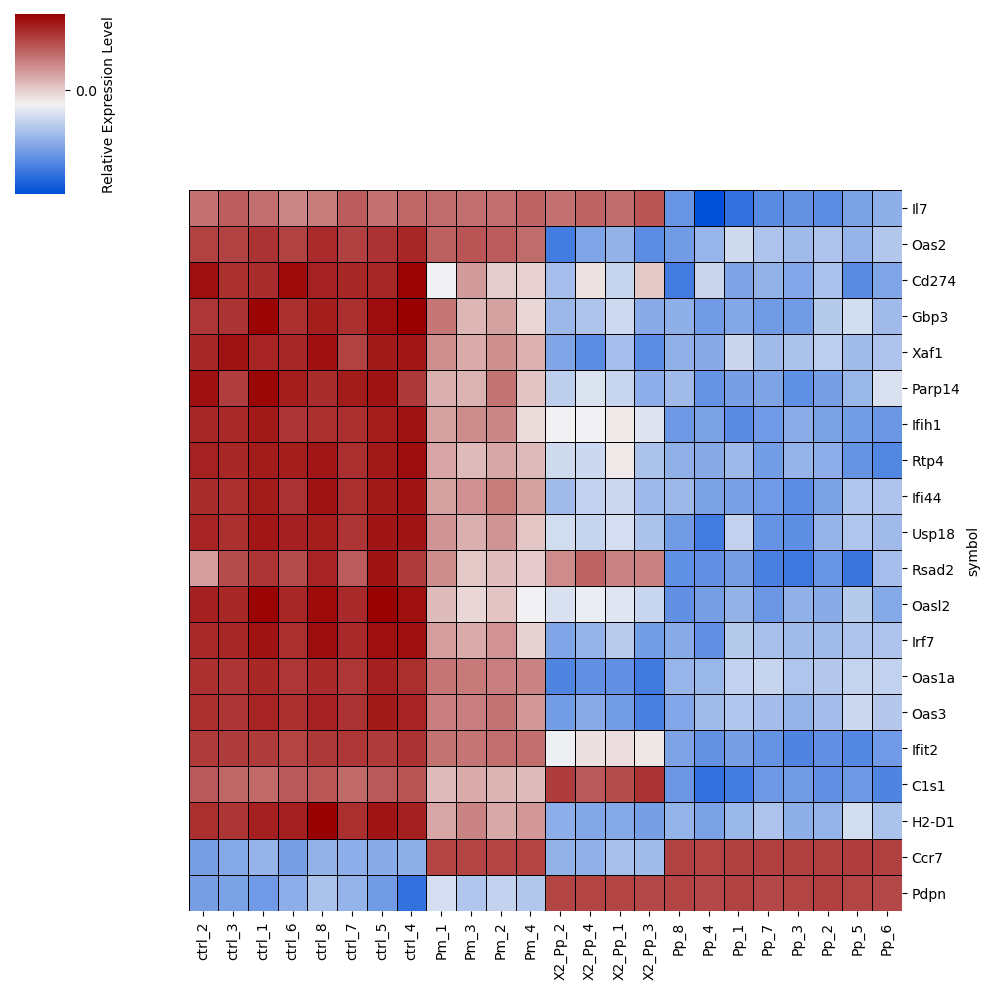

In [471]:
hm_IFN = sns.clustermap(heatmap_IFN,cmap=palette_br,col_cluster=False,row_cluster=False,cbar_kws={"label": "Relative Expression Level", "ticks": cbar_ticks},linewidths=0.5,
                      linecolor='black',z_score=0)

#hm_IFN.cax.yaxis.set_major_locator(FixedLocator(cbar_ticks))
#hm_IFN.cax.set_yticklabels(cbar_ticklabels)

plt.show()
hm_IFN.savefig('hm_IFN.png', transparent=True)

## Dotplot

In [328]:
heatmap_IFN_renamed = heatmap_IFN.copy()
heatmap_IFN_renamed = heatmap_IFN_renamed.stack().reset_index()  
heatmap_IFN_renamed.columns = ['Gene', 'Sample_name', 'Expression']  

In [329]:
heatmap_IFN_renamed

,Gene,Sample_name,Expression
0,Il7,ctrl_2,4.289015
1,Il7,ctrl_3,4.453802
2,Il7,ctrl_1,4.332204
3,Il7,ctrl_6,4.119050
4,Il7,ctrl_8,4.219207
...,...,...,...
475,Pdpn,Pp_7,6.537991
476,Pdpn,Pp_3,6.596141
477,Pdpn,Pp_2,6.664858
478,Pdpn,Pp_5,6.612666


In [449]:
import matplotlib.colors as mcolors

In [457]:
cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "red"])

In [458]:
min_expr = heatmap_IFN_renamed['Expression'].min()
max_expr = heatmap_IFN_renamed['Expression'].max()

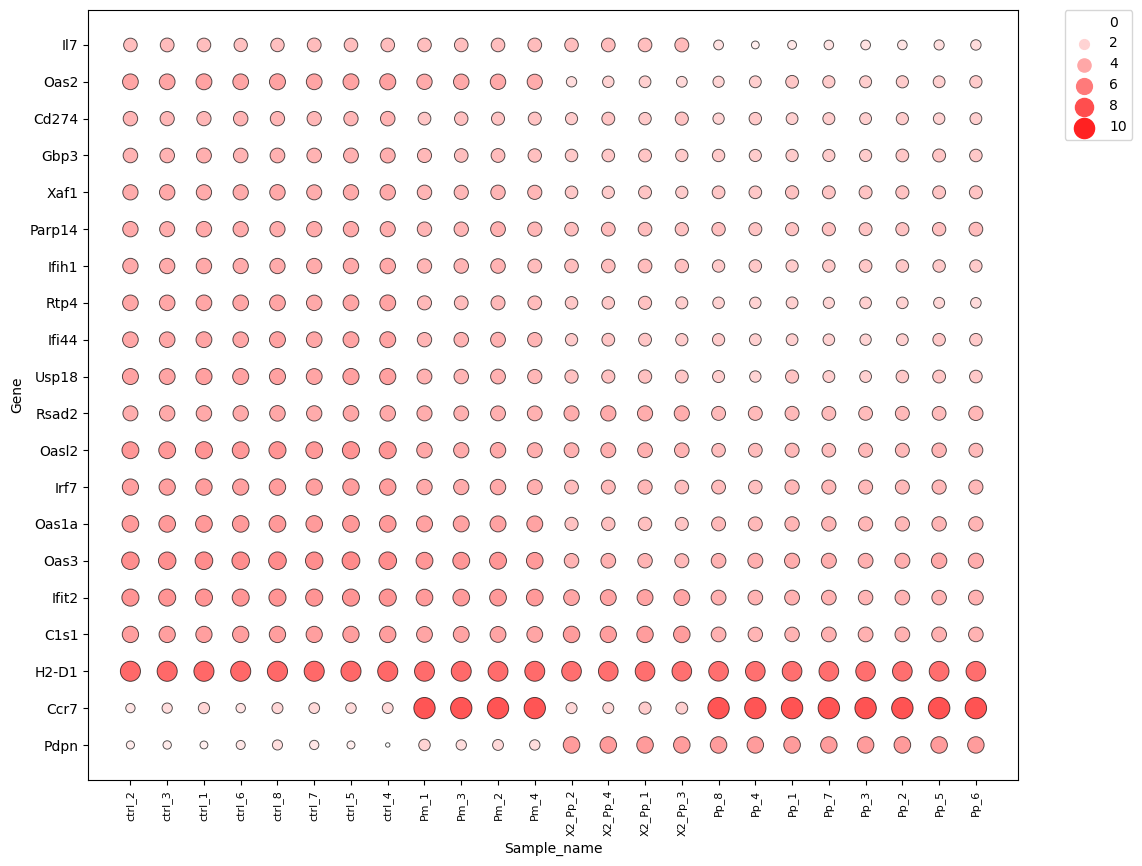

In [467]:
fig, ax = plt.subplots(figsize=(12, 10))
dotpot=sns.scatterplot(data=heatmap_IFN_renamed, x='Sample_name', y='Gene', size='Expression', sizes=(10,240),hue='Expression',alpha=0.68,
                      palette=cmap, edgecolor="black",hue_norm=(min_expr, max_expr))
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
fig.savefig('dotpot_IFN.png', transparent=True)

## GOIs

In [556]:
GOIs = ['Esr1','Erbb3','Pgrmc1','Ccr7','Pdpn']

In [557]:
result = []
for gene in GOIs:
    indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
    #print(indices)
    for index in indices:
        result.append({'Symbol': gene, 'Index': index})
GOI_df= pd.DataFrame(result)

In [558]:
GOI_df

,Symbol,Index
0,Esr1,ENSMUSG00000019768
1,Erbb3,ENSMUSG00000018166
2,Pgrmc1,ENSMUSG00000006373
3,Ccr7,ENSMUSG00000037944
4,Pdpn,ENSMUSG00000028583


In [559]:
GOI_df = GOI_df.set_index('Index')

In [560]:
dds_GOI = dds_me[:,GOI_df.index]
dds_GOI

View of AnnData object with n_obs × n_vars = 24 × 5
    obs: 'Genotype', 'Replicate', 'Batch'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p'

In [561]:
heatmap_GOI = pd.DataFrame(dds_GOI.layers['log1p'].T,
                            index=dds_GOI.var_names, columns = dds_GOI.obs_names)

In [562]:
heatmap_GOI.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
heatmap_GOI.set_index('symbol',inplace = True)

In [563]:
heatmap_GOI = heatmap_GOI[order_req]

In [564]:
heatmap_GOI = heatmap_GOI.loc[GOIs]

In [565]:
heatmap_GOI

,ctrl_2,ctrl_3,ctrl_1,ctrl_6,ctrl_8,ctrl_7,ctrl_5,ctrl_4,Pm_1,Pm_3,...,X2_Pp_1,X2_Pp_3,Pp_8,Pp_4,Pp_1,Pp_7,Pp_3,Pp_2,Pp_5,Pp_6
symbol,,,,,,,,,,,,,,,,,,,,,
Esr1,4.255587,4.095973,3.843233,4.199125,4.161258,4.342012,4.360450,4.221930,3.560811,3.368446,...,3.392425,3.527537,1.435171,1.597459,1.541000,1.871370,1.402157,2.019654,2.008709,2.019060
Erbb3,6.737401,6.645444,6.709457,6.713443,6.781402,6.711992,6.760443,6.688390,6.053729,6.256459,...,6.831266,6.744473,5.919545,5.882199,5.895337,5.992620,5.823150,5.730679,5.852802,5.927317
Pgrmc1,7.444071,7.340340,7.418575,7.374977,7.376499,7.430727,7.378086,7.440633,7.269723,7.344778,...,7.222482,7.153734,7.247717,7.163561,7.220287,7.225759,7.167062,7.229188,7.264420,7.148183
Ccr7,1.756646,2.231157,2.786577,1.812736,2.666945,2.516026,2.366644,2.553549,11.275871,11.325180,...,3.359682,3.150623,11.366115,11.312816,11.416490,11.426503,11.395677,11.416217,11.506772,11.420221
Pdpn,1.222742,1.327131,1.108579,1.629584,2.158115,1.747699,1.146453,0.000000,2.944210,2.278336,...,6.618933,6.594134,6.599803,6.533244,6.650769,6.537991,6.596141,6.664858,6.612666,6.536082


In [566]:
max_value_1 = heatmap_GOI.max().max()
min_value_1 = heatmap_GOI.min().min()

In [567]:
values_1 = heatmap_GOI.values.flatten()

In [568]:
overall_median_1 = np.median(values_1)

In [569]:
print(max_value_1,min_value_1,overall_median_1)

11.50677224426723 0.0 6.39485162745331


In [570]:
#cbar_ticks_1 = [0,11.50677224426723]  # 设置色彩条的标记位置
#cbar_ticklabels_1 = ["-","+"] 

In [571]:
#palette = sns.diverging_palette(h_neg=120, h_pos=0, s=85, l=40, n=256, as_cmap=True)

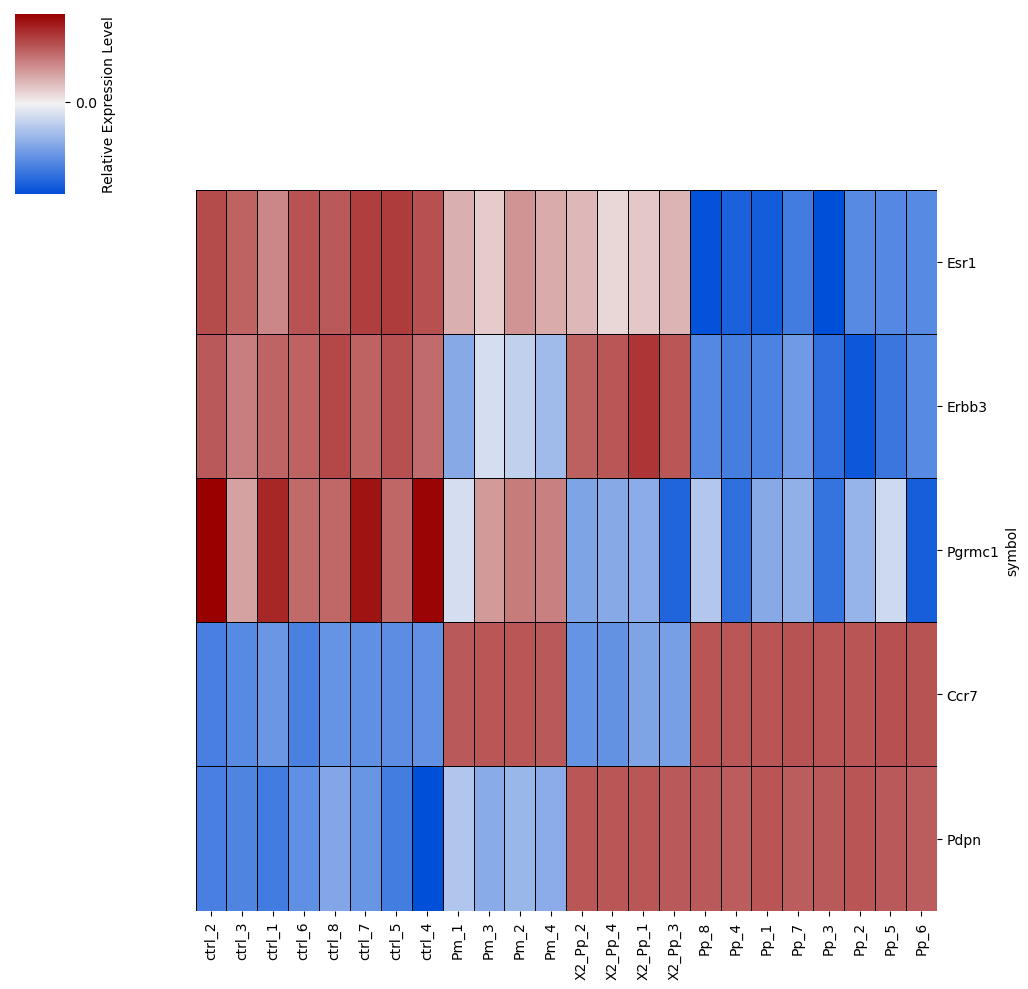

In [572]:
hm_GOI= sns.clustermap(heatmap_GOI,cmap=palette_br,row_cluster=False,col_cluster=False,cbar_kws={"label": "Relative Expression Level","ticks": cbar_ticks_1},linewidths=0.5,
                      linecolor='black',z_score=0)

#hm_GOI.cax.yaxis.set_major_locator(FixedLocator(cbar_ticks_1))
#hm_GOI.cax.set_yticklabels(cbar_ticklabels_1)

plt.setp(hm_GOI.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

hm_GOI.savefig('hm_GOI.png', transparent=True)

plt.show()

## Collagens only

In [493]:
collagens = ['Esr1','Erbb3','Col5a1','Col6a1','Col6a2','Col16a1','Col4a2','Col6a3','Ccr7','Pdpn']

In [494]:
result_collagens = []
for gene in collagens:
    indices = combo_df_2[combo_df_2['symbol_1'] == gene].index.tolist()
    #print(indices)
    for index in indices:
        result_collagens.append({'Symbol': gene, 'Index': index})
collagens_df= pd.DataFrame(result_collagens)

In [495]:
collagens_df = collagens_df.set_index('Index')

In [496]:
dds_collagens = dds_me[:,collagens_df.index]
dds_collagens

View of AnnData object with n_obs × n_vars = 24 × 10
    obs: 'Genotype', 'Replicate', 'Batch'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p'

In [497]:
heatmap_collagens = pd.DataFrame(dds_collagens.layers['log1p'].T,
                            index=dds_collagens.var_names, columns = dds_collagens.obs_names)

In [498]:
heatmap_collagens.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
heatmap_collagens.set_index('symbol',inplace = True)

In [499]:
heatmap_collagens = heatmap_collagens[order_req]
heatmap_collagens = heatmap_collagens.loc[collagens]

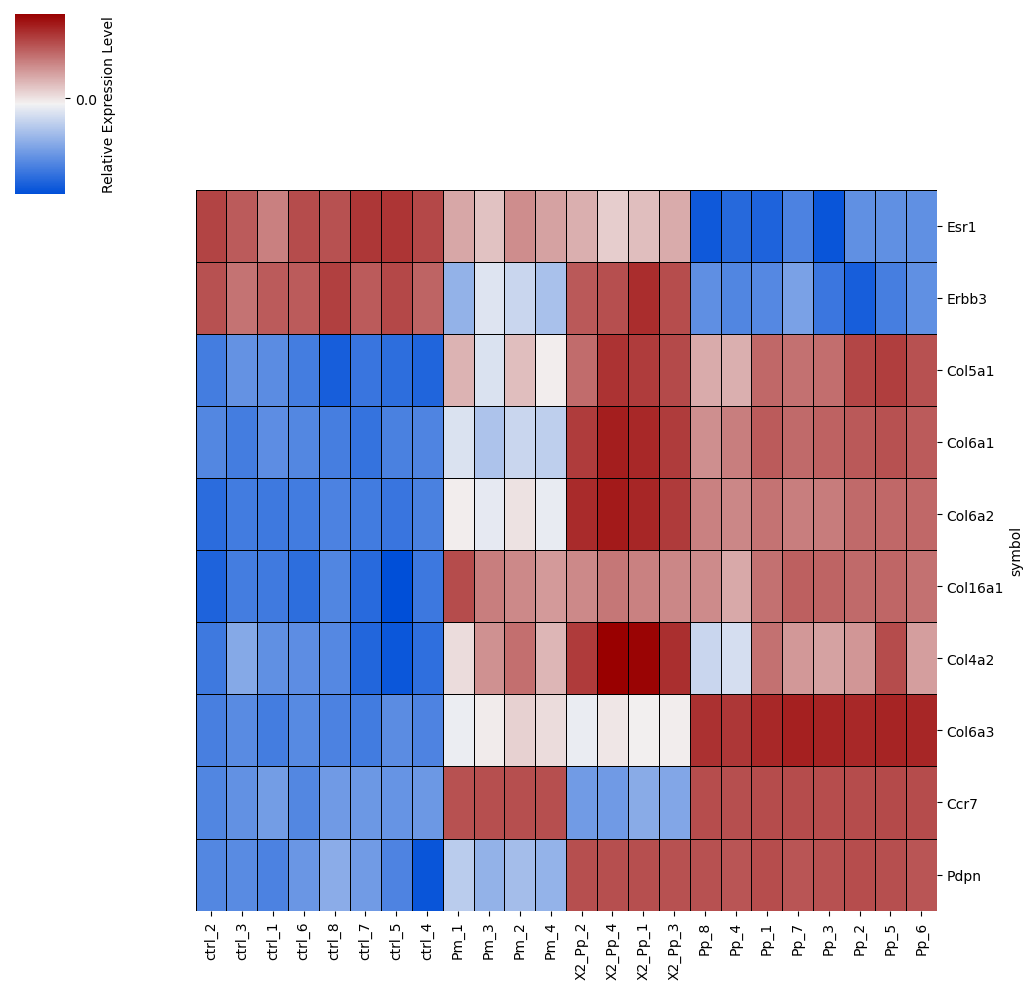

In [500]:
hm_collagens= sns.clustermap(heatmap_collagens,cmap=palette_br,col_cluster=False,row_cluster=False,cbar_kws={"label": "Relative Expression Level","ticks": cbar_ticks_1},linewidths=0.5,
                      linecolor='black',z_score=0)
#hm_collagens.cax.yaxis.set_major_locator(FixedLocator(cbar_ticks_1))
#hm_collagens.cax.set_yticklabels(cbar_ticklabels_1)

plt.setp(hm_collagens.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()
hm_collagens.savefig('hm_collagens.png', transparent=True)

# Venn Diagram

In [348]:
up_Ctrl_vs_CPPN_me_set = set(up_Ctrl_vs_CPPN_me.index.unique())
up_Ctrl_vs_CNPP_me_set = set(up_Ctrl_vs_CNPP_me.index.unique())
up_Ctrl_vs_CPPP_me_set = set(up_Ctrl_vs_CPPP_me.index.unique())
up_CNPP_vs_CPPP_me_set = set(up_CPPPvsCNPP_me.index.unique())

In [349]:
down_Ctrl_vs_CPPN_me_set = set(down_Ctrl_vs_CPPN_me.index.unique())
down_Ctrl_vs_CNPP_me_set = set(down_Ctrl_vs_CNPP_me.index.unique())
down_Ctrl_vs_CPPP_me_set = set(down_Ctrl_vs_CPPP_me.index.unique())
down_CNPP_vs_CPPP_me_set = set(down_CPPPvsCNPP_me.index.unique())

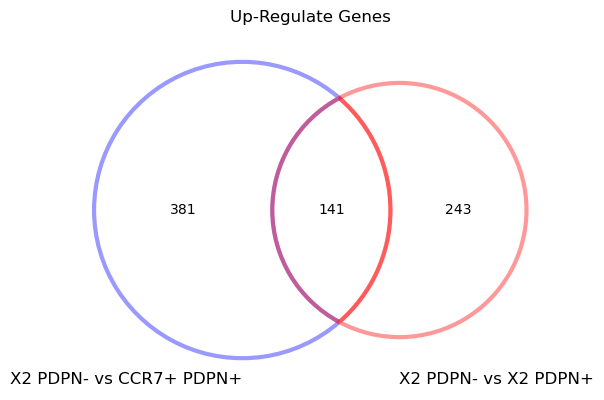

In [350]:
pdpn_V_up = venn2(subsets= (up_Ctrl_vs_CPPP_me_set, up_Ctrl_vs_CNPP_me_set),set_labels = ('X2 PDPN- vs CCR7+ PDPN+', 'X2 PDPN- vs X2 PDPN+'))

for region in ['10', '01', '11']:  
    patch = pdpn_V_up.get_patch_by_id(region)
    if patch:
        patch.set_edgecolor('blue' if region == '10' else 'red')
        patch.set_facecolor('none')  
        patch.set_linewidth(3)
        
lbl_v_pdpn_up = pdpn_V_up.get_label_by_id("B")
x_v_pdpn_up, y_v_pdpn_up = lbl_v_pdpn_up.get_position()
lbl_v_pdpn_up.set_position((x_v_pdpn_up, y_v_pdpn_up-0.065))

plt.title('Up-Regulate Genes')
plt.show()

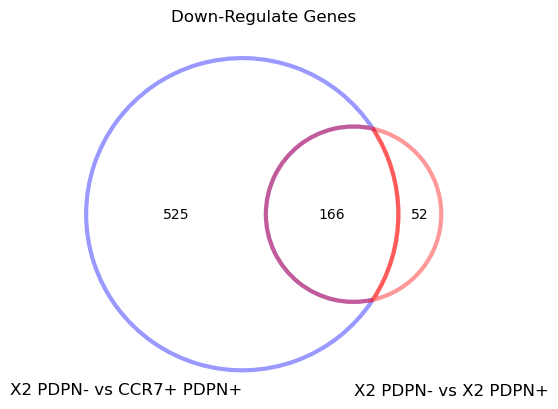

In [351]:
pdpn_V_down = venn2([down_Ctrl_vs_CPPP_me_set, down_Ctrl_vs_CNPP_me_set], ('X2 PDPN- vs CCR7+ PDPN+', 'X2 PDPN- vs X2 PDPN+'))

for region in ['10', '01', '11']:  
    patch = pdpn_V_down.get_patch_by_id(region)
    if patch:
        patch.set_edgecolor('blue' if region == '10' else 'red')
        patch.set_facecolor('none')  
        patch.set_linewidth(3)
        
lbl_v_pdpn_down = pdpn_V_down.get_label_by_id("B")
x_v_pdpn_down,y_v_pdpn_down = lbl_v_pdpn_down.get_position()
lbl_v_pdpn_down.set_position((x_v_pdpn_down,y_v_pdpn_down-0.241))

plt.title('Down-Regulate Genes')
plt.show()

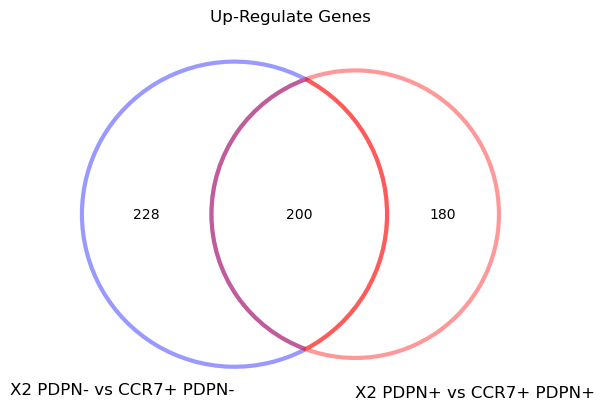

In [352]:
ccr7_V_up = venn2([up_Ctrl_vs_CPPN_me_set, up_CNPP_vs_CPPP_me_set], ('X2 PDPN- vs CCR7+ PDPN-', 'X2 PDPN+ vs CCR7+ PDPN+'))

for region in ['10', '01', '11']:  
    patch = ccr7_V_up.get_patch_by_id(region)
    if patch:
        patch.set_edgecolor('blue' if region == '10' else 'red')
        patch.set_facecolor('none')  
        patch.set_linewidth(3)

lbl_v_ccr7_up = ccr7_V_up.get_label_by_id("B")
x_v_ccr7_up, y_v_ccr7_up = lbl_v_ccr7_up.get_position()
lbl_v_ccr7_up.set_position((x_v_ccr7_up, y_v_ccr7_up-0.03798))


plt.title('Up-Regulate Genes')
plt.show()

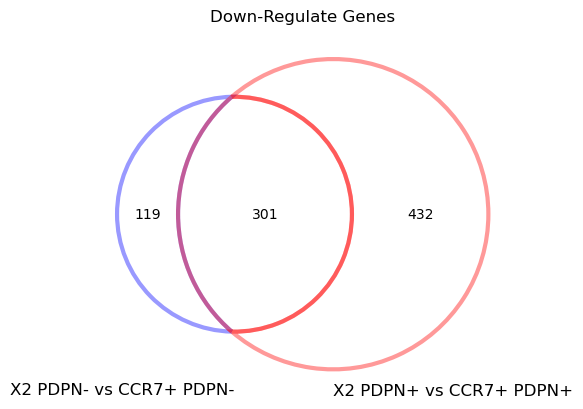

In [353]:
ccr7_V_down = venn2([down_Ctrl_vs_CPPN_me_set, down_CNPP_vs_CPPP_me_set], ('X2 PDPN- vs CCR7+ PDPN-', 'X2 PDPN+ vs CCR7+ PDPN+'))

for region in ['10', '01', '11']:  
    patch = ccr7_V_down.get_patch_by_id(region)
    if patch:
        patch.set_edgecolor('blue' if region == '10' else 'red')
        patch.set_facecolor('none')  
        patch.set_linewidth(3)

lbl_v_ccr7_down = ccr7_V_down.get_label_by_id("A")
x_v_ccr7_down, y_v_ccr7_down = lbl_v_ccr7_down.get_position()
lbl_v_ccr7_down.set_position((x_v_ccr7_down, y_v_ccr7_down-0.124))

plt.title('Down-Regulate Genes')
plt.show()

# Voline plot

In [364]:
#tpm_me_vp = tpm_me.copy()

In [ ]:
#tpm_me_vp=tpm_me_vp.T

In [ ]:
#tpm_me_vp.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']
#tpm_me_vp.set_index('symbol',inplace = True)

In [ ]:
#df_long = heatmap_GOI.reset_index().melt(id_vars='symbol', var_name='Genotype', value_name='lograwcounts')

In [ ]:
#df_long

In [ ]:
#df_long = df_long.set_index('symbol')

In [ ]:
#erbb2_row = df_long.loc['Erbb2']

In [ ]:
#erbb2_row

# Umap - no idea to adjust

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
import umap

reducer = umap.UMAP(n_neighbors=5)

combo_df_1.index.value_counts()

scaled_combo_df_1 = StandardScaler().fit_transform(combo_df_1)

embedding = reducer.fit_transform(scaled_combo_df_1)
embedding.shape

color_mapping = {}

for idx, index in enumerate(combo_df_1.index):
    color_mapping[index] = idx
    
color_palette = sns.color_palette("hls", n_colors=30)

for i, (x, y) in enumerate(zip(embedding[:, 0], embedding[:, 1])):
    index = combo_df_1.index[i]
    color = color_palette[color_mapping[index] % len(color_palette)]
    plt.scatter(x,y,c=[color])
    plt.text(x, y, index, fontsize=12, ha='center', va='center')
    
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=10);

color_mapping = {}
for idx, index in enumerate(combo_df_1.index):
    if index.startswith("ctrl"):
        color_mapping[index] = "green"
    elif index.startswith("Pp"):
        color_mapping[index] = "blue"
    elif index.startswith("Pm"):
        color_mapping[index] = "red"
    elif index.startswith("X2"):
        color_mapping[index] = "yellow"

for i, (x, y) in enumerate(zip(embedding[:, 0], embedding[:, 1])):
    index = combo_df_1.index[i]
    color = color_mapping[index]
    plt.scatter(x, y, c=[color], label=index)  
    
plt.gca().set_aspect('equal', 'datalim')
plt.legend(loc='upper right', fontsize=6)  
plt.title('UMAP projection', fontsize=10)
plt.show()


# Combination of DEGs from different comparison 

In [ ]:
# don't run it again
gsea(b)

In [ ]:
add_prefix_to_columns(res_CNPP_vs_CPPN_results_me,'x2pp_vs_pm ')

In [ ]:
add_prefix_to_columns(res_CNPP_vs_CPPP_results_me,'x2pp_vs_pp ')

In [ ]:
add_prefix_to_columns(res_CPPN_vs_CPPP_results_me,'pm_vs_pp ')

In [ ]:
add_prefix_to_columns(res_Ctrl_vs_CNPP_results_me,'ctrl_vs_x2pp ')

In [ ]:
add_prefix_to_columns(res_Ctrl_vs_CPPP_results_me,'ctrl_vs_pp ')

In [ ]:
add_prefix_to_columns(res_Ctrl_vs_CPPN_results_me,'ctrl_vs_pm ')

In [ ]:
dfs=[res_Ctrl_vs_CPPN_results_me,res_Ctrl_vs_CPPP_results_me,res_Ctrl_vs_CNPP_results_me,
    res_CNPP_vs_CPPN_results_me,res_CNPP_vs_CPPP_results_me,res_CPPN_vs_CPPP_results_me]

In [ ]:
DEG_combined = pd.concat(dfs,axis=1)

In [ ]:
DEG_combined

In [ ]:
DEG_combined.loc[:,'symbol'] = combo_df_2.loc[:,'symbol_1']

In [ ]:
save(DEG_combined,'Diffexpres')

# Combination of two excels - DEGs

In [ ]:
# don't run it again
gsea()

In [ ]:
excel_068 = pd.read_csv('DiffGeneExpAnalysis_filtered_068.csv',index_col=0)
excel_122 = pd.read_csv('DiffGeneExpAnalysis_Flt_122.csv',index_col=0)

In [ ]:
result = pd.concat([excel_068, excel_122], axis=1, join='outer')

In [ ]:
result

In [ ]:
save(result,'combination_068&122')

In [ ]:
combination_downregualtion = pd.read_csv('combination_downregulation.csv',index_col=0)

hallmark_enrichment(combination_downregualtion)

combination_upregualtion = pd.read_csv('combination_upregulation.csv',index_col=0)
hallmark_enrichment(combination_upregualtion)

In [ ]:
# Combination of two excels - Rawcounts

In [ ]:
excel_068_rawcounts = pd.read_csv('068_rawcounts.csv',index_col=0)
excel_122_rawcounts = pd.read_csv('122_rawcounts.csv',index_col=0)

In [ ]:
result_rawcounts = pd.concat([excel_068_rawcounts, excel_122_rawcounts], axis=1, join='outer')

In [ ]:
save(result_rawcounts,'combination_rawcounts')